In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import cv2
import re

1.11.0+cu102 True
0.26.0


In [ ]:
img = cv2.imread('data/Real/images/img_1.png')
label = cv2.imread('data/Real/annotations/img_25.png')
img.shape,label.shape

In [ ]:
imgs = []
for i in range(292):
    img = cv2.imread('data/Real/annotations/img_{}.png'.format(str(i)))
    imgs.append(img)
    
np.unique(imgs)

imgs = np.array(imgs)
imgs.shape    

dico = {}


for i in range(13):
    dico[i] = len(imgs.flatten()[imgs.flatten() == i])/len(imgs.flatten())
    
dico

In [ ]:
img = mmcv.imread('data/Real/images/img_25.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

#split train/val set randomly
import random
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
                osp.join(data_root, ann_dir), suffix='.png')]

#random.shuffle(filename_list)
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    train_length = int(len(filename_list)*0.75)
    f.writelines(line + '\n' for line in filename_list[:train_length])

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
imgs = []
with open("data/Real/splits/val.txt","r") as f:
    for line in f:
        path = "data/Real/annotations/" + re.search("img\_\d+",str(line))[0] +".png"
        img = cv2.imread(path)
        imgs.append(img)
        
imgs = np.array(imgs)
print(imgs.shape) 

dico1 = {}


for i in range(12):
    dico1[i] = len(imgs.flatten()[imgs.flatten() == i])/len(imgs.flatten())
    
dico1

In [ ]:
imgs = []
with open("data/Real/splits/train.txt","r") as f:
    for line in f:
        path = "data/Real/annotations/" + re.search("img\_\d+",str(line))[0] +".png"
        img = cv2.imread(path)
        imgs.append(img)        
imgs = np.array(imgs)
print(imgs.shape)    
dico2 = {}
for i in range(12):
    dico2[i] = len(imgs.flatten()[imgs.flatten() == i])/len(imgs.flatten())
    
dico2

np.sum(np.abs(np.array(list(dico1.values())) - np.array(list(dico2.values()))))

In [2]:
# convert dataset annotation to semantic segmentation map
data_root = 'data/Real'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
CLASSES = ('background', 'buisson', 'champs', 'eau', 'falaise','foret_dense','foret_claire','pierrier','prairie','route','verger','batiment')
PALETTE = [[0,0,0],[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8], [9,9,9], [10,10,10], [11,11,11]]

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class HugoDataset(CustomDataset):
    CLASSES = CLASSES
    PALETTE = PALETTE
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                         split=split,reduce_zero_label=False, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None    

In [3]:
from mmcv import Config
cfg = Config.fromfile('configs/fastfcn/fastfcn_r50-d32_jpu_aspp_512x1024_80k_cityscapes.py')

norm_cfg = dict(type='SyncBN', requires_grad=True)
crop_size = (512, 512)
model = dict(
    pretrained=None,
    backbone=dict(
        drop_rate=0.,
        init_cfg=dict(
            type='Pretrained', checkpoint='pretrain/vit_large_p16.pth')),
    auxiliary_head=[
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=0,
            num_classes=19,
            dropout_ratio=0,
            norm_cfg=norm_cfg,
            num_convs=2,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=1,
            num_classes=19,
            dropout_ratio=0,
            norm_cfg=norm_cfg,
            num_convs=2,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=2,
            num_classes=19,
            dropout_ratio=0,
            norm_cfg=norm_cfg,
            num_convs=2,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4))
    ],
    test_cfg=dict(mode='slide', crop_size=crop_size, stride=(512, 512)))

optimizer = dict(
    weight_decay=0.0,
    paramwise_cfg=dict(custom_keys={'head': dict(lr_mult=10.)}))

data = dict(samples_per_gpu=1)

cfg.model.decode_head.in_channels = 2048
cfg.model.decode_head.in_index=2
cfg.model.decode_head.channels=512
cfg.model.decode_head.dilations = (1, 12, 24, 36)
cfg.model.decode_head.dropout_ratio = 0.1
cfg.model.decode_head.align_corners=False,
cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)

In [4]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.pretrained = None

#cfg.load_from = 'work_dirs/fastFCNN/last.pth'


cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.neck.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 12
cfg.model.auxiliary_head.num_classes = 12

# Modify dataset type and path
cfg.dataset_type = 'HugoDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/fastFCNN/'

cfg.total_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [5]:
with open('config.txt', 'w') as f:
    print(f'Config:\n{cfg.pretty_text}', 'config.txt', file=f) 

In [6]:
print(f'Config:\n{cfg.pretty_text}') 

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 2, 2),
        out_indices=(1, 2, 3),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='JPU',
        in_channels=(512, 1024, 2048),
        mid_channels=512,
        start_level=0,
        end_level=-1,
        dilations=(1, 2, 4, 8),
        align_corners=False,
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='ASPPHead',
        in_channels=2048,
        in_index=2,
        channels=512,
        dilations=(1, 12, 24, 36),
        dropout_ratio=0.1,
        num_classes=12,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dic

In [5]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)


2022-07-20 10:47:17,662 - mmseg - INFO - Loaded 219 images
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [8]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-18 16:55:47,492 - mmseg - INFO - Loaded 73 images
2022-07-18 16:55:47,494 - mmseg - INFO - Start running, host: hugo@hugobis, work_dir: /home/hugo/SwinTransfo/mmsegmentation/work_dirs/fastFCNN
2022-07-18 16:55:47,495 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMA

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 13.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:03:01,127 - mmseg - INFO - per class results:
2022-07-18 17:03:01,129 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.03 | 57.02 |
|   buisson    |  0.11 |  0.11 |
|    champs    | 48.66 | 64.91 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 41.79 | 86.33 |
| foret_claire |  1.15 |  1.16 |
|   pierrier   | 13.12 | 13.83 |
|   prairie    |  0.52 |  0.53 |
|    route     |  8.55 | 11.54 |
|    verger    | 10.73 | 30.05 |
|   batiment   |  0.0  |  0.0  |
+--------------+-------+-------+
2022-07-18 17:03:01,129 - mmseg - INFO - Summary:
2022-07-18 17:03:01,130 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 39.07 | 12.14 | 22.12 |
+-------+-------+-------+
2022-07-18 17:03:01,131 - mmseg - INFO - Iter(val) [73]	aAcc: 0.3907, mIoU: 0.1214, mAcc: 0.2212, IoU.background: 0.2103, IoU.buisson: 0.0011, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:10:15,417 - mmseg - INFO - per class results:
2022-07-18 17:10:15,418 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  8.64 | 10.71 |
|   buisson    |  5.43 |  5.54 |
|    champs    | 53.28 | 87.22 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  2.36 |  3.3  |
| foret_dense  | 37.24 | 52.43 |
| foret_claire | 21.87 | 54.89 |
|   pierrier   | 35.72 | 39.26 |
|   prairie    | 20.15 | 26.58 |
|    route     |  6.46 |  7.81 |
|    verger    | 23.41 | 60.32 |
|   batiment   |  0.0  |  0.0  |
+--------------+-------+-------+
2022-07-18 17:10:15,419 - mmseg - INFO - Summary:
2022-07-18 17:10:15,419 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 42.08 | 17.88 | 29.01 |
+-------+-------+-------+
2022-07-18 17:10:15,420 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4208, mIoU: 0.1788, mAcc: 0.2901, IoU.background: 0.0864, IoU.buisson: 0.0543, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:17:32,023 - mmseg - INFO - per class results:
2022-07-18 17:17:32,024 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 11.64 | 14.27 |
|   buisson    |  2.63 |  2.64 |
|    champs    | 63.95 |  86.0 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 45.95 | 70.31 |
| foret_claire | 33.96 | 72.94 |
|   pierrier   |  8.51 |  8.51 |
|   prairie    | 19.27 | 31.86 |
|    route     | 11.68 | 15.18 |
|    verger    | 17.95 | 36.99 |
|   batiment   | 18.17 |  26.5 |
+--------------+-------+-------+
2022-07-18 17:17:32,025 - mmseg - INFO - Summary:
2022-07-18 17:17:32,026 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 47.97 | 19.48 | 30.43 |
+-------+-------+-------+
2022-07-18 17:17:32,026 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4797, mIoU: 0.1948, mAcc: 0.3043, IoU.background: 0.1164, IoU.buisson: 0.0263, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.1 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:24:46,854 - mmseg - INFO - per class results:
2022-07-18 17:24:46,855 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 19.96 | 32.75 |
|   buisson    | 20.59 | 34.17 |
|    champs    | 54.58 | 70.12 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.21 |  0.26 |
| foret_dense  | 49.79 | 82.34 |
| foret_claire | 19.04 | 30.16 |
|   pierrier   |  50.7 | 64.89 |
|   prairie    |  3.95 |  5.15 |
|    route     | 17.11 | 28.83 |
|    verger    | 38.31 | 50.71 |
|   batiment   | 10.34 |  12.8 |
+--------------+-------+-------+
2022-07-18 17:24:46,856 - mmseg - INFO - Summary:
2022-07-18 17:24:46,856 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 48.74 | 23.72 | 34.35 |
+-------+-------+-------+
2022-07-18 17:24:46,857 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4874, mIoU: 0.2372, mAcc: 0.3435, IoU.background: 0.1996, IoU.buisson: 0.2059, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:32:04,228 - mmseg - INFO - per class results:
2022-07-18 17:32:04,229 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 14.05 | 22.48 |
|   buisson    | 52.36 | 58.11 |
|    champs    | 41.95 | 46.36 |
|     eau      |  3.49 |  3.49 |
|   falaise    |  7.7  |  8.58 |
| foret_dense  |  56.4 | 79.08 |
| foret_claire | 30.85 | 76.54 |
|   pierrier   | 44.48 | 52.13 |
|   prairie    |  3.4  |  3.81 |
|    route     |  9.21 | 14.06 |
|    verger    | 41.17 | 46.53 |
|   batiment   | 11.13 | 21.14 |
+--------------+-------+-------+
2022-07-18 17:32:04,230 - mmseg - INFO - Summary:
2022-07-18 17:32:04,230 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 53.23 | 26.35 | 36.02 |
+-------+-------+-------+
2022-07-18 17:32:04,231 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5323, mIoU: 0.2635, mAcc: 0.3602, IoU.background: 0.1405, IoU.buisson: 0.5236, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:39:18,660 - mmseg - INFO - per class results:
2022-07-18 17:39:18,661 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 19.53 | 44.31 |
|   buisson    | 58.41 | 65.07 |
|    champs    | 58.11 | 86.77 |
|     eau      |  0.0  |  0.0  |
|   falaise    | 25.71 |  29.3 |
| foret_dense  | 56.18 | 77.87 |
| foret_claire | 33.96 | 47.01 |
|   pierrier   |  0.0  |  0.0  |
|   prairie    | 16.61 | 21.18 |
|    route     | 12.57 |  15.4 |
|    verger    | 44.35 | 70.96 |
|   batiment   |  5.44 | 13.36 |
+--------------+-------+-------+
2022-07-18 17:39:18,662 - mmseg - INFO - Summary:
2022-07-18 17:39:18,662 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 56.74 | 27.57 | 39.27 |
+-------+-------+-------+
2022-07-18 17:39:18,663 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5674, mIoU: 0.2757, mAcc: 0.3927, IoU.background: 0.1953, IoU.buisson: 0.5841, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:46:33,160 - mmseg - INFO - per class results:
2022-07-18 17:46:33,161 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.38 |  48.3 |
|   buisson    | 12.04 | 12.05 |
|    champs    | 43.34 | 61.57 |
|     eau      |  0.65 |  0.65 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 56.28 | 84.98 |
| foret_claire | 31.34 | 37.88 |
|   pierrier   | 17.07 | 23.94 |
|   prairie    |  0.52 |  0.53 |
|    route     | 16.33 | 27.01 |
|    verger    |  19.1 | 58.52 |
|   batiment   |  5.21 | 19.48 |
+--------------+-------+-------+
2022-07-18 17:46:33,161 - mmseg - INFO - Summary:
2022-07-18 17:46:33,162 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 47.2 | 18.52 | 31.24 |
+------+-------+-------+
2022-07-18 17:46:33,163 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4720, mIoU: 0.1852, mAcc: 0.3124, IoU.background: 0.2038, IoU.buisson: 0.1204, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-18 17:53:50,544 - mmseg - INFO - per class results:
2022-07-18 17:53:50,545 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.12 | 26.56 |
|   buisson    | 39.42 | 81.72 |
|    champs    | 62.38 | 89.89 |
|     eau      | 31.82 | 43.94 |
|   falaise    |  0.34 |  0.38 |
| foret_dense  | 54.34 | 66.23 |
| foret_claire | 22.19 |  31.1 |
|   pierrier   | 44.92 | 86.36 |
|   prairie    | 16.37 | 17.88 |
|    route     | 30.69 | 45.56 |
|    verger    | 38.22 | 66.64 |
|   batiment   |  2.23 |  2.25 |
+--------------+-------+-------+
2022-07-18 17:53:50,546 - mmseg - INFO - Summary:
2022-07-18 17:53:50,547 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 55.62 | 30.09 | 46.54 |
+-------+-------+-------+
2022-07-18 17:53:50,548 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5562, mIoU: 0.3009, mAcc: 0.4654, IoU.background: 0.1812, IoU.buisson: 0.3942, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:01:05,540 - mmseg - INFO - per class results:
2022-07-18 18:01:05,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.59 | 37.23 |
|   buisson    |  59.9 | 77.48 |
|    champs    | 48.73 | 62.57 |
|     eau      | 58.28 | 62.53 |
|   falaise    | 13.05 | 69.93 |
| foret_dense  | 59.77 | 67.52 |
| foret_claire | 42.45 | 63.09 |
|   pierrier   | 10.57 | 11.01 |
|   prairie    | 30.71 |  41.5 |
|    route     | 20.35 | 50.86 |
|    verger    | 47.49 |  82.2 |
|   batiment   | 22.42 | 26.73 |
+--------------+-------+-------+
2022-07-18 18:01:05,542 - mmseg - INFO - Summary:
2022-07-18 18:01:05,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.09 | 36.27 | 54.39 |
+-------+-------+-------+
2022-07-18 18:01:05,543 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6009, mIoU: 0.3627, mAcc: 0.5439, IoU.background: 0.2159, IoU.buisson: 0.5990, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:08:23,013 - mmseg - INFO - per class results:
2022-07-18 18:08:23,015 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 16.66 | 24.04 |
|   buisson    | 59.53 | 62.76 |
|    champs    | 63.98 | 87.11 |
|     eau      | 44.47 | 44.47 |
|   falaise    | 23.43 | 29.47 |
| foret_dense  |  59.3 |  83.8 |
| foret_claire |  41.3 | 70.32 |
|   pierrier   | 36.97 | 42.12 |
|   prairie    | 17.34 | 19.46 |
|    route     | 25.03 | 29.07 |
|    verger    | 48.38 |  77.7 |
|   batiment   |  2.71 |  2.88 |
+--------------+-------+-------+
2022-07-18 18:08:23,015 - mmseg - INFO - Summary:
2022-07-18 18:08:23,016 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.98 | 36.59 | 47.77 |
+-------+-------+-------+
2022-07-18 18:08:23,017 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6298, mIoU: 0.3659, mAcc: 0.4777, IoU.background: 0.1666, IoU.buisson: 0.5953, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:15:38,180 - mmseg - INFO - per class results:
2022-07-18 18:15:38,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.71 | 32.51 |
|   buisson    | 46.24 | 81.47 |
|    champs    | 62.07 | 79.73 |
|     eau      | 34.46 | 34.55 |
|   falaise    |  2.18 |  2.56 |
| foret_dense  | 56.61 | 65.24 |
| foret_claire | 22.86 | 31.61 |
|   pierrier   | 53.93 | 74.77 |
|   prairie    | 35.52 | 52.81 |
|    route     | 31.48 | 44.53 |
|    verger    | 41.26 | 89.19 |
|   batiment   | 18.42 | 20.07 |
+--------------+-------+-------+
2022-07-18 18:15:38,182 - mmseg - INFO - Summary:
2022-07-18 18:15:38,183 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 58.85 | 35.48 | 50.75 |
+-------+-------+-------+
2022-07-18 18:15:38,184 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5885, mIoU: 0.3548, mAcc: 0.5075, IoU.background: 0.2071, IoU.buisson: 0.4624, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:22:53,324 - mmseg - INFO - per class results:
2022-07-18 18:22:53,326 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.25 | 45.02 |
|   buisson    | 60.24 | 83.48 |
|    champs    | 60.71 | 82.81 |
|     eau      | 62.57 |  64.0 |
|   falaise    |  4.39 |  6.04 |
| foret_dense  | 56.08 | 62.41 |
| foret_claire | 37.29 | 48.62 |
|   pierrier   | 29.14 | 48.38 |
|   prairie    | 38.97 | 55.39 |
|    route     | 23.78 | 29.13 |
|    verger    | 47.86 | 85.18 |
|   batiment   | 16.34 |  57.8 |
+--------------+-------+-------+
2022-07-18 18:22:53,326 - mmseg - INFO - Summary:
2022-07-18 18:22:53,327 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 62.2 | 38.55 | 55.69 |
+------+-------+-------+
2022-07-18 18:22:53,328 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6220, mIoU: 0.3855, mAcc: 0.5569, IoU.background: 0.2525, IoU.buisson: 0.6024, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:30:11,464 - mmseg - INFO - per class results:
2022-07-18 18:30:11,466 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.96 | 34.22 |
|   buisson    | 42.73 | 52.11 |
|    champs    | 48.08 | 84.81 |
|     eau      | 49.25 | 49.52 |
|   falaise    | 23.81 | 30.92 |
| foret_dense  | 61.46 | 80.32 |
| foret_claire | 37.92 | 52.63 |
|   pierrier   | 45.54 | 58.44 |
|   prairie    | 32.34 | 44.01 |
|    route     | 25.89 | 36.29 |
|    verger    | 48.18 | 57.07 |
|   batiment   |  9.9  | 21.97 |
+--------------+-------+-------+
2022-07-18 18:30:11,466 - mmseg - INFO - Summary:
2022-07-18 18:30:11,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.85 | 37.17 | 50.19 |
+-------+-------+-------+
2022-07-18 18:30:11,467 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6085, mIoU: 0.3717, mAcc: 0.5019, IoU.background: 0.2096, IoU.buisson: 0.4273, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:37:26,842 - mmseg - INFO - per class results:
2022-07-18 18:37:26,844 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.36 | 38.87 |
|   buisson    | 57.95 | 86.83 |
|    champs    | 60.62 | 75.24 |
|     eau      | 43.58 | 46.77 |
|   falaise    | 16.19 | 68.61 |
| foret_dense  |  57.1 |  66.7 |
| foret_claire | 37.07 | 50.93 |
|   pierrier   |  3.46 |  3.47 |
|   prairie    | 37.22 | 61.33 |
|    route     | 12.95 | 15.51 |
|    verger    | 53.77 | 80.28 |
|   batiment   | 11.49 | 14.53 |
+--------------+-------+-------+
2022-07-18 18:37:26,844 - mmseg - INFO - Summary:
2022-07-18 18:37:26,845 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 60.75 | 34.4 | 50.75 |
+-------+------+-------+
2022-07-18 18:37:26,845 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6075, mIoU: 0.3440, mAcc: 0.5075, IoU.background: 0.2136, IoU.buisson: 0.5795, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:44:44,975 - mmseg - INFO - per class results:
2022-07-18 18:44:44,976 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.65 | 40.67 |
|   buisson    | 68.81 | 77.49 |
|    champs    | 64.77 | 75.24 |
|     eau      | 69.44 | 75.16 |
|   falaise    |  2.86 |  3.76 |
| foret_dense  | 49.51 | 52.99 |
| foret_claire | 42.17 | 74.61 |
|   pierrier   |  46.8 | 74.06 |
|   prairie    | 35.54 | 60.31 |
|    route     | 22.44 |  31.6 |
|    verger    | 66.02 | 83.49 |
|   batiment   | 17.02 | 19.35 |
+--------------+-------+-------+
2022-07-18 18:44:44,977 - mmseg - INFO - Summary:
2022-07-18 18:44:44,977 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 63.01 | 42.25 | 55.73 |
+-------+-------+-------+
2022-07-18 18:44:44,978 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6301, mIoU: 0.4225, mAcc: 0.5573, IoU.background: 0.2165, IoU.buisson: 0.6881, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:52:00,348 - mmseg - INFO - per class results:
2022-07-18 18:52:00,349 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.22 | 44.24 |
|   buisson    | 52.95 |  89.3 |
|    champs    | 49.76 | 61.53 |
|     eau      | 63.13 | 67.01 |
|   falaise    | 14.59 | 17.92 |
| foret_dense  | 52.36 | 56.78 |
| foret_claire | 30.14 | 39.78 |
|   pierrier   |  8.23 |  8.96 |
|   prairie    | 34.89 | 63.43 |
|    route     | 16.52 | 25.88 |
|    verger    | 37.65 | 86.75 |
|   batiment   | 13.83 | 18.09 |
+--------------+-------+-------+
2022-07-18 18:52:00,349 - mmseg - INFO - Summary:
2022-07-18 18:52:00,350 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 56.53 | 33.1 | 48.31 |
+-------+------+-------+
2022-07-18 18:52:00,351 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5653, mIoU: 0.3310, mAcc: 0.4831, IoU.background: 0.2322, IoU.buisson: 0.5295, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.0 task/s, elapsed: 5s, ETA:     0s

2022-07-18 18:59:15,855 - mmseg - INFO - per class results:
2022-07-18 18:59:15,857 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  20.9 | 40.85 |
|   buisson    | 52.77 | 84.86 |
|    champs    | 29.72 |  36.6 |
|     eau      | 45.58 | 67.21 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 62.73 |  71.9 |
| foret_claire | 34.66 | 46.37 |
|   pierrier   | 11.19 | 14.63 |
|   prairie    | 34.92 |  52.1 |
|    route     |  17.4 | 38.95 |
|    verger    | 53.66 |  69.7 |
|   batiment   |  8.87 | 51.93 |
+--------------+-------+-------+
2022-07-18 18:59:15,857 - mmseg - INFO - Summary:
2022-07-18 18:59:15,858 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 56.69 | 31.03 | 47.93 |
+-------+-------+-------+
2022-07-18 18:59:15,858 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5669, mIoU: 0.3103, mAcc: 0.4793, IoU.background: 0.2090, IoU.buisson: 0.5277, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:06:33,846 - mmseg - INFO - per class results:
2022-07-18 19:06:33,848 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.86 | 41.87 |
|   buisson    | 62.67 | 83.44 |
|    champs    | 50.03 | 57.37 |
|     eau      | 69.65 | 72.67 |
|   falaise    | 34.24 | 53.44 |
| foret_dense  | 66.33 | 88.02 |
| foret_claire | 39.12 | 49.24 |
|   pierrier   | 33.25 | 36.67 |
|   prairie    | 37.69 | 50.17 |
|    route     | 21.07 | 50.23 |
|    verger    | 62.11 |  75.3 |
|   batiment   | 20.77 | 38.17 |
+--------------+-------+-------+
2022-07-18 19:06:33,848 - mmseg - INFO - Summary:
2022-07-18 19:06:33,849 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 65.59 | 43.4 | 58.05 |
+-------+------+-------+
2022-07-18 19:06:33,849 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6559, mIoU: 0.4340, mAcc: 0.5805, IoU.background: 0.2386, IoU.buisson: 0.6267, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:13:49,249 - mmseg - INFO - per class results:
2022-07-18 19:13:49,251 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.34 | 32.58 |
|   buisson    |  58.7 | 89.17 |
|    champs    | 63.69 |  77.7 |
|     eau      | 60.91 | 69.31 |
|   falaise    | 18.31 | 42.89 |
| foret_dense  | 58.13 | 65.42 |
| foret_claire | 38.14 | 58.52 |
|   pierrier   | 40.97 | 53.17 |
|   prairie    |  35.8 | 58.51 |
|    route     | 20.86 | 23.78 |
|    verger    | 52.03 | 59.62 |
|   batiment   |  4.38 |  7.44 |
+--------------+-------+-------+
2022-07-18 19:13:49,251 - mmseg - INFO - Summary:
2022-07-18 19:13:49,252 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.33 | 39.19 | 53.18 |
+-------+-------+-------+
2022-07-18 19:13:49,252 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6233, mIoU: 0.3919, mAcc: 0.5318, IoU.background: 0.1834, IoU.buisson: 0.5870, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:21:07,180 - mmseg - INFO - per class results:
2022-07-18 19:21:07,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.71 | 49.74 |
|   buisson    | 65.38 | 88.41 |
|    champs    | 58.14 | 69.68 |
|     eau      | 63.66 | 77.18 |
|   falaise    |  5.76 |  8.32 |
| foret_dense  | 58.59 | 65.17 |
| foret_claire | 41.65 | 55.04 |
|   pierrier   | 16.52 | 20.24 |
|   prairie    | 41.09 |  68.7 |
|    route     | 27.08 | 40.43 |
|    verger    | 62.76 | 79.48 |
|   batiment   | 13.41 | 43.03 |
+--------------+-------+-------+
2022-07-18 19:21:07,182 - mmseg - INFO - Summary:
2022-07-18 19:21:07,183 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 63.7 | 39.9 | 55.45 |
+------+------+-------+
2022-07-18 19:21:07,183 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6370, mIoU: 0.3990, mAcc: 0.5545, IoU.background: 0.2471, IoU.buisson: 0.6538, IoU.champs: 0.5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:28:22,702 - mmseg - INFO - per class results:
2022-07-18 19:28:22,703 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  20.5 |  35.5 |
|   buisson    | 39.77 | 70.22 |
|    champs    | 58.73 | 61.86 |
|     eau      | 66.51 | 70.65 |
|   falaise    |  0.01 |  0.01 |
| foret_dense  | 59.43 | 64.74 |
| foret_claire | 35.08 | 56.88 |
|   pierrier   | 36.67 | 53.28 |
|   prairie    | 37.78 | 71.86 |
|    route     | 21.43 | 33.04 |
|    verger    | 38.54 | 39.46 |
|   batiment   | 11.87 | 30.11 |
+--------------+-------+-------+
2022-07-18 19:28:22,704 - mmseg - INFO - Summary:
2022-07-18 19:28:22,704 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 58.29 | 35.53 | 48.97 |
+-------+-------+-------+
2022-07-18 19:28:22,705 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5829, mIoU: 0.3553, mAcc: 0.4897, IoU.background: 0.2050, IoU.buisson: 0.3977, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:35:38,159 - mmseg - INFO - per class results:
2022-07-18 19:35:38,160 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.39 | 54.15 |
|   buisson    | 62.99 | 78.26 |
|    champs    | 58.33 | 69.73 |
|     eau      | 71.72 | 79.89 |
|   falaise    | 37.87 | 71.67 |
| foret_dense  | 61.75 | 68.38 |
| foret_claire |  43.4 | 60.22 |
|   pierrier   | 39.65 | 42.87 |
|   prairie    | 41.22 | 66.77 |
|    route     | 33.09 | 49.41 |
|    verger    | 58.84 | 79.25 |
|   batiment   | 19.63 | 33.55 |
+--------------+-------+-------+
2022-07-18 19:35:38,160 - mmseg - INFO - Summary:
2022-07-18 19:35:38,161 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.14 | 46.32 | 62.85 |
+-------+-------+-------+
2022-07-18 19:35:38,162 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6614, mIoU: 0.4632, mAcc: 0.6285, IoU.background: 0.2739, IoU.buisson: 0.6299, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:42:56,216 - mmseg - INFO - per class results:
2022-07-18 19:42:56,218 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.77 | 53.61 |
|   buisson    | 66.26 | 84.56 |
|    champs    | 57.91 | 82.12 |
|     eau      | 76.39 | 82.26 |
|   falaise    |  28.7 | 65.07 |
| foret_dense  | 43.68 | 48.25 |
| foret_claire | 34.57 | 40.84 |
|   pierrier   | 48.83 | 51.76 |
|   prairie    | 31.35 | 75.11 |
|    route     |  29.8 | 37.73 |
|    verger    | 65.96 | 73.35 |
|   batiment   | 31.47 | 51.26 |
+--------------+-------+-------+
2022-07-18 19:42:56,218 - mmseg - INFO - Summary:
2022-07-18 19:42:56,219 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.28 | 45.06 | 62.16 |
+-------+-------+-------+
2022-07-18 19:42:56,219 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6028, mIoU: 0.4506, mAcc: 0.6216, IoU.background: 0.2577, IoU.buisson: 0.6626, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:50:11,872 - mmseg - INFO - per class results:
2022-07-18 19:50:11,874 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.26 | 41.73 |
|   buisson    |  66.7 |  76.1 |
|    champs    | 67.64 | 77.01 |
|     eau      | 68.32 | 84.15 |
|   falaise    | 37.46 | 65.59 |
| foret_dense  | 72.48 | 86.96 |
| foret_claire | 46.64 | 66.71 |
|   pierrier   | 60.11 | 67.05 |
|   prairie    | 48.89 | 69.13 |
|    route     | 32.07 | 40.06 |
|    verger    | 67.06 | 70.82 |
|   batiment   | 41.47 | 60.54 |
+--------------+-------+-------+
2022-07-18 19:50:11,874 - mmseg - INFO - Summary:
2022-07-18 19:50:11,875 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 72.4 | 52.92 | 67.15 |
+------+-------+-------+
2022-07-18 19:50:11,875 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7240, mIoU: 0.5292, mAcc: 0.6715, IoU.background: 0.2626, IoU.buisson: 0.6670, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 19:57:29,844 - mmseg - INFO - per class results:
2022-07-18 19:57:29,846 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  21.5 | 38.45 |
|   buisson    | 52.72 | 70.95 |
|    champs    | 58.17 | 69.54 |
|     eau      | 67.94 | 70.18 |
|   falaise    |  44.9 | 59.08 |
| foret_dense  | 66.88 | 85.05 |
| foret_claire | 38.77 | 53.32 |
|   pierrier   | 13.08 | 13.22 |
|   prairie    |  34.2 | 53.64 |
|    route     | 25.59 | 28.12 |
|    verger    | 61.58 | 78.66 |
|   batiment   | 17.99 | 47.08 |
+--------------+-------+-------+
2022-07-18 19:57:29,846 - mmseg - INFO - Summary:
2022-07-18 19:57:29,847 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 64.3 | 41.94 | 55.61 |
+------+-------+-------+
2022-07-18 19:57:29,848 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6430, mIoU: 0.4194, mAcc: 0.5561, IoU.background: 0.2150, IoU.buisson: 0.5272, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:04:45,313 - mmseg - INFO - per class results:
2022-07-18 20:04:45,315 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.49 | 29.51 |
|   buisson    | 71.06 | 82.58 |
|    champs    | 66.62 | 76.83 |
|     eau      | 73.08 | 76.51 |
|   falaise    | 25.77 | 68.03 |
| foret_dense  | 65.88 | 81.95 |
| foret_claire | 41.17 | 61.13 |
|   pierrier   | 43.89 | 46.69 |
|   prairie    | 45.75 | 71.69 |
|    route     | 37.03 | 44.75 |
|    verger    |  68.9 | 79.81 |
|   batiment   | 28.38 | 33.37 |
+--------------+-------+-------+
2022-07-18 20:04:45,315 - mmseg - INFO - Summary:
2022-07-18 20:04:45,316 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 69.41 | 49.0 | 62.74 |
+-------+------+-------+
2022-07-18 20:04:45,316 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6941, mIoU: 0.4900, mAcc: 0.6274, IoU.background: 0.2049, IoU.buisson: 0.7106, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:12:01,001 - mmseg - INFO - per class results:
2022-07-18 20:12:01,003 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.44 | 41.59 |
|   buisson    | 62.67 | 72.96 |
|    champs    | 66.28 |  81.1 |
|     eau      | 66.13 | 70.01 |
|   falaise    | 18.21 | 20.79 |
| foret_dense  | 63.45 | 87.91 |
| foret_claire | 37.17 | 49.36 |
|   pierrier   |  2.77 |  2.97 |
|   prairie    | 39.74 |  58.8 |
|    route     |  25.8 | 27.84 |
|    verger    | 69.81 | 75.06 |
|   batiment   |  12.6 | 33.77 |
+--------------+-------+-------+
2022-07-18 20:12:01,003 - mmseg - INFO - Summary:
2022-07-18 20:12:01,004 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.63 | 40.67 | 51.85 |
+-------+-------+-------+
2022-07-18 20:12:01,005 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6563, mIoU: 0.4067, mAcc: 0.5185, IoU.background: 0.2344, IoU.buisson: 0.6267, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:19:19,061 - mmseg - INFO - per class results:
2022-07-18 20:19:19,063 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.11 | 45.06 |
|   buisson    | 63.42 | 89.53 |
|    champs    | 69.91 | 80.71 |
|     eau      | 68.72 | 81.37 |
|   falaise    | 49.36 | 65.08 |
| foret_dense  | 71.62 | 81.74 |
| foret_claire | 43.54 | 55.22 |
|   pierrier   | 59.27 | 76.06 |
|   prairie    | 50.62 | 69.83 |
|    route     | 23.95 | 27.23 |
|    verger    | 67.78 | 80.78 |
|   batiment   |  27.9 |  36.5 |
+--------------+-------+-------+
2022-07-18 20:19:19,063 - mmseg - INFO - Summary:
2022-07-18 20:19:19,064 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.84 | 51.85 | 65.76 |
+-------+-------+-------+
2022-07-18 20:19:19,064 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7184, mIoU: 0.5185, mAcc: 0.6576, IoU.background: 0.2611, IoU.buisson: 0.6342, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:26:34,939 - mmseg - INFO - per class results:
2022-07-18 20:26:34,940 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.25 | 38.02 |
|   buisson    |  9.43 |  9.55 |
|    champs    | 52.66 | 82.35 |
|     eau      |  73.5 | 83.02 |
|   falaise    | 55.82 | 64.86 |
| foret_dense  | 65.43 | 75.26 |
| foret_claire | 46.23 | 72.92 |
|   pierrier   | 52.13 | 85.07 |
|   prairie    | 31.89 | 56.72 |
|    route     | 29.02 | 43.95 |
|    verger    | 63.58 |  66.6 |
|   batiment   | 29.29 | 56.51 |
+--------------+-------+-------+
2022-07-18 20:26:34,941 - mmseg - INFO - Summary:
2022-07-18 20:26:34,941 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.29 | 44.35 | 61.23 |
+-------+-------+-------+
2022-07-18 20:26:34,942 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6229, mIoU: 0.4435, mAcc: 0.6123, IoU.background: 0.2325, IoU.buisson: 0.0943, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:33:53,403 - mmseg - INFO - per class results:
2022-07-18 20:33:53,405 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.74 | 42.12 |
|   buisson    | 65.17 |  76.7 |
|    champs    | 57.75 | 64.25 |
|     eau      | 69.08 | 74.84 |
|   falaise    |  10.0 | 14.03 |
| foret_dense  | 67.59 | 87.71 |
| foret_claire | 36.61 |  44.3 |
|   pierrier   |  8.42 | 11.48 |
|   prairie    | 43.85 |  71.5 |
|    route     | 29.58 | 34.94 |
|    verger    | 67.88 |  73.8 |
|   batiment   | 13.58 | 73.63 |
+--------------+-------+-------+
2022-07-18 20:33:53,405 - mmseg - INFO - Summary:
2022-07-18 20:33:53,406 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 65.34 | 41.1 | 55.78 |
+-------+------+-------+
2022-07-18 20:33:53,406 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6534, mIoU: 0.4110, mAcc: 0.5578, IoU.background: 0.2374, IoU.buisson: 0.6517, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:41:09,434 - mmseg - INFO - per class results:
2022-07-18 20:41:09,436 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.69 | 26.91 |
|   buisson    | 65.42 | 76.85 |
|    champs    | 71.01 | 84.68 |
|     eau      | 64.65 | 75.21 |
|   falaise    | 24.53 | 25.02 |
| foret_dense  | 70.33 | 86.09 |
| foret_claire | 41.71 | 73.68 |
|   pierrier   | 19.22 | 20.11 |
|   prairie    | 46.19 | 62.76 |
|    route     | 33.51 | 37.39 |
|    verger    | 60.08 | 63.11 |
|   batiment   | 17.83 | 23.73 |
+--------------+-------+-------+
2022-07-18 20:41:09,436 - mmseg - INFO - Summary:
2022-07-18 20:41:09,437 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.98 | 44.43 | 54.63 |
+-------+-------+-------+
2022-07-18 20:41:09,437 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6898, mIoU: 0.4443, mAcc: 0.5463, IoU.background: 0.1869, IoU.buisson: 0.6542, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:48:27,336 - mmseg - INFO - per class results:
2022-07-18 20:48:27,337 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 22.81 | 54.85 |
|   buisson    | 40.18 | 56.99 |
|    champs    | 65.41 | 85.59 |
|     eau      | 61.16 | 64.61 |
|   falaise    | 37.28 | 45.22 |
| foret_dense  | 63.65 | 71.92 |
| foret_claire | 34.16 | 39.09 |
|   pierrier   |  15.3 | 24.61 |
|   prairie    |  33.0 |  65.5 |
|    route     | 31.31 | 34.69 |
|    verger    | 61.89 | 64.57 |
|   batiment   |  9.46 | 13.52 |
+--------------+-------+-------+
2022-07-18 20:48:27,338 - mmseg - INFO - Summary:
2022-07-18 20:48:27,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.46 | 39.63 | 51.76 |
+-------+-------+-------+
2022-07-18 20:48:27,339 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6046, mIoU: 0.3963, mAcc: 0.5176, IoU.background: 0.2281, IoU.buisson: 0.4018, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-18 20:55:43,120 - mmseg - INFO - per class results:
2022-07-18 20:55:43,121 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.8 | 55.02 |
|   buisson    |  47.6 | 68.89 |
|    champs    |  60.3 | 85.32 |
|     eau      | 74.96 | 79.78 |
|   falaise    | 57.01 | 65.96 |
| foret_dense  |  72.5 | 85.02 |
| foret_claire | 29.08 | 32.53 |
|   pierrier   | 59.84 | 65.86 |
|   prairie    | 45.18 |  62.5 |
|    route     | 40.62 | 59.67 |
|    verger    | 70.08 |  74.6 |
|   batiment   | 35.34 | 60.14 |
+--------------+-------+-------+
2022-07-18 20:55:43,122 - mmseg - INFO - Summary:
2022-07-18 20:55:43,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.77 | 51.61 | 66.27 |
+-------+-------+-------+
2022-07-18 20:55:43,123 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6777, mIoU: 0.5161, mAcc: 0.6627, IoU.background: 0.2680, IoU.buisson: 0.4760, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:02:58,950 - mmseg - INFO - per class results:
2022-07-18 21:02:58,952 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.44 | 42.25 |
|   buisson    | 62.67 | 78.24 |
|    champs    | 65.14 | 78.83 |
|     eau      | 76.29 | 83.06 |
|   falaise    | 45.53 | 59.33 |
| foret_dense  | 71.69 | 87.17 |
| foret_claire | 42.21 | 55.73 |
|   pierrier   | 62.39 | 71.06 |
|   prairie    | 47.06 | 70.15 |
|    route     | 42.34 | 55.19 |
|    verger    | 67.98 | 71.38 |
|   batiment   | 38.62 |  50.2 |
+--------------+-------+-------+
2022-07-18 21:02:58,952 - mmseg - INFO - Summary:
2022-07-18 21:02:58,953 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.65 | 54.03 | 66.88 |
+-------+-------+-------+
2022-07-18 21:02:58,954 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7165, mIoU: 0.5403, mAcc: 0.6688, IoU.background: 0.2644, IoU.buisson: 0.6267, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:10:17,211 - mmseg - INFO - per class results:
2022-07-18 21:10:17,214 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.41 | 50.36 |
|   buisson    | 58.98 | 89.26 |
|    champs    | 65.66 |  80.4 |
|     eau      | 71.07 | 79.02 |
|   falaise    | 42.79 | 58.81 |
| foret_dense  | 67.03 | 79.12 |
| foret_claire | 26.13 | 27.96 |
|   pierrier   | 11.03 | 11.33 |
|   prairie    | 45.58 |  70.5 |
|    route     | 40.31 | 50.28 |
|    verger    | 64.63 | 85.12 |
|   batiment   | 14.23 | 65.45 |
+--------------+-------+-------+
2022-07-18 21:10:17,214 - mmseg - INFO - Summary:
2022-07-18 21:10:17,215 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 65.77 | 44.49 | 62.3 |
+-------+-------+------+
2022-07-18 21:10:17,216 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6577, mIoU: 0.4449, mAcc: 0.6230, IoU.background: 0.2641, IoU.buisson: 0.5898, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:17:33,016 - mmseg - INFO - per class results:
2022-07-18 21:17:33,018 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.87 | 45.96 |
|   buisson    | 49.64 | 84.71 |
|    champs    | 66.15 | 74.67 |
|     eau      | 75.23 | 82.62 |
|   falaise    | 34.46 | 70.21 |
| foret_dense  | 68.52 | 79.19 |
| foret_claire | 34.52 | 43.74 |
|   pierrier   | 43.52 | 55.46 |
|   prairie    | 47.48 | 69.45 |
|    route     | 39.05 | 51.97 |
|    verger    | 52.33 | 53.96 |
|   batiment   | 23.25 |  49.7 |
+--------------+-------+-------+
2022-07-18 21:17:33,018 - mmseg - INFO - Summary:
2022-07-18 21:17:33,019 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.51 | 46.67 | 63.47 |
+-------+-------+-------+
2022-07-18 21:17:33,020 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6651, mIoU: 0.4667, mAcc: 0.6347, IoU.background: 0.2587, IoU.buisson: 0.4964, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:24:51,373 - mmseg - INFO - per class results:
2022-07-18 21:24:51,374 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.26 | 45.59 |
|   buisson    | 65.12 |  76.2 |
|    champs    | 59.59 | 77.03 |
|     eau      | 70.72 |  74.9 |
|   falaise    | 49.05 | 65.56 |
| foret_dense  | 71.95 |  83.7 |
| foret_claire | 47.13 | 67.66 |
|   pierrier   | 56.82 | 63.95 |
|   prairie    | 49.18 | 63.33 |
|    route     | 38.12 | 44.78 |
|    verger    | 61.59 | 74.86 |
|   batiment   | 26.22 | 32.33 |
+--------------+-------+-------+
2022-07-18 21:24:51,375 - mmseg - INFO - Summary:
2022-07-18 21:24:51,375 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.24 | 51.81 | 64.16 |
+-------+-------+-------+
2022-07-18 21:24:51,376 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7124, mIoU: 0.5181, mAcc: 0.6416, IoU.background: 0.2626, IoU.buisson: 0.6512, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:32:07,104 - mmseg - INFO - per class results:
2022-07-18 21:32:07,105 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.76 | 35.43 |
|   buisson    | 60.42 | 75.17 |
|    champs    | 67.44 |  78.4 |
|     eau      |  76.0 | 83.94 |
|   falaise    | 36.49 | 59.45 |
| foret_dense  | 72.92 | 83.93 |
| foret_claire | 47.82 | 72.68 |
|   pierrier   | 53.74 |  59.0 |
|   prairie    | 46.86 |  74.7 |
|    route     | 37.58 |  43.7 |
|    verger    | 61.11 | 65.19 |
|   batiment   | 34.85 |  39.4 |
+--------------+-------+-------+
2022-07-18 21:32:07,106 - mmseg - INFO - Summary:
2022-07-18 21:32:07,106 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.65 | 51.67 | 64.25 |
+-------+-------+-------+
2022-07-18 21:32:07,107 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7165, mIoU: 0.5167, mAcc: 0.6425, IoU.background: 0.2476, IoU.buisson: 0.6042, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:39:22,978 - mmseg - INFO - per class results:
2022-07-18 21:39:22,979 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.45 | 52.38 |
|   buisson    | 43.72 | 58.47 |
|    champs    | 72.61 | 81.94 |
|     eau      | 72.57 | 77.21 |
|   falaise    |  47.8 | 79.42 |
| foret_dense  | 65.97 | 75.98 |
| foret_claire | 30.36 | 35.21 |
|   pierrier   | 51.48 |  84.4 |
|   prairie    | 39.95 | 72.91 |
|    route     | 39.41 | 45.74 |
|    verger    |  71.9 | 80.89 |
|   batiment   | 25.48 | 78.22 |
+--------------+-------+-------+
2022-07-18 21:39:22,980 - mmseg - INFO - Summary:
2022-07-18 21:39:22,980 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 65.9 | 49.06 | 68.56 |
+------+-------+-------+
2022-07-18 21:39:22,981 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6590, mIoU: 0.4906, mAcc: 0.6856, IoU.background: 0.2745, IoU.buisson: 0.4372, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:46:41,072 - mmseg - INFO - per class results:
2022-07-18 21:46:41,075 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.95 | 45.23 |
|   buisson    | 68.64 |  84.6 |
|    champs    | 63.19 | 86.73 |
|     eau      | 77.33 | 83.29 |
|   falaise    | 43.28 | 79.04 |
| foret_dense  | 66.93 | 71.89 |
| foret_claire | 43.36 | 58.56 |
|   pierrier   | 57.27 | 85.84 |
|   prairie    | 52.64 | 73.29 |
|    route     | 44.83 | 53.89 |
|    verger    | 66.35 | 74.45 |
|   batiment   | 36.57 | 45.62 |
+--------------+-------+-------+
2022-07-18 21:46:41,076 - mmseg - INFO - Summary:
2022-07-18 21:46:41,076 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 70.94 | 53.86 | 70.2 |
+-------+-------+------+
2022-07-18 21:46:41,077 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7094, mIoU: 0.5386, mAcc: 0.7020, IoU.background: 0.2595, IoU.buisson: 0.6864, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 21:53:56,704 - mmseg - INFO - per class results:
2022-07-18 21:53:56,706 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.2 | 41.97 |
|   buisson    | 61.99 |  85.1 |
|    champs    | 74.41 | 88.74 |
|     eau      | 72.56 | 86.11 |
|   falaise    | 33.08 | 70.58 |
| foret_dense  | 62.27 | 65.42 |
| foret_claire | 41.69 | 70.06 |
|   pierrier   | 53.53 | 69.14 |
|   prairie    | 52.85 | 68.01 |
|    route     | 44.65 | 55.08 |
|    verger    | 68.11 | 72.33 |
|   batiment   | 32.24 | 40.99 |
+--------------+-------+-------+
2022-07-18 21:53:56,706 - mmseg - INFO - Summary:
2022-07-18 21:53:56,707 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.65 | 51.97 | 67.79 |
+-------+-------+-------+
2022-07-18 21:53:56,707 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6965, mIoU: 0.5197, mAcc: 0.6779, IoU.background: 0.2620, IoU.buisson: 0.6199, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:01:14,918 - mmseg - INFO - per class results:
2022-07-18 22:01:14,919 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.57 | 29.86 |
|   buisson    | 67.21 | 71.78 |
|    champs    | 65.76 |  87.4 |
|     eau      | 71.49 | 73.76 |
|   falaise    | 22.19 | 79.64 |
| foret_dense  | 64.38 | 71.12 |
| foret_claire | 40.58 | 70.75 |
|   pierrier   | 19.78 | 20.29 |
|   prairie    | 43.96 | 68.35 |
|    route     | 43.51 | 53.64 |
|    verger    | 61.73 |  69.8 |
|   batiment   |  8.9  | 24.06 |
+--------------+-------+-------+
2022-07-18 22:01:14,919 - mmseg - INFO - Summary:
2022-07-18 22:01:14,920 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.19 | 44.17 | 60.04 |
+-------+-------+-------+
2022-07-18 22:01:14,921 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6619, mIoU: 0.4417, mAcc: 0.6004, IoU.background: 0.2057, IoU.buisson: 0.6721, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:08:30,652 - mmseg - INFO - per class results:
2022-07-18 22:08:30,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.63 | 42.39 |
|   buisson    | 60.99 | 71.84 |
|    champs    | 67.65 | 83.99 |
|     eau      | 73.98 | 78.98 |
|   falaise    | 50.29 | 72.32 |
| foret_dense  |  69.8 | 86.93 |
| foret_claire | 42.15 | 54.25 |
|   pierrier   | 51.45 | 63.06 |
|   prairie    | 43.53 | 67.98 |
|    route     | 41.98 | 49.14 |
|    verger    | 67.46 |  70.1 |
|   batiment   | 23.57 | 34.41 |
+--------------+-------+-------+
2022-07-18 22:08:30,654 - mmseg - INFO - Summary:
2022-07-18 22:08:30,655 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.41 | 51.54 | 64.62 |
+-------+-------+-------+
2022-07-18 22:08:30,655 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7041, mIoU: 0.5154, mAcc: 0.6462, IoU.background: 0.2563, IoU.buisson: 0.6099, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:15:46,166 - mmseg - INFO - per class results:
2022-07-18 22:15:46,167 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.93 | 45.36 |
|   buisson    | 60.13 | 68.61 |
|    champs    | 62.43 | 78.63 |
|     eau      | 78.16 | 84.14 |
|   falaise    | 43.21 | 76.97 |
| foret_dense  | 70.85 | 78.72 |
| foret_claire | 44.41 |  62.5 |
|   pierrier   | 59.73 | 78.43 |
|   prairie    | 47.54 | 75.49 |
|    route     | 36.68 | 41.48 |
|    verger    | 70.38 | 80.46 |
|   batiment   |  9.36 | 10.04 |
+--------------+-------+-------+
2022-07-18 22:15:46,168 - mmseg - INFO - Summary:
2022-07-18 22:15:46,168 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.42 | 50.73 | 65.07 |
+-------+-------+-------+
2022-07-18 22:15:46,169 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7042, mIoU: 0.5073, mAcc: 0.6507, IoU.background: 0.2593, IoU.buisson: 0.6013, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:23:04,210 - mmseg - INFO - per class results:
2022-07-18 22:23:04,211 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  27.8 | 52.57 |
|   buisson    | 34.29 | 39.16 |
|    champs    | 68.32 | 79.84 |
|     eau      | 71.69 | 83.19 |
|   falaise    | 59.61 | 64.29 |
| foret_dense  | 70.38 |  84.9 |
| foret_claire | 41.78 | 53.44 |
|   pierrier   | 56.11 | 68.16 |
|   prairie    | 35.94 | 70.89 |
|    route     | 43.96 | 51.96 |
|    verger    | 68.96 | 74.85 |
|   batiment   | 11.96 | 12.38 |
+--------------+-------+-------+
2022-07-18 22:23:04,211 - mmseg - INFO - Summary:
2022-07-18 22:23:04,212 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 67.16 | 49.23 | 61.3 |
+-------+-------+------+
2022-07-18 22:23:04,213 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6716, mIoU: 0.4923, mAcc: 0.6130, IoU.background: 0.2780, IoU.buisson: 0.3429, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:30:19,729 - mmseg - INFO - per class results:
2022-07-18 22:30:19,731 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.27 | 38.77 |
|   buisson    | 59.52 | 84.19 |
|    champs    | 70.48 | 87.65 |
|     eau      |  68.6 | 73.11 |
|   falaise    | 41.61 | 66.73 |
| foret_dense  | 71.63 | 82.83 |
| foret_claire | 42.47 | 56.98 |
|   pierrier   | 55.25 | 70.03 |
|   prairie    | 53.17 | 72.29 |
|    route     | 29.68 | 31.98 |
|    verger    | 71.61 | 78.56 |
|   batiment   | 16.41 | 17.05 |
+--------------+-------+-------+
2022-07-18 22:30:19,731 - mmseg - INFO - Summary:
2022-07-18 22:30:19,732 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.61 | 50.39 | 63.35 |
+-------+-------+-------+
2022-07-18 22:30:19,732 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7161, mIoU: 0.5039, mAcc: 0.6335, IoU.background: 0.2427, IoU.buisson: 0.5952, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:37:38,097 - mmseg - INFO - per class results:
2022-07-18 22:37:38,098 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.28 | 52.09 |
|   buisson    | 61.32 | 73.81 |
|    champs    | 69.81 |  83.2 |
|     eau      | 73.29 | 77.86 |
|   falaise    | 12.94 | 84.22 |
| foret_dense  | 62.64 | 71.68 |
| foret_claire |  36.1 | 49.54 |
|   pierrier   | 17.99 | 20.35 |
|   prairie    |  46.9 | 67.97 |
|    route     | 40.23 | 46.64 |
|    verger    | 63.43 | 77.14 |
|   batiment   | 25.41 | 31.15 |
+--------------+-------+-------+
2022-07-18 22:37:38,099 - mmseg - INFO - Summary:
2022-07-18 22:37:38,099 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 65.31 | 44.78 | 61.3 |
+-------+-------+------+
2022-07-18 22:37:38,100 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6531, mIoU: 0.4478, mAcc: 0.6130, IoU.background: 0.2728, IoU.buisson: 0.6132, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:44:53,489 - mmseg - INFO - per class results:
2022-07-18 22:44:53,491 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.23 | 45.92 |
|   buisson    | 66.82 | 84.79 |
|    champs    | 69.72 |  79.7 |
|     eau      | 53.63 | 79.09 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 72.13 |  85.1 |
| foret_claire | 41.11 | 50.57 |
|   pierrier   | 42.36 | 56.66 |
|   prairie    | 47.98 | 76.83 |
|    route     | 39.15 | 44.71 |
|    verger    | 69.18 | 78.47 |
|   batiment   | 18.77 | 21.95 |
+--------------+-------+-------+
2022-07-18 22:44:53,491 - mmseg - INFO - Summary:
2022-07-18 22:44:53,492 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.76 | 45.59 | 58.65 |
+-------+-------+-------+
2022-07-18 22:44:53,493 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7076, mIoU: 0.4559, mAcc: 0.5865, IoU.background: 0.2623, IoU.buisson: 0.6682, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:52:09,213 - mmseg - INFO - per class results:
2022-07-18 22:52:09,215 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  25.6 | 48.29 |
|   buisson    | 61.15 | 82.29 |
|    champs    | 65.97 |  83.7 |
|     eau      | 68.11 |  72.7 |
|   falaise    | 54.43 | 81.89 |
| foret_dense  | 65.91 | 77.96 |
| foret_claire |  37.8 | 48.86 |
|   pierrier   | 38.35 |  46.7 |
|   prairie    | 49.74 | 66.69 |
|    route     | 44.09 | 54.13 |
|    verger    | 75.25 | 88.31 |
|   batiment   | 17.94 | 20.47 |
+--------------+-------+-------+
2022-07-18 22:52:09,215 - mmseg - INFO - Summary:
2022-07-18 22:52:09,216 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.05 | 50.36 | 64.33 |
+-------+-------+-------+
2022-07-18 22:52:09,216 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6905, mIoU: 0.5036, mAcc: 0.6433, IoU.background: 0.2560, IoU.buisson: 0.6115, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 22:59:27,638 - mmseg - INFO - per class results:
2022-07-18 22:59:27,640 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.43 | 37.82 |
|   buisson    |  61.2 | 79.03 |
|    champs    | 68.46 | 85.45 |
|     eau      |  74.8 | 84.77 |
|   falaise    | 57.96 | 75.04 |
| foret_dense  | 57.74 | 65.83 |
| foret_claire | 46.05 | 62.17 |
|   pierrier   | 66.58 | 79.84 |
|   prairie    | 40.37 | 80.75 |
|    route     | 45.35 | 54.14 |
|    verger    | 61.02 | 67.58 |
|   batiment   | 30.21 |  37.8 |
+--------------+-------+-------+
2022-07-18 22:59:27,640 - mmseg - INFO - Summary:
2022-07-18 22:59:27,641 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.35 | 52.93 | 67.52 |
+-------+-------+-------+
2022-07-18 22:59:27,641 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6835, mIoU: 0.5293, mAcc: 0.6752, IoU.background: 0.2543, IoU.buisson: 0.6120, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:06:43,089 - mmseg - INFO - per class results:
2022-07-18 23:06:43,091 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.79 | 41.96 |
|   buisson    | 63.11 | 91.08 |
|    champs    | 72.56 | 84.88 |
|     eau      | 76.62 |  82.0 |
|   falaise    | 57.97 | 69.09 |
| foret_dense  | 69.76 | 88.89 |
| foret_claire | 38.85 | 46.91 |
|   pierrier   | 61.77 | 66.47 |
|   prairie    | 46.79 | 61.54 |
|    route     | 39.44 | 44.33 |
|    verger    | 78.65 | 84.45 |
|   batiment   | 21.46 | 23.31 |
+--------------+-------+-------+
2022-07-18 23:06:43,091 - mmseg - INFO - Summary:
2022-07-18 23:06:43,092 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 72.24 | 54.4 | 65.41 |
+-------+------+-------+
2022-07-18 23:06:43,093 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7224, mIoU: 0.5440, mAcc: 0.6541, IoU.background: 0.2579, IoU.buisson: 0.6311, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:14:00,923 - mmseg - INFO - per class results:
2022-07-18 23:14:00,924 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.61 | 46.91 |
|   buisson    | 56.11 | 73.39 |
|    champs    | 71.45 |  89.3 |
|     eau      | 63.48 | 92.76 |
|   falaise    | 60.81 | 70.71 |
| foret_dense  | 70.91 | 78.72 |
| foret_claire | 45.34 | 64.95 |
|   pierrier   |  60.1 | 87.74 |
|   prairie    | 53.77 | 68.19 |
|    route     | 36.87 | 41.62 |
|    verger    | 72.46 | 76.12 |
|   batiment   | 29.37 | 31.86 |
+--------------+-------+-------+
2022-07-18 23:14:00,925 - mmseg - INFO - Summary:
2022-07-18 23:14:00,925 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.46 | 54.19 | 68.52 |
+-------+-------+-------+
2022-07-18 23:14:00,926 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7246, mIoU: 0.5419, mAcc: 0.6852, IoU.background: 0.2961, IoU.buisson: 0.5611, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:21:16,524 - mmseg - INFO - per class results:
2022-07-18 23:21:16,526 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.99 | 42.92 |
|   buisson    | 62.57 | 72.97 |
|    champs    | 60.63 | 88.67 |
|     eau      | 67.17 | 68.91 |
|   falaise    | 39.57 | 71.97 |
| foret_dense  | 74.06 | 84.52 |
| foret_claire | 49.87 | 65.63 |
|   pierrier   | 44.45 | 54.13 |
|   prairie    | 45.64 | 67.42 |
|    route     | 45.95 | 54.79 |
|    verger    | 59.34 | 61.41 |
|   batiment   | 14.47 | 19.94 |
+--------------+-------+-------+
2022-07-18 23:21:16,526 - mmseg - INFO - Summary:
2022-07-18 23:21:16,527 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.06 | 49.14 | 62.77 |
+-------+-------+-------+
2022-07-18 23:21:16,528 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7106, mIoU: 0.4914, mAcc: 0.6277, IoU.background: 0.2599, IoU.buisson: 0.6257, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:28:32,299 - mmseg - INFO - per class results:
2022-07-18 23:28:32,300 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.12 | 37.39 |
|   buisson    | 64.05 | 80.35 |
|    champs    | 67.72 | 89.87 |
|     eau      | 70.92 | 74.53 |
|   falaise    | 44.32 | 75.02 |
| foret_dense  | 66.54 | 92.08 |
| foret_claire |  32.3 | 36.92 |
|   pierrier   | 55.49 | 66.36 |
|   prairie    | 49.21 | 57.01 |
|    route     | 29.53 | 31.75 |
|    verger    | 69.98 | 89.49 |
|   batiment   | 13.97 | 17.42 |
+--------------+-------+-------+
2022-07-18 23:28:32,301 - mmseg - INFO - Summary:
2022-07-18 23:28:32,301 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.94 | 48.93 | 62.35 |
+-------+-------+-------+
2022-07-18 23:28:32,302 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6994, mIoU: 0.4893, mAcc: 0.6235, IoU.background: 0.2312, IoU.buisson: 0.6405, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:35:50,516 - mmseg - INFO - per class results:
2022-07-18 23:35:50,517 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.85 | 37.05 |
|   buisson    | 13.36 |  13.6 |
|    champs    | 69.86 | 92.16 |
|     eau      | 76.35 | 85.42 |
|   falaise    | 38.58 | 73.29 |
| foret_dense  |  68.6 | 79.35 |
| foret_claire | 48.49 | 76.87 |
|   pierrier   | 47.17 | 51.65 |
|   prairie    |  32.5 | 65.25 |
|    route     | 40.36 | 47.08 |
|    verger    | 76.15 |  82.2 |
|   batiment   | 23.93 | 41.49 |
+--------------+-------+-------+
2022-07-18 23:35:50,518 - mmseg - INFO - Summary:
2022-07-18 23:35:50,519 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.98 | 46.68 | 62.12 |
+-------+-------+-------+
2022-07-18 23:35:50,520 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6598, mIoU: 0.4668, mAcc: 0.6212, IoU.background: 0.2485, IoU.buisson: 0.1336, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:43:06,208 - mmseg - INFO - per class results:
2022-07-18 23:43:06,209 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.63 | 45.83 |
|   buisson    | 57.52 | 67.91 |
|    champs    | 75.45 |  88.9 |
|     eau      | 76.53 | 85.32 |
|   falaise    | 24.32 | 81.94 |
| foret_dense  | 70.94 | 79.85 |
| foret_claire | 46.71 | 67.98 |
|   pierrier   | 39.64 | 46.52 |
|   prairie    | 52.97 | 71.44 |
|    route     | 40.13 | 45.73 |
|    verger    | 75.87 | 87.42 |
|   batiment   | 29.78 |  36.9 |
+--------------+-------+-------+
2022-07-18 23:43:06,210 - mmseg - INFO - Summary:
2022-07-18 23:43:06,210 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.95 | 51.54 | 67.14 |
+-------+-------+-------+
2022-07-18 23:43:06,211 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7195, mIoU: 0.5154, mAcc: 0.6714, IoU.background: 0.2863, IoU.buisson: 0.5752, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:50:24,410 - mmseg - INFO - per class results:
2022-07-18 23:50:24,411 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.67 | 39.04 |
|   buisson    | 69.38 | 87.65 |
|    champs    | 71.47 | 91.92 |
|     eau      | 72.68 | 78.71 |
|   falaise    | 28.59 | 90.62 |
| foret_dense  |  69.9 | 89.49 |
| foret_claire |  41.0 | 48.65 |
|   pierrier   | 26.63 | 30.46 |
|   prairie    | 48.62 | 54.32 |
|    route     | 41.85 | 61.24 |
|    verger    |  71.2 | 79.45 |
|   batiment   | 20.24 | 31.74 |
+--------------+-------+-------+
2022-07-18 23:50:24,412 - mmseg - INFO - Summary:
2022-07-18 23:50:24,412 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.05 | 48.77 | 65.27 |
+-------+-------+-------+
2022-07-18 23:50:24,413 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7105, mIoU: 0.4877, mAcc: 0.6527, IoU.background: 0.2367, IoU.buisson: 0.6938, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-18 23:57:39,926 - mmseg - INFO - per class results:
2022-07-18 23:57:39,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.78 | 29.56 |
|   buisson    | 56.85 |  75.2 |
|    champs    | 62.83 |  84.8 |
|     eau      | 70.18 | 78.27 |
|   falaise    | 60.08 | 64.31 |
| foret_dense  | 70.91 | 80.79 |
| foret_claire | 43.38 | 58.04 |
|   pierrier   | 54.68 |  79.6 |
|   prairie    | 45.69 | 72.69 |
|    route     | 47.68 | 72.58 |
|    verger    | 69.13 | 72.33 |
|   batiment   |  31.9 | 43.38 |
+--------------+-------+-------+
2022-07-18 23:57:39,928 - mmseg - INFO - Summary:
2022-07-18 23:57:39,929 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.26 | 52.84 | 67.63 |
+-------+-------+-------+
2022-07-18 23:57:39,929 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7026, mIoU: 0.5284, mAcc: 0.6763, IoU.background: 0.2078, IoU.buisson: 0.5685, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:04:58,125 - mmseg - INFO - per class results:
2022-07-19 00:04:58,126 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.61 | 38.51 |
|   buisson    | 66.36 | 82.38 |
|    champs    | 72.23 | 84.23 |
|     eau      | 76.13 | 87.59 |
|   falaise    | 27.12 | 82.06 |
| foret_dense  | 69.55 | 77.26 |
| foret_claire |  47.5 | 70.98 |
|   pierrier   | 50.24 | 56.14 |
|   prairie    | 53.37 | 73.23 |
|    route     | 47.06 |  60.8 |
|    verger    | 79.64 | 84.31 |
|   batiment   | 21.87 | 24.18 |
+--------------+-------+-------+
2022-07-19 00:04:58,126 - mmseg - INFO - Summary:
2022-07-19 00:04:58,127 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.72 | 53.06 | 68.47 |
+-------+-------+-------+
2022-07-19 00:04:58,128 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7272, mIoU: 0.5306, mAcc: 0.6847, IoU.background: 0.2561, IoU.buisson: 0.6636, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:12:13,744 - mmseg - INFO - per class results:
2022-07-19 00:12:13,746 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.92 | 43.96 |
|   buisson    |  54.6 | 60.83 |
|    champs    | 63.25 | 81.41 |
|     eau      | 75.68 |  88.2 |
|   falaise    | 32.91 | 85.31 |
| foret_dense  | 73.02 | 85.42 |
| foret_claire | 48.22 | 66.28 |
|   pierrier   | 54.67 | 72.03 |
|   prairie    | 54.68 | 72.05 |
|    route     | 35.74 | 41.05 |
|    verger    | 77.89 |  83.4 |
|   batiment   | 25.07 | 29.54 |
+--------------+-------+-------+
2022-07-19 00:12:13,746 - mmseg - INFO - Summary:
2022-07-19 00:12:13,747 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.13 | 51.89 | 67.46 |
+-------+-------+-------+
2022-07-19 00:12:13,747 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7213, mIoU: 0.5189, mAcc: 0.6746, IoU.background: 0.2692, IoU.buisson: 0.5460, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:19:29,325 - mmseg - INFO - per class results:
2022-07-19 00:19:29,326 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.65 | 43.83 |
|   buisson    | 60.82 | 79.88 |
|    champs    | 71.73 | 81.92 |
|     eau      | 74.29 | 88.52 |
|   falaise    | 60.43 | 64.16 |
| foret_dense  | 66.46 | 74.95 |
| foret_claire | 45.96 | 73.72 |
|   pierrier   | 60.42 | 69.22 |
|   prairie    |  53.2 | 71.37 |
|    route     | 40.61 |  47.9 |
|    verger    | 71.52 | 75.23 |
|   batiment   |  4.66 |  4.66 |
+--------------+-------+-------+
2022-07-19 00:19:29,326 - mmseg - INFO - Summary:
2022-07-19 00:19:29,327 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.65 | 53.15 | 64.61 |
+-------+-------+-------+
2022-07-19 00:19:29,328 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7165, mIoU: 0.5315, mAcc: 0.6461, IoU.background: 0.2765, IoU.buisson: 0.6082, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:26:47,375 - mmseg - INFO - per class results:
2022-07-19 00:26:47,377 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.84 | 35.74 |
|   buisson    | 67.58 | 79.61 |
|    champs    | 64.89 | 77.41 |
|     eau      | 77.21 | 86.68 |
|   falaise    | 50.45 | 82.04 |
| foret_dense  | 69.84 | 81.81 |
| foret_claire | 46.34 |  62.7 |
|   pierrier   | 58.32 | 73.83 |
|   prairie    | 49.69 | 80.65 |
|    route     | 45.25 | 58.77 |
|    verger    | 78.02 | 84.24 |
|   batiment   | 21.85 | 26.34 |
+--------------+-------+-------+
2022-07-19 00:26:47,377 - mmseg - INFO - Summary:
2022-07-19 00:26:47,378 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.65 | 54.52 | 69.15 |
+-------+-------+-------+
2022-07-19 00:26:47,378 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7265, mIoU: 0.5452, mAcc: 0.6915, IoU.background: 0.2484, IoU.buisson: 0.6758, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:34:02,626 - mmseg - INFO - per class results:
2022-07-19 00:34:02,628 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.74 |  44.9 |
|   buisson    | 60.44 | 65.01 |
|    champs    | 75.41 | 91.17 |
|     eau      | 76.67 |  83.4 |
|   falaise    | 18.87 | 76.74 |
| foret_dense  | 70.81 | 85.68 |
| foret_claire | 44.56 | 62.16 |
|   pierrier   | 22.95 | 24.75 |
|   prairie    | 54.86 | 72.28 |
|    route     |  39.4 | 46.25 |
|    verger    | 84.48 |  90.2 |
|   batiment   | 40.36 | 42.76 |
+--------------+-------+-------+
2022-07-19 00:34:02,628 - mmseg - INFO - Summary:
2022-07-19 00:34:02,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.86 | 51.38 | 65.44 |
+-------+-------+-------+
2022-07-19 00:34:02,630 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7186, mIoU: 0.5138, mAcc: 0.6544, IoU.background: 0.2774, IoU.buisson: 0.6044, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:41:20,342 - mmseg - INFO - per class results:
2022-07-19 00:41:20,344 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.03 | 49.61 |
|   buisson    | 65.81 | 83.79 |
|    champs    | 75.68 | 89.59 |
|     eau      | 79.22 |  85.5 |
|   falaise    | 61.71 | 63.86 |
| foret_dense  | 71.67 | 87.23 |
| foret_claire | 40.71 | 49.24 |
|   pierrier   | 58.19 | 69.52 |
|   prairie    | 55.73 |  74.6 |
|    route     | 49.58 | 64.35 |
|    verger    | 73.47 |  77.9 |
|   batiment   | 21.75 | 23.72 |
+--------------+-------+-------+
2022-07-19 00:41:20,344 - mmseg - INFO - Summary:
2022-07-19 00:41:20,345 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.94 | 56.88 | 68.24 |
+-------+-------+-------+
2022-07-19 00:41:20,346 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7394, mIoU: 0.5688, mAcc: 0.6824, IoU.background: 0.2903, IoU.buisson: 0.6581, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:48:35,651 - mmseg - INFO - per class results:
2022-07-19 00:48:35,653 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.37 | 28.06 |
|   buisson    | 68.07 | 82.26 |
|    champs    | 75.46 | 85.38 |
|     eau      | 75.11 |  85.9 |
|   falaise    | 48.19 | 73.87 |
| foret_dense  | 69.09 | 86.78 |
| foret_claire | 43.12 | 62.93 |
|   pierrier   | 62.63 | 67.63 |
|   prairie    | 54.86 |  71.2 |
|    route     | 47.69 | 64.89 |
|    verger    | 74.69 | 80.63 |
|   batiment   | 29.94 | 32.21 |
+--------------+-------+-------+
2022-07-19 00:48:35,653 - mmseg - INFO - Summary:
2022-07-19 00:48:35,654 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.3 | 55.77 | 68.48 |
+------+-------+-------+
2022-07-19 00:48:35,654 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7330, mIoU: 0.5577, mAcc: 0.6848, IoU.background: 0.2037, IoU.buisson: 0.6807, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 00:55:50,900 - mmseg - INFO - per class results:
2022-07-19 00:55:50,901 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.02 | 27.97 |
|   buisson    | 68.46 | 83.76 |
|    champs    | 65.02 | 77.94 |
|     eau      | 64.15 |  85.1 |
|   falaise    |  5.24 |  5.46 |
| foret_dense  | 68.39 | 90.79 |
| foret_claire | 40.45 | 52.22 |
|   pierrier   | 19.06 | 22.31 |
|   prairie    | 47.25 | 77.43 |
|    route     | 31.73 | 34.55 |
|    verger    | 60.33 |  64.6 |
|   batiment   | 10.65 | 14.03 |
+--------------+-------+-------+
2022-07-19 00:55:50,902 - mmseg - INFO - Summary:
2022-07-19 00:55:50,902 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.42 | 41.56 | 53.01 |
+-------+-------+-------+
2022-07-19 00:55:50,903 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6842, mIoU: 0.4156, mAcc: 0.5301, IoU.background: 0.1802, IoU.buisson: 0.6846, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:03:08,739 - mmseg - INFO - per class results:
2022-07-19 01:03:08,740 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.37 | 46.57 |
|   buisson    | 63.23 | 82.15 |
|    champs    | 73.55 | 80.17 |
|     eau      | 77.67 | 84.42 |
|   falaise    | 42.41 | 91.16 |
| foret_dense  | 71.55 | 88.29 |
| foret_claire | 42.82 | 54.39 |
|   pierrier   | 59.74 | 72.09 |
|   prairie    | 58.36 | 71.99 |
|    route     | 42.93 | 52.68 |
|    verger    | 77.16 | 82.68 |
|   batiment   |  25.3 | 29.52 |
+--------------+-------+-------+
2022-07-19 01:03:08,741 - mmseg - INFO - Summary:
2022-07-19 01:03:08,741 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.72 | 55.26 | 69.67 |
+-------+-------+-------+
2022-07-19 01:03:08,742 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7372, mIoU: 0.5526, mAcc: 0.6967, IoU.background: 0.2837, IoU.buisson: 0.6323, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:10:24,078 - mmseg - INFO - per class results:
2022-07-19 01:10:24,079 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.5 | 45.15 |
|   buisson    | 70.32 | 87.29 |
|    champs    |  72.8 | 79.53 |
|     eau      | 74.95 | 87.73 |
|   falaise    | 58.82 | 73.15 |
| foret_dense  | 68.56 | 88.56 |
| foret_claire | 30.74 |  35.7 |
|   pierrier   | 58.19 | 68.36 |
|   prairie    | 57.28 |  83.2 |
|    route     |  46.8 | 55.53 |
|    verger    | 78.72 | 83.76 |
|   batiment   | 23.68 | 42.22 |
+--------------+-------+-------+
2022-07-19 01:10:24,079 - mmseg - INFO - Summary:
2022-07-19 01:10:24,080 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.26 | 55.61 | 69.18 |
+-------+-------+-------+
2022-07-19 01:10:24,081 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7226, mIoU: 0.5561, mAcc: 0.6918, IoU.background: 0.2650, IoU.buisson: 0.7032, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:17:42,255 - mmseg - INFO - per class results:
2022-07-19 01:17:42,257 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.62 | 44.96 |
|   buisson    | 68.85 | 76.17 |
|    champs    |  73.3 | 85.66 |
|     eau      | 75.73 | 86.29 |
|   falaise    |  53.1 | 62.53 |
| foret_dense  | 67.93 | 76.82 |
| foret_claire | 46.58 | 76.36 |
|   pierrier   |  54.4 | 64.29 |
|   prairie    | 61.42 | 73.92 |
|    route     | 49.82 | 65.72 |
|    verger    | 75.79 | 80.47 |
|   batiment   |  43.9 | 51.19 |
+--------------+-------+-------+
2022-07-19 01:17:42,257 - mmseg - INFO - Summary:
2022-07-19 01:17:42,258 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.78 | 58.29 | 70.37 |
+-------+-------+-------+
2022-07-19 01:17:42,258 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7378, mIoU: 0.5829, mAcc: 0.7037, IoU.background: 0.2862, IoU.buisson: 0.6885, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:24:57,555 - mmseg - INFO - per class results:
2022-07-19 01:24:57,557 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.16 | 42.88 |
|   buisson    |  65.6 | 90.36 |
|    champs    | 66.26 |  83.9 |
|     eau      | 73.87 | 81.18 |
|   falaise    | 37.05 | 43.99 |
| foret_dense  | 71.89 | 81.89 |
| foret_claire | 38.59 | 51.01 |
|   pierrier   | 57.49 | 74.29 |
|   prairie    | 54.17 | 77.78 |
|    route     | 48.81 | 58.02 |
|    verger    | 65.99 | 68.56 |
|   batiment   | 24.98 | 28.17 |
+--------------+-------+-------+
2022-07-19 01:24:57,557 - mmseg - INFO - Summary:
2022-07-19 01:24:57,558 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.75 | 52.57 | 65.17 |
+-------+-------+-------+
2022-07-19 01:24:57,558 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7175, mIoU: 0.5257, mAcc: 0.6517, IoU.background: 0.2616, IoU.buisson: 0.6560, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:32:12,836 - mmseg - INFO - per class results:
2022-07-19 01:32:12,837 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.22 | 42.45 |
|   buisson    | 63.67 | 67.88 |
|    champs    | 72.88 | 83.48 |
|     eau      | 77.08 | 87.01 |
|   falaise    | 48.17 | 72.04 |
| foret_dense  | 71.31 | 83.89 |
| foret_claire | 47.15 | 76.07 |
|   pierrier   | 57.92 | 71.08 |
|   prairie    |  56.4 | 67.11 |
|    route     | 46.23 | 54.77 |
|    verger    | 74.84 | 81.12 |
|   batiment   | 24.24 | 27.28 |
+--------------+-------+-------+
2022-07-19 01:32:12,837 - mmseg - INFO - Summary:
2022-07-19 01:32:12,838 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.61 | 55.59 | 67.85 |
+-------+-------+-------+
2022-07-19 01:32:12,839 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7361, mIoU: 0.5559, mAcc: 0.6785, IoU.background: 0.2722, IoU.buisson: 0.6367, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:39:30,795 - mmseg - INFO - per class results:
2022-07-19 01:39:30,797 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.87 | 54.37 |
|   buisson    | 65.97 | 82.52 |
|    champs    | 77.43 | 92.71 |
|     eau      | 76.31 | 82.12 |
|   falaise    | 52.48 | 67.71 |
| foret_dense  |  66.5 | 79.72 |
| foret_claire | 39.81 | 53.44 |
|   pierrier   | 63.49 |  76.3 |
|   prairie    | 47.56 | 58.09 |
|    route     | 46.55 | 59.85 |
|    verger    |  81.5 | 86.31 |
|   batiment   | 52.49 | 64.14 |
+--------------+-------+-------+
2022-07-19 01:39:30,797 - mmseg - INFO - Summary:
2022-07-19 01:39:30,798 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.69 | 58.41 | 71.44 |
+-------+-------+-------+
2022-07-19 01:39:30,799 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7269, mIoU: 0.5841, mAcc: 0.7144, IoU.background: 0.3087, IoU.buisson: 0.6597, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:46:46,476 - mmseg - INFO - per class results:
2022-07-19 01:46:46,477 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.75 | 46.07 |
|   buisson    | 66.13 | 89.62 |
|    champs    | 73.18 | 84.95 |
|     eau      | 77.78 | 86.24 |
|   falaise    |  57.0 | 64.86 |
| foret_dense  | 73.99 | 86.18 |
| foret_claire | 45.99 | 59.44 |
|   pierrier   | 64.14 | 70.98 |
|   prairie    | 58.53 | 74.59 |
|    route     | 46.08 | 55.98 |
|    verger    | 83.63 | 88.77 |
|   batiment   | 42.37 | 46.82 |
+--------------+-------+-------+
2022-07-19 01:46:46,478 - mmseg - INFO - Summary:
2022-07-19 01:46:46,478 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.82 | 59.88 | 71.21 |
+-------+-------+-------+
2022-07-19 01:46:46,479 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7582, mIoU: 0.5988, mAcc: 0.7121, IoU.background: 0.2975, IoU.buisson: 0.6613, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 01:54:04,419 - mmseg - INFO - per class results:
2022-07-19 01:54:04,420 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.67 | 55.56 |
|   buisson    | 68.89 |  86.9 |
|    champs    | 74.77 | 84.88 |
|     eau      | 79.57 | 84.35 |
|   falaise    | 62.21 | 68.65 |
| foret_dense  | 71.56 | 83.27 |
| foret_claire | 45.58 | 57.68 |
|   pierrier   | 63.24 | 68.08 |
|   prairie    | 56.33 | 78.53 |
|    route     | 39.29 | 47.77 |
|    verger    | 80.99 | 83.69 |
|   batiment   |  23.7 | 29.01 |
+--------------+-------+-------+
2022-07-19 01:54:04,421 - mmseg - INFO - Summary:
2022-07-19 01:54:04,421 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 58.15 | 69.03 |
+-------+-------+-------+
2022-07-19 01:54:04,422 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5815, mAcc: 0.6903, IoU.background: 0.3167, IoU.buisson: 0.6889, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:01:20,065 - mmseg - INFO - per class results:
2022-07-19 02:01:20,067 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.6 | 46.14 |
|   buisson    | 55.11 | 62.24 |
|    champs    | 76.96 | 93.24 |
|     eau      | 75.44 | 82.73 |
|   falaise    | 59.87 | 75.97 |
| foret_dense  | 74.14 | 91.24 |
| foret_claire | 44.92 | 56.99 |
|   pierrier   | 66.61 | 76.35 |
|   prairie    | 51.71 | 74.75 |
|    route     | 49.41 | 57.62 |
|    verger    | 77.49 | 82.41 |
|   batiment   | 41.46 | 43.63 |
+--------------+-------+-------+
2022-07-19 02:01:20,067 - mmseg - INFO - Summary:
2022-07-19 02:01:20,068 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.57 | 58.56 | 70.28 |
+-------+-------+-------+
2022-07-19 02:01:20,069 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5856, mAcc: 0.7028, IoU.background: 0.2960, IoU.buisson: 0.5511, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:08:35,399 - mmseg - INFO - per class results:
2022-07-19 02:08:35,401 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.68 | 48.84 |
|   buisson    | 59.73 | 68.99 |
|    champs    | 70.08 | 85.86 |
|     eau      |  75.8 | 84.38 |
|   falaise    |  41.5 | 80.99 |
| foret_dense  | 69.69 | 76.26 |
| foret_claire | 44.06 | 64.02 |
|   pierrier   | 62.43 | 72.44 |
|   prairie    | 54.38 | 78.57 |
|    route     | 47.85 |  60.1 |
|    verger    | 81.03 | 89.48 |
|   batiment   | 33.34 | 36.23 |
+--------------+-------+-------+
2022-07-19 02:08:35,401 - mmseg - INFO - Summary:
2022-07-19 02:08:35,402 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.43 | 55.72 | 70.51 |
+-------+-------+-------+
2022-07-19 02:08:35,402 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7243, mIoU: 0.5572, mAcc: 0.7051, IoU.background: 0.2868, IoU.buisson: 0.5973, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:15:53,414 - mmseg - INFO - per class results:
2022-07-19 02:15:53,416 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.59 | 37.98 |
|   buisson    | 65.66 | 78.55 |
|    champs    | 75.01 | 80.53 |
|     eau      | 75.24 | 88.95 |
|   falaise    | 61.24 | 68.45 |
| foret_dense  | 73.67 | 85.44 |
| foret_claire |  47.6 | 63.04 |
|   pierrier   | 61.73 | 81.94 |
|   prairie    | 54.87 | 85.34 |
|    route     | 49.24 | 58.53 |
|    verger    | 83.44 | 90.54 |
|   batiment   | 31.63 | 46.39 |
+--------------+-------+-------+
2022-07-19 02:15:53,416 - mmseg - INFO - Summary:
2022-07-19 02:15:53,417 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.35 | 58.83 | 72.14 |
+-------+-------+-------+
2022-07-19 02:15:53,417 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7535, mIoU: 0.5883, mAcc: 0.7214, IoU.background: 0.2659, IoU.buisson: 0.6566, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:23:09,008 - mmseg - INFO - per class results:
2022-07-19 02:23:09,009 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.37 | 43.07 |
|   buisson    | 63.49 |  88.9 |
|    champs    | 72.65 | 92.11 |
|     eau      | 76.09 | 88.55 |
|   falaise    |  55.8 | 79.37 |
| foret_dense  |  65.9 | 73.21 |
| foret_claire | 37.64 |  52.9 |
|   pierrier   | 58.19 | 79.06 |
|   prairie    | 59.02 |  75.8 |
|    route     | 40.51 | 46.16 |
|    verger    | 66.55 |  72.8 |
|   batiment   | 20.53 | 23.18 |
+--------------+-------+-------+
2022-07-19 02:23:09,010 - mmseg - INFO - Summary:
2022-07-19 02:23:09,010 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.92 | 53.48 | 67.93 |
+-------+-------+-------+
2022-07-19 02:23:09,011 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7092, mIoU: 0.5348, mAcc: 0.6793, IoU.background: 0.2537, IoU.buisson: 0.6349, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 13.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:30:27,378 - mmseg - INFO - per class results:
2022-07-19 02:30:27,380 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  25.6 |  37.7 |
|   buisson    |  70.9 | 88.08 |
|    champs    |  68.0 | 74.82 |
|     eau      | 77.47 | 84.76 |
|   falaise    | 59.87 | 62.88 |
| foret_dense  | 70.28 | 76.64 |
| foret_claire | 45.95 | 71.74 |
|   pierrier   | 59.26 | 69.84 |
|   prairie    | 54.53 | 81.37 |
|    route     | 52.74 | 69.22 |
|    verger    | 81.28 | 89.38 |
|   batiment   | 24.25 |  27.6 |
+--------------+-------+-------+
2022-07-19 02:30:27,380 - mmseg - INFO - Summary:
2022-07-19 02:30:27,381 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 73.7 | 57.51 | 69.5 |
+------+-------+------+
2022-07-19 02:30:27,381 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7370, mIoU: 0.5751, mAcc: 0.6950, IoU.background: 0.2560, IoU.buisson: 0.7090, IoU.champs: 0.6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:37:42,693 - mmseg - INFO - per class results:
2022-07-19 02:37:42,694 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.26 | 37.08 |
|   buisson    | 70.78 | 81.34 |
|    champs    | 75.59 | 88.87 |
|     eau      | 77.51 | 83.45 |
|   falaise    | 51.37 | 70.15 |
| foret_dense  | 71.89 | 81.95 |
| foret_claire | 48.55 | 72.85 |
|   pierrier   |  57.2 |  67.1 |
|   prairie    | 61.14 | 78.19 |
|    route     | 48.78 | 59.42 |
|    verger    | 80.74 | 89.28 |
|   batiment   | 59.51 | 67.85 |
+--------------+-------+-------+
2022-07-19 02:37:42,694 - mmseg - INFO - Summary:
2022-07-19 02:37:42,695 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.91 | 60.78 | 73.13 |
+-------+-------+-------+
2022-07-19 02:37:42,696 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7591, mIoU: 0.6078, mAcc: 0.7313, IoU.background: 0.2626, IoU.buisson: 0.7078, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:44:57,810 - mmseg - INFO - per class results:
2022-07-19 02:44:57,812 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.67 | 59.96 |
|   buisson    | 65.46 | 72.18 |
|    champs    | 75.68 | 80.46 |
|     eau      |  77.5 |  89.3 |
|   falaise    | 48.37 | 73.66 |
| foret_dense  | 71.61 | 82.84 |
| foret_claire | 46.83 | 64.68 |
|   pierrier   | 46.55 | 54.05 |
|   prairie    | 56.47 | 76.93 |
|    route     | 41.47 | 49.13 |
|    verger    | 79.65 | 85.51 |
|   batiment   | 25.09 | 29.81 |
+--------------+-------+-------+
2022-07-19 02:44:57,812 - mmseg - INFO - Summary:
2022-07-19 02:44:57,813 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.79 | 55.53 | 68.21 |
+-------+-------+-------+
2022-07-19 02:44:57,813 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7379, mIoU: 0.5553, mAcc: 0.6821, IoU.background: 0.3167, IoU.buisson: 0.6546, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:52:15,643 - mmseg - INFO - per class results:
2022-07-19 02:52:15,644 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 22.63 | 33.27 |
|   buisson    | 65.47 | 78.42 |
|    champs    | 72.51 | 89.13 |
|     eau      | 61.38 | 63.77 |
|   falaise    | 47.54 | 82.82 |
| foret_dense  | 67.98 | 80.13 |
| foret_claire | 40.59 | 61.44 |
|   pierrier   | 53.75 | 67.52 |
|   prairie    | 53.92 | 74.24 |
|    route     |  51.5 | 62.85 |
|    verger    | 72.85 |  74.5 |
|   batiment   | 38.72 | 64.28 |
+--------------+-------+-------+
2022-07-19 02:52:15,645 - mmseg - INFO - Summary:
2022-07-19 02:52:15,645 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.46 | 54.07 | 69.36 |
+-------+-------+-------+
2022-07-19 02:52:15,646 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7146, mIoU: 0.5407, mAcc: 0.6936, IoU.background: 0.2263, IoU.buisson: 0.6547, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 02:59:31,070 - mmseg - INFO - per class results:
2022-07-19 02:59:31,072 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.03 | 53.38 |
|   buisson    | 64.32 | 86.39 |
|    champs    | 74.86 | 81.06 |
|     eau      | 72.16 | 75.38 |
|   falaise    | 60.35 | 65.57 |
| foret_dense  | 69.89 | 79.04 |
| foret_claire | 43.23 | 61.58 |
|   pierrier   | 56.01 | 67.58 |
|   prairie    | 60.74 |  72.9 |
|    route     | 43.03 | 49.97 |
|    verger    | 76.61 | 82.86 |
|   batiment   | 21.64 | 35.53 |
+--------------+-------+-------+
2022-07-19 02:59:31,072 - mmseg - INFO - Summary:
2022-07-19 02:59:31,073 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 72.97 | 55.99 | 67.6 |
+-------+-------+------+
2022-07-19 02:59:31,074 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7297, mIoU: 0.5599, mAcc: 0.6760, IoU.background: 0.2903, IoU.buisson: 0.6432, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:06:48,898 - mmseg - INFO - per class results:
2022-07-19 03:06:48,899 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.7 | 41.27 |
|   buisson    | 61.28 | 77.66 |
|    champs    | 74.32 |  81.9 |
|     eau      |  80.0 |  85.6 |
|   falaise    | 58.74 | 67.46 |
| foret_dense  | 71.09 | 86.86 |
| foret_claire | 43.63 | 58.44 |
|   pierrier   | 51.04 | 57.51 |
|   prairie    | 57.44 | 76.19 |
|    route     | 45.45 | 57.28 |
|    verger    | 78.92 | 92.19 |
|   batiment   | 40.28 | 57.13 |
+--------------+-------+-------+
2022-07-19 03:06:48,900 - mmseg - INFO - Summary:
2022-07-19 03:06:48,900 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.7 | 57.41 | 69.96 |
+------+-------+-------+
2022-07-19 03:06:48,901 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7370, mIoU: 0.5741, mAcc: 0.6996, IoU.background: 0.2670, IoU.buisson: 0.6128, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:14:04,260 - mmseg - INFO - per class results:
2022-07-19 03:14:04,261 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.01 | 41.43 |
|   buisson    | 67.25 | 77.37 |
|    champs    | 78.75 | 87.65 |
|     eau      | 76.87 | 89.48 |
|   falaise    | 34.31 | 75.93 |
| foret_dense  | 68.79 | 89.46 |
| foret_claire | 43.43 | 55.42 |
|   pierrier   |  56.2 | 66.26 |
|   prairie    |  56.7 | 69.08 |
|    route     | 46.01 | 52.44 |
|    verger    | 82.45 | 91.61 |
|   batiment   | 48.86 | 52.74 |
+--------------+-------+-------+
2022-07-19 03:14:04,262 - mmseg - INFO - Summary:
2022-07-19 03:14:04,262 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.25 | 57.22 | 70.74 |
+-------+-------+-------+
2022-07-19 03:14:04,263 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7425, mIoU: 0.5722, mAcc: 0.7074, IoU.background: 0.2701, IoU.buisson: 0.6725, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:21:22,100 - mmseg - INFO - per class results:
2022-07-19 03:21:22,101 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.09 |  56.8 |
|   buisson    | 54.68 | 69.05 |
|    champs    | 71.99 |  82.2 |
|     eau      |  65.3 | 82.25 |
|   falaise    |  6.6  |  7.04 |
| foret_dense  | 68.36 | 79.95 |
| foret_claire | 38.57 | 51.23 |
|   pierrier   | 17.11 |  20.1 |
|   prairie    | 46.93 | 69.39 |
|    route     |  38.8 | 43.33 |
|    verger    | 70.16 | 73.13 |
|   batiment   | 19.12 | 22.45 |
+--------------+-------+-------+
2022-07-19 03:21:22,102 - mmseg - INFO - Summary:
2022-07-19 03:21:22,103 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.71 | 43.47 | 54.74 |
+-------+-------+-------+
2022-07-19 03:21:22,103 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6671, mIoU: 0.4347, mAcc: 0.5474, IoU.background: 0.2409, IoU.buisson: 0.5468, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:28:37,533 - mmseg - INFO - per class results:
2022-07-19 03:28:37,534 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.01 |  44.9 |
|   buisson    | 60.06 | 75.31 |
|    champs    | 78.44 | 92.36 |
|     eau      | 78.82 |  83.0 |
|   falaise    | 38.59 | 73.99 |
| foret_dense  | 64.83 |  70.0 |
| foret_claire | 46.74 | 74.23 |
|   pierrier   |  60.2 | 74.42 |
|   prairie    | 57.68 | 77.17 |
|    route     | 53.21 | 64.15 |
|    verger    | 79.44 | 83.09 |
|   batiment   | 26.39 | 29.28 |
+--------------+-------+-------+
2022-07-19 03:28:37,535 - mmseg - INFO - Summary:
2022-07-19 03:28:37,535 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.87 | 56.12 | 70.16 |
+-------+-------+-------+
2022-07-19 03:28:37,536 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7287, mIoU: 0.5612, mAcc: 0.7016, IoU.background: 0.2901, IoU.buisson: 0.6006, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:35:52,916 - mmseg - INFO - per class results:
2022-07-19 03:35:52,918 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.39 | 49.32 |
|   buisson    | 70.18 | 81.91 |
|    champs    |  74.6 | 90.22 |
|     eau      | 79.92 | 88.51 |
|   falaise    | 51.86 |  80.9 |
| foret_dense  | 74.85 | 84.93 |
| foret_claire | 46.56 | 61.91 |
|   pierrier   | 65.67 | 77.74 |
|   prairie    | 61.94 | 79.11 |
|    route     |  51.9 |  66.5 |
|    verger    |  77.1 | 78.95 |
|   batiment   | 28.14 | 31.38 |
+--------------+-------+-------+
2022-07-19 03:35:52,918 - mmseg - INFO - Summary:
2022-07-19 03:35:52,919 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.27 | 59.43 | 72.62 |
+-------+-------+-------+
2022-07-19 03:35:52,919 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7627, mIoU: 0.5943, mAcc: 0.7262, IoU.background: 0.3039, IoU.buisson: 0.7018, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:43:10,420 - mmseg - INFO - per class results:
2022-07-19 03:43:10,421 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.71 | 49.84 |
|   buisson    | 68.89 | 81.59 |
|    champs    | 78.44 | 87.32 |
|     eau      | 78.27 | 85.53 |
|   falaise    | 55.51 | 69.91 |
| foret_dense  | 70.17 | 80.51 |
| foret_claire | 45.34 | 64.98 |
|   pierrier   | 60.33 | 72.06 |
|   prairie    | 63.47 | 75.59 |
|    route     | 48.79 | 62.12 |
|    verger    | 82.53 | 89.09 |
|   batiment   | 29.69 |  43.3 |
+--------------+-------+-------+
2022-07-19 03:43:10,422 - mmseg - INFO - Summary:
2022-07-19 03:43:10,422 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.13 | 59.26 | 71.82 |
+-------+-------+-------+
2022-07-19 03:43:10,423 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7513, mIoU: 0.5926, mAcc: 0.7182, IoU.background: 0.2971, IoU.buisson: 0.6889, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:50:25,577 - mmseg - INFO - per class results:
2022-07-19 03:50:25,578 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.09 | 36.74 |
|   buisson    | 65.56 |  83.8 |
|    champs    | 76.44 | 88.01 |
|     eau      | 79.89 | 86.99 |
|   falaise    | 53.28 | 57.34 |
| foret_dense  | 73.66 | 90.31 |
| foret_claire | 45.92 | 63.88 |
|   pierrier   | 55.99 | 62.08 |
|   prairie    | 57.13 | 66.86 |
|    route     | 46.39 | 68.44 |
|    verger    | 72.24 | 75.23 |
|   batiment   | 42.52 | 51.47 |
+--------------+-------+-------+
2022-07-19 03:50:25,579 - mmseg - INFO - Summary:
2022-07-19 03:50:25,579 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.87 | 57.84 | 69.26 |
+-------+-------+-------+
2022-07-19 03:50:25,580 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5784, mAcc: 0.6926, IoU.background: 0.2509, IoU.buisson: 0.6556, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 03:57:43,299 - mmseg - INFO - per class results:
2022-07-19 03:57:43,301 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.37 | 47.27 |
|   buisson    | 59.02 | 74.44 |
|    champs    | 77.58 | 86.53 |
|     eau      | 78.05 | 84.05 |
|   falaise    | 33.14 | 70.92 |
| foret_dense  | 69.45 | 79.16 |
| foret_claire | 42.97 |  63.1 |
|   pierrier   | 34.93 | 37.93 |
|   prairie    | 58.63 |  80.6 |
|    route     | 46.74 | 61.05 |
|    verger    |  67.1 | 69.05 |
|   batiment   | 24.56 | 31.07 |
+--------------+-------+-------+
2022-07-19 03:57:43,301 - mmseg - INFO - Summary:
2022-07-19 03:57:43,302 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.14 | 51.54 | 65.43 |
+-------+-------+-------+
2022-07-19 03:57:43,302 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7114, mIoU: 0.5154, mAcc: 0.6543, IoU.background: 0.2637, IoU.buisson: 0.5902, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:04:58,754 - mmseg - INFO - per class results:
2022-07-19 04:04:58,755 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.51 | 36.24 |
|   buisson    | 63.68 |  69.4 |
|    champs    | 71.28 | 86.69 |
|     eau      | 76.42 | 89.14 |
|   falaise    | 57.34 | 76.64 |
| foret_dense  | 70.12 | 81.38 |
| foret_claire | 44.39 | 70.59 |
|   pierrier   |  59.2 | 75.84 |
|   prairie    |  57.7 | 75.59 |
|    route     | 41.51 | 46.87 |
|    verger    | 83.11 | 88.88 |
|   batiment   | 55.12 | 58.99 |
+--------------+-------+-------+
2022-07-19 04:04:58,756 - mmseg - INFO - Summary:
2022-07-19 04:04:58,756 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.66 | 58.78 | 71.35 |
+-------+-------+-------+
2022-07-19 04:04:58,757 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7366, mIoU: 0.5878, mAcc: 0.7135, IoU.background: 0.2551, IoU.buisson: 0.6368, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:12:13,821 - mmseg - INFO - per class results:
2022-07-19 04:12:13,822 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.35 | 53.94 |
|   buisson    | 66.64 | 73.35 |
|    champs    | 75.78 | 86.58 |
|     eau      |  65.7 | 67.51 |
|   falaise    | 64.88 | 68.86 |
| foret_dense  | 73.41 | 85.91 |
| foret_claire | 45.88 | 61.29 |
|   pierrier   | 62.51 | 75.66 |
|   prairie    | 61.39 | 76.98 |
|    route     | 50.09 | 63.74 |
|    verger    | 69.59 | 72.46 |
|   batiment   | 43.58 | 82.76 |
+--------------+-------+-------+
2022-07-19 04:12:13,823 - mmseg - INFO - Summary:
2022-07-19 04:12:13,823 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.07 | 72.42 |
+-------+-------+-------+
2022-07-19 04:12:13,824 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5907, mAcc: 0.7242, IoU.background: 0.2935, IoU.buisson: 0.6664, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:19:31,690 - mmseg - INFO - per class results:
2022-07-19 04:19:31,692 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.48 | 39.82 |
|   buisson    | 54.77 | 74.92 |
|    champs    | 74.43 | 88.06 |
|     eau      | 75.48 |  80.8 |
|   falaise    | 55.96 | 69.83 |
| foret_dense  | 73.12 | 80.97 |
| foret_claire | 46.59 | 68.57 |
|   pierrier   | 61.58 | 75.15 |
|   prairie    | 55.33 | 72.61 |
|    route     | 49.11 | 57.47 |
|    verger    |  82.1 | 89.04 |
|   batiment   | 53.06 |  68.7 |
+--------------+-------+-------+
2022-07-19 04:19:31,692 - mmseg - INFO - Summary:
2022-07-19 04:19:31,693 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.1 | 59.09 | 72.16 |
+------+-------+-------+
2022-07-19 04:19:31,693 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7410, mIoU: 0.5909, mAcc: 0.7216, IoU.background: 0.2748, IoU.buisson: 0.5477, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:26:46,691 - mmseg - INFO - per class results:
2022-07-19 04:26:46,692 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.62 |  48.2 |
|   buisson    | 54.97 | 66.85 |
|    champs    | 75.32 | 84.51 |
|     eau      | 77.08 | 81.78 |
|   falaise    | 48.99 | 75.32 |
| foret_dense  | 64.96 | 68.79 |
| foret_claire | 45.22 | 75.44 |
|   pierrier   | 64.04 | 73.65 |
|   prairie    | 52.79 | 76.71 |
|    route     | 48.98 | 59.51 |
|    verger    | 77.05 | 81.78 |
|   batiment   | 49.32 | 65.84 |
+--------------+-------+-------+
2022-07-19 04:26:46,693 - mmseg - INFO - Summary:
2022-07-19 04:26:46,693 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.28 | 57.28 | 71.53 |
+-------+-------+-------+
2022-07-19 04:26:46,694 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7128, mIoU: 0.5728, mAcc: 0.7153, IoU.background: 0.2862, IoU.buisson: 0.5497, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:34:04,448 - mmseg - INFO - per class results:
2022-07-19 04:34:04,450 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.23 | 30.66 |
|   buisson    | 62.79 | 72.19 |
|    champs    | 76.77 | 85.15 |
|     eau      | 77.94 | 89.96 |
|   falaise    | 41.47 | 63.55 |
| foret_dense  | 73.74 | 88.92 |
| foret_claire | 47.75 | 69.96 |
|   pierrier   | 62.17 | 66.46 |
|   prairie    | 60.55 | 78.98 |
|    route     | 50.88 | 66.52 |
|    verger    |  82.5 | 92.06 |
|   batiment   | 56.84 | 67.52 |
+--------------+-------+-------+
2022-07-19 04:34:04,450 - mmseg - INFO - Summary:
2022-07-19 04:34:04,451 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.77 | 59.72 | 72.66 |
+-------+-------+-------+
2022-07-19 04:34:04,451 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7577, mIoU: 0.5972, mAcc: 0.7266, IoU.background: 0.2323, IoU.buisson: 0.6279, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:41:19,366 - mmseg - INFO - per class results:
2022-07-19 04:41:19,368 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.34 | 44.95 |
|   buisson    | 54.58 | 73.41 |
|    champs    | 78.21 | 88.57 |
|     eau      |  80.0 | 85.32 |
|   falaise    | 34.69 | 75.56 |
| foret_dense  | 71.81 | 78.83 |
| foret_claire | 44.44 | 64.31 |
|   pierrier   |  54.7 |  61.3 |
|   prairie    | 54.54 | 76.46 |
|    route     | 46.59 |  56.4 |
|    verger    | 82.23 | 87.97 |
|   batiment   | 52.76 | 63.09 |
+--------------+-------+-------+
2022-07-19 04:41:19,368 - mmseg - INFO - Summary:
2022-07-19 04:41:19,369 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.05 | 56.91 | 71.35 |
+-------+-------+-------+
2022-07-19 04:41:19,369 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7305, mIoU: 0.5691, mAcc: 0.7135, IoU.background: 0.2834, IoU.buisson: 0.5458, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:48:34,463 - mmseg - INFO - per class results:
2022-07-19 04:48:34,464 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  27.2 | 43.08 |
|   buisson    | 58.59 | 76.05 |
|    champs    | 71.31 | 76.86 |
|     eau      |  76.9 | 84.75 |
|   falaise    |  35.3 | 82.64 |
| foret_dense  | 72.84 | 87.44 |
| foret_claire | 41.06 | 54.95 |
|   pierrier   | 59.44 | 63.88 |
|   prairie    | 53.05 | 72.03 |
|    route     |  46.9 | 58.56 |
|    verger    | 80.17 | 88.68 |
|   batiment   | 45.56 | 74.63 |
+--------------+-------+-------+
2022-07-19 04:48:34,465 - mmseg - INFO - Summary:
2022-07-19 04:48:34,466 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.71 | 55.69 | 71.96 |
+-------+-------+-------+
2022-07-19 04:48:34,466 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7271, mIoU: 0.5569, mAcc: 0.7196, IoU.background: 0.2720, IoU.buisson: 0.5859, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 04:55:52,174 - mmseg - INFO - per class results:
2022-07-19 04:55:52,175 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.89 | 53.41 |
|   buisson    | 55.51 | 64.79 |
|    champs    | 78.79 | 86.11 |
|     eau      | 82.17 | 90.74 |
|   falaise    | 59.02 | 73.17 |
| foret_dense  |  72.5 | 87.51 |
| foret_claire | 44.28 | 59.37 |
|   pierrier   | 66.55 | 78.37 |
|   prairie    | 56.93 | 75.31 |
|    route     | 49.67 | 62.36 |
|    verger    | 78.29 | 81.47 |
|   batiment   | 27.21 | 31.02 |
+--------------+-------+-------+
2022-07-19 04:55:52,176 - mmseg - INFO - Summary:
2022-07-19 04:55:52,176 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.29 | 58.48 | 70.3 |
+-------+-------+------+
2022-07-19 04:55:52,177 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7429, mIoU: 0.5848, mAcc: 0.7030, IoU.background: 0.3089, IoU.buisson: 0.5551, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:03:07,441 - mmseg - INFO - per class results:
2022-07-19 05:03:07,443 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.21 | 42.38 |
|   buisson    | 45.46 | 51.11 |
|    champs    | 75.19 | 82.62 |
|     eau      | 78.67 |  86.4 |
|   falaise    | 30.39 | 76.84 |
| foret_dense  | 73.09 | 79.57 |
| foret_claire | 46.43 | 81.16 |
|   pierrier   | 49.21 | 51.15 |
|   prairie    | 54.86 | 74.12 |
|    route     | 46.86 | 58.13 |
|    verger    | 76.51 | 80.68 |
|   batiment   | 39.83 | 52.49 |
+--------------+-------+-------+
2022-07-19 05:03:07,443 - mmseg - INFO - Summary:
2022-07-19 05:03:07,444 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.43 | 53.56 | 68.05 |
+-------+-------+-------+
2022-07-19 05:03:07,444 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7143, mIoU: 0.5356, mAcc: 0.6805, IoU.background: 0.2621, IoU.buisson: 0.4546, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:10:24,838 - mmseg - INFO - per class results:
2022-07-19 05:10:24,839 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.36 | 54.67 |
|   buisson    | 64.53 | 70.69 |
|    champs    | 77.94 | 88.07 |
|     eau      | 74.63 | 90.97 |
|   falaise    | 45.37 | 85.24 |
| foret_dense  | 72.24 | 86.36 |
| foret_claire | 40.74 | 53.18 |
|   pierrier   | 62.06 | 70.77 |
|   prairie    | 57.32 | 75.11 |
|    route     | 50.43 | 60.56 |
|    verger    | 83.35 | 88.31 |
|   batiment   |  52.7 | 71.49 |
+--------------+-------+-------+
2022-07-19 05:10:24,840 - mmseg - INFO - Summary:
2022-07-19 05:10:24,840 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.57 | 59.39 | 74.62 |
+-------+-------+-------+
2022-07-19 05:10:24,841 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5939, mAcc: 0.7462, IoU.background: 0.3136, IoU.buisson: 0.6453, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:17:40,028 - mmseg - INFO - per class results:
2022-07-19 05:17:40,030 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.62 | 43.29 |
|   buisson    | 67.19 | 86.13 |
|    champs    | 77.76 | 90.19 |
|     eau      | 78.76 |  90.7 |
|   falaise    | 62.83 |  73.2 |
| foret_dense  | 74.96 | 87.33 |
| foret_claire | 46.76 | 56.66 |
|   pierrier   | 65.26 | 79.26 |
|   prairie    | 58.61 | 82.48 |
|    route     | 52.45 | 62.54 |
|    verger    | 81.74 | 87.25 |
|   batiment   | 55.78 | 59.24 |
+--------------+-------+-------+
2022-07-19 05:17:40,030 - mmseg - INFO - Summary:
2022-07-19 05:17:40,031 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.02 | 62.64 | 74.85 |
+-------+-------+-------+
2022-07-19 05:17:40,032 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7702, mIoU: 0.6264, mAcc: 0.7485, IoU.background: 0.2962, IoU.buisson: 0.6719, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:24:54,988 - mmseg - INFO - per class results:
2022-07-19 05:24:54,990 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.32 | 60.99 |
|   buisson    | 73.25 | 85.61 |
|    champs    | 77.75 | 93.44 |
|     eau      |  81.0 | 85.74 |
|   falaise    | 56.92 | 81.52 |
| foret_dense  | 73.72 | 87.04 |
| foret_claire | 46.05 | 57.04 |
|   pierrier   | 59.03 | 63.79 |
|   prairie    | 59.27 | 64.59 |
|    route     | 47.85 | 56.27 |
|    verger    | 82.53 | 86.66 |
|   batiment   | 46.34 |  51.2 |
+--------------+-------+-------+
2022-07-19 05:24:54,990 - mmseg - INFO - Summary:
2022-07-19 05:24:54,991 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.46 | 61.34 | 72.82 |
+-------+-------+-------+
2022-07-19 05:24:54,992 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7646, mIoU: 0.6134, mAcc: 0.7282, IoU.background: 0.3232, IoU.buisson: 0.7325, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:32:12,456 - mmseg - INFO - per class results:
2022-07-19 05:32:12,457 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  25.8 | 35.72 |
|   buisson    | 61.27 | 75.31 |
|    champs    | 75.42 | 91.89 |
|     eau      | 82.04 | 87.81 |
|   falaise    |  67.0 | 74.07 |
| foret_dense  | 74.31 |  86.5 |
| foret_claire | 47.91 | 65.06 |
|   pierrier   | 63.33 | 83.92 |
|   prairie    | 60.14 | 74.59 |
|    route     | 50.83 | 78.92 |
|    verger    | 81.65 | 85.54 |
|   batiment   | 51.73 | 59.33 |
+--------------+-------+-------+
2022-07-19 05:32:12,458 - mmseg - INFO - Summary:
2022-07-19 05:32:12,458 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.03 | 61.79 | 74.89 |
+-------+-------+-------+
2022-07-19 05:32:12,459 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7603, mIoU: 0.6179, mAcc: 0.7489, IoU.background: 0.2580, IoU.buisson: 0.6127, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:39:27,562 - mmseg - INFO - per class results:
2022-07-19 05:39:27,563 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.82 | 42.14 |
|   buisson    | 60.13 | 75.88 |
|    champs    |  75.7 | 84.48 |
|     eau      | 78.83 | 87.77 |
|   falaise    | 34.02 | 76.69 |
| foret_dense  | 71.61 | 83.32 |
| foret_claire | 48.94 | 66.63 |
|   pierrier   | 45.45 |  49.3 |
|   prairie    | 53.99 | 77.74 |
|    route     | 54.28 | 70.65 |
|    verger    | 83.01 | 88.59 |
|   batiment   | 59.21 | 68.43 |
+--------------+-------+-------+
2022-07-19 05:39:27,564 - mmseg - INFO - Summary:
2022-07-19 05:39:27,564 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.32 | 57.83 | 72.64 |
+-------+-------+-------+
2022-07-19 05:39:27,565 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7432, mIoU: 0.5783, mAcc: 0.7264, IoU.background: 0.2882, IoU.buisson: 0.6013, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:46:45,104 - mmseg - INFO - per class results:
2022-07-19 05:46:45,105 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.66 | 52.89 |
|   buisson    | 52.37 | 67.83 |
|    champs    | 72.77 | 85.32 |
|     eau      |  76.9 | 86.95 |
|   falaise    | 64.58 | 78.19 |
| foret_dense  | 73.89 | 82.82 |
| foret_claire | 45.39 | 57.99 |
|   pierrier   | 67.35 | 80.09 |
|   prairie    | 52.64 | 73.73 |
|    route     | 53.19 | 64.93 |
|    verger    |  76.2 | 90.56 |
|   batiment   | 54.44 | 62.09 |
+--------------+-------+-------+
2022-07-19 05:46:45,106 - mmseg - INFO - Summary:
2022-07-19 05:46:45,106 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.77 | 60.03 | 73.62 |
+-------+-------+-------+
2022-07-19 05:46:45,107 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7377, mIoU: 0.6003, mAcc: 0.7362, IoU.background: 0.3066, IoU.buisson: 0.5237, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 05:54:00,422 - mmseg - INFO - per class results:
2022-07-19 05:54:00,423 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.59 | 39.37 |
|   buisson    |  59.0 | 73.59 |
|    champs    | 76.85 | 87.64 |
|     eau      | 79.29 | 84.82 |
|   falaise    | 48.31 |  65.5 |
| foret_dense  | 71.56 | 83.81 |
| foret_claire | 45.17 | 64.96 |
|   pierrier   | 70.15 | 78.97 |
|   prairie    | 56.98 | 78.83 |
|    route     |  49.7 | 59.36 |
|    verger    | 82.55 | 88.34 |
|   batiment   | 50.32 | 56.01 |
+--------------+-------+-------+
2022-07-19 05:54:00,424 - mmseg - INFO - Summary:
2022-07-19 05:54:00,424 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.72 | 59.79 | 71.77 |
+-------+-------+-------+
2022-07-19 05:54:00,425 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7472, mIoU: 0.5979, mAcc: 0.7177, IoU.background: 0.2759, IoU.buisson: 0.5900, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:01:15,697 - mmseg - INFO - per class results:
2022-07-19 06:01:15,698 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.85 | 41.32 |
|   buisson    | 59.83 | 81.18 |
|    champs    | 75.09 | 82.75 |
|     eau      | 77.17 | 80.08 |
|   falaise    |  61.8 | 79.68 |
| foret_dense  | 68.08 | 72.87 |
| foret_claire | 43.96 |  68.1 |
|   pierrier   | 65.86 | 84.99 |
|   prairie    | 54.27 | 79.23 |
|    route     | 50.76 | 59.49 |
|    verger    | 80.13 | 87.26 |
|   batiment   | 58.79 |  71.7 |
+--------------+-------+-------+
2022-07-19 06:01:15,698 - mmseg - INFO - Summary:
2022-07-19 06:01:15,699 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 73.07 | 60.3 | 74.06 |
+-------+------+-------+
2022-07-19 06:01:15,700 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7307, mIoU: 0.6030, mAcc: 0.7406, IoU.background: 0.2785, IoU.buisson: 0.5983, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:08:33,546 - mmseg - INFO - per class results:
2022-07-19 06:08:33,547 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.65 | 52.28 |
|   buisson    | 62.99 | 72.88 |
|    champs    | 76.85 | 92.27 |
|     eau      | 79.55 | 83.21 |
|   falaise    | 33.04 | 83.52 |
| foret_dense  | 72.38 | 81.78 |
| foret_claire | 48.56 | 66.24 |
|   pierrier   | 45.14 | 52.79 |
|   prairie    | 58.43 | 75.07 |
|    route     | 51.74 | 67.71 |
|    verger    | 81.54 | 85.84 |
|   batiment   | 50.33 | 53.35 |
+--------------+-------+-------+
2022-07-19 06:08:33,548 - mmseg - INFO - Summary:
2022-07-19 06:08:33,548 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.8 | 57.68 | 72.25 |
+------+-------+-------+
2022-07-19 06:08:33,549 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5768, mAcc: 0.7225, IoU.background: 0.3165, IoU.buisson: 0.6299, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:15:48,565 - mmseg - INFO - per class results:
2022-07-19 06:15:48,566 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 46.43 |
|   buisson    | 47.67 |  53.9 |
|    champs    | 79.42 | 90.76 |
|     eau      |  79.5 | 88.26 |
|   falaise    | 58.14 | 72.94 |
| foret_dense  | 73.93 | 83.68 |
| foret_claire |  46.6 | 70.82 |
|   pierrier   | 62.16 | 74.11 |
|   prairie    | 58.88 | 80.29 |
|    route     |  54.1 | 73.16 |
|    verger    | 79.96 | 83.87 |
|   batiment   | 63.57 | 73.55 |
+--------------+-------+-------+
2022-07-19 06:15:48,567 - mmseg - INFO - Summary:
2022-07-19 06:15:48,567 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.69 | 61.22 | 74.31 |
+-------+-------+-------+
2022-07-19 06:15:48,568 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.6122, mAcc: 0.7431, IoU.background: 0.3068, IoU.buisson: 0.4767, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:23:06,284 - mmseg - INFO - per class results:
2022-07-19 06:23:06,286 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.29 | 50.68 |
|   buisson    | 66.32 | 83.76 |
|    champs    | 78.05 | 86.29 |
|     eau      | 79.95 | 89.21 |
|   falaise    |  59.9 |  81.7 |
| foret_dense  | 73.22 | 83.39 |
| foret_claire | 45.39 | 60.42 |
|   pierrier   | 62.18 | 73.05 |
|   prairie    | 63.74 | 76.83 |
|    route     | 54.71 | 69.15 |
|    verger    | 80.34 | 89.77 |
|   batiment   | 59.69 | 63.72 |
+--------------+-------+-------+
2022-07-19 06:23:06,286 - mmseg - INFO - Summary:
2022-07-19 06:23:06,287 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.15 | 62.81 | 75.66 |
+-------+-------+-------+
2022-07-19 06:23:06,287 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7615, mIoU: 0.6281, mAcc: 0.7566, IoU.background: 0.3029, IoU.buisson: 0.6632, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:30:21,457 - mmseg - INFO - per class results:
2022-07-19 06:30:21,458 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.07 | 55.38 |
|   buisson    | 69.06 | 85.12 |
|    champs    | 77.92 | 86.11 |
|     eau      | 76.59 | 79.23 |
|   falaise    | 47.77 | 79.44 |
| foret_dense  | 68.58 | 77.28 |
| foret_claire | 46.48 | 63.89 |
|   pierrier   | 56.52 | 61.59 |
|   prairie    | 54.66 | 76.69 |
|    route     | 53.29 | 65.55 |
|    verger    | 82.33 | 86.03 |
|   batiment   | 56.71 | 60.88 |
+--------------+-------+-------+
2022-07-19 06:30:21,459 - mmseg - INFO - Summary:
2022-07-19 06:30:21,459 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.55 | 60.16 | 73.1 |
+-------+-------+------+
2022-07-19 06:30:21,460 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.6016, mAcc: 0.7310, IoU.background: 0.3207, IoU.buisson: 0.6906, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:37:38,953 - mmseg - INFO - per class results:
2022-07-19 06:37:38,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.19 | 46.64 |
|   buisson    |  59.1 | 77.62 |
|    champs    | 80.96 | 87.59 |
|     eau      | 76.86 | 85.53 |
|   falaise    | 58.47 | 81.11 |
| foret_dense  | 74.39 | 84.12 |
| foret_claire | 46.87 | 64.58 |
|   pierrier   |  63.2 |  71.9 |
|   prairie    | 58.47 | 77.54 |
|    route     |  53.7 | 63.78 |
|    verger    | 83.85 | 90.02 |
|   batiment   | 54.46 |  62.5 |
+--------------+-------+-------+
2022-07-19 06:37:38,955 - mmseg - INFO - Summary:
2022-07-19 06:37:38,955 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.9 | 61.71 | 74.41 |
+------+-------+-------+
2022-07-19 06:37:38,956 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7590, mIoU: 0.6171, mAcc: 0.7441, IoU.background: 0.3019, IoU.buisson: 0.5910, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:44:54,567 - mmseg - INFO - per class results:
2022-07-19 06:44:54,568 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.07 | 45.25 |
|   buisson    | 56.32 |  67.4 |
|    champs    |  78.5 | 93.74 |
|     eau      | 81.37 |  88.8 |
|   falaise    | 54.68 | 75.62 |
| foret_dense  | 73.21 | 82.85 |
| foret_claire | 50.07 |  71.8 |
|   pierrier   | 64.57 | 75.46 |
|   prairie    | 56.03 |  75.8 |
|    route     | 46.42 | 51.42 |
|    verger    | 79.63 | 83.55 |
|   batiment   |  60.2 |  65.6 |
+--------------+-------+-------+
2022-07-19 06:44:54,569 - mmseg - INFO - Summary:
2022-07-19 06:44:54,569 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.48 | 60.92 | 73.11 |
+-------+-------+-------+
2022-07-19 06:44:54,570 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7548, mIoU: 0.6092, mAcc: 0.7311, IoU.background: 0.3007, IoU.buisson: 0.5632, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:52:09,470 - mmseg - INFO - per class results:
2022-07-19 06:52:09,471 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.0 |  48.0 |
|   buisson    | 67.49 |  87.6 |
|    champs    | 79.81 | 93.84 |
|     eau      | 80.82 | 86.71 |
|   falaise    | 61.56 |  69.4 |
| foret_dense  | 74.14 | 84.45 |
| foret_claire | 47.61 | 61.93 |
|   pierrier   | 63.18 | 77.99 |
|   prairie    | 63.92 |  75.6 |
|    route     | 50.53 | 57.03 |
|    verger    | 83.07 | 89.03 |
|   batiment   | 62.57 | 72.28 |
+--------------+-------+-------+
2022-07-19 06:52:09,472 - mmseg - INFO - Summary:
2022-07-19 06:52:09,472 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.38 | 63.81 | 75.32 |
+-------+-------+-------+
2022-07-19 06:52:09,473 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7738, mIoU: 0.6381, mAcc: 0.7532, IoU.background: 0.3100, IoU.buisson: 0.6749, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 06:59:27,106 - mmseg - INFO - per class results:
2022-07-19 06:59:27,108 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.19 | 42.13 |
|   buisson    | 57.37 | 74.89 |
|    champs    | 73.06 | 92.05 |
|     eau      | 79.75 | 90.43 |
|   falaise    | 59.05 | 67.39 |
| foret_dense  | 71.44 | 82.25 |
| foret_claire | 44.91 | 63.39 |
|   pierrier   | 66.43 | 80.25 |
|   prairie    | 53.83 | 73.17 |
|    route     | 48.61 | 57.02 |
|    verger    | 66.24 | 70.36 |
|   batiment   | 57.85 | 65.27 |
+--------------+-------+-------+
2022-07-19 06:59:27,108 - mmseg - INFO - Summary:
2022-07-19 06:59:27,109 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.59 | 58.98 | 71.55 |
+-------+-------+-------+
2022-07-19 06:59:27,109 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7359, mIoU: 0.5898, mAcc: 0.7155, IoU.background: 0.2919, IoU.buisson: 0.5737, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:06:42,245 - mmseg - INFO - per class results:
2022-07-19 07:06:42,246 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.45 | 45.44 |
|   buisson    | 49.17 | 62.11 |
|    champs    | 64.51 | 83.31 |
|     eau      |  75.0 | 87.23 |
|   falaise    | 40.63 | 47.63 |
| foret_dense  | 67.85 | 77.38 |
| foret_claire |  45.1 | 61.82 |
|   pierrier   |  50.8 |  54.3 |
|   prairie    | 42.57 | 68.32 |
|    route     | 39.64 | 45.46 |
|    verger    | 50.48 |  77.9 |
|   batiment   | 39.42 | 39.95 |
+--------------+-------+-------+
2022-07-19 07:06:42,247 - mmseg - INFO - Summary:
2022-07-19 07:06:42,247 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.17 | 49.38 | 62.57 |
+-------+-------+-------+
2022-07-19 07:06:42,248 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6817, mIoU: 0.4938, mAcc: 0.6257, IoU.background: 0.2745, IoU.buisson: 0.4917, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:13:59,805 - mmseg - INFO - per class results:
2022-07-19 07:13:59,806 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.04 |  36.1 |
|   buisson    | 59.21 |  74.9 |
|    champs    | 73.15 | 83.39 |
|     eau      | 77.98 | 87.81 |
|   falaise    | 58.65 | 65.14 |
| foret_dense  |  72.0 | 78.97 |
| foret_claire | 45.49 | 71.86 |
|   pierrier   | 62.04 | 69.91 |
|   prairie    | 53.99 |  77.6 |
|    route     | 53.63 | 68.29 |
|    verger    | 80.67 | 87.43 |
|   batiment   | 58.01 | 82.31 |
+--------------+-------+-------+
2022-07-19 07:13:59,807 - mmseg - INFO - Summary:
2022-07-19 07:13:59,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.82 | 60.07 | 73.64 |
+-------+-------+-------+
2022-07-19 07:13:59,808 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7382, mIoU: 0.6007, mAcc: 0.7364, IoU.background: 0.2604, IoU.buisson: 0.5921, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:21:15,112 - mmseg - INFO - per class results:
2022-07-19 07:21:15,113 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.46 | 37.87 |
|   buisson    | 63.18 | 71.94 |
|    champs    | 75.92 | 85.14 |
|     eau      | 79.65 | 88.53 |
|   falaise    | 61.02 | 71.92 |
| foret_dense  | 67.83 | 73.37 |
| foret_claire | 44.89 | 81.19 |
|   pierrier   | 60.36 | 64.39 |
|   prairie    | 55.91 | 72.38 |
|    route     | 53.21 | 67.38 |
|    verger    | 82.62 | 91.55 |
|   batiment   | 42.06 | 44.21 |
+--------------+-------+-------+
2022-07-19 07:21:15,114 - mmseg - INFO - Summary:
2022-07-19 07:21:15,114 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.04 | 59.34 | 70.82 |
+-------+-------+-------+
2022-07-19 07:21:15,115 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7304, mIoU: 0.5934, mAcc: 0.7082, IoU.background: 0.2546, IoU.buisson: 0.6318, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:28:30,385 - mmseg - INFO - per class results:
2022-07-19 07:28:30,387 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.79 | 42.05 |
|   buisson    | 61.99 | 74.73 |
|    champs    | 78.23 | 90.46 |
|     eau      | 80.12 | 92.48 |
|   falaise    | 58.82 | 75.18 |
| foret_dense  | 73.39 | 84.92 |
| foret_claire | 48.31 | 67.91 |
|   pierrier   | 69.26 | 77.06 |
|   prairie    | 60.42 | 77.22 |
|    route     | 52.74 | 63.71 |
|    verger    | 83.22 | 88.48 |
|   batiment   | 51.48 | 62.94 |
+--------------+-------+-------+
2022-07-19 07:28:30,387 - mmseg - INFO - Summary:
2022-07-19 07:28:30,388 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.39 | 62.23 | 74.76 |
+-------+-------+-------+
2022-07-19 07:28:30,388 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7639, mIoU: 0.6223, mAcc: 0.7476, IoU.background: 0.2879, IoU.buisson: 0.6199, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:35:48,018 - mmseg - INFO - per class results:
2022-07-19 07:35:48,019 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.45 | 40.68 |
|   buisson    |  60.4 | 75.88 |
|    champs    | 74.53 | 91.54 |
|     eau      | 81.42 | 91.49 |
|   falaise    | 45.27 | 74.92 |
| foret_dense  | 70.76 | 76.27 |
| foret_claire | 47.14 | 76.39 |
|   pierrier   | 59.34 | 65.66 |
|   prairie    | 59.86 | 76.99 |
|    route     | 53.78 | 65.78 |
|    verger    | 64.76 | 66.89 |
|   batiment   | 46.34 | 47.89 |
+--------------+-------+-------+
2022-07-19 07:35:48,020 - mmseg - INFO - Summary:
2022-07-19 07:35:48,020 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.6 | 57.59 | 70.87 |
+------+-------+-------+
2022-07-19 07:35:48,021 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7360, mIoU: 0.5759, mAcc: 0.7087, IoU.background: 0.2745, IoU.buisson: 0.6040, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:43:03,137 - mmseg - INFO - per class results:
2022-07-19 07:43:03,138 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.55 | 47.31 |
|   buisson    | 68.72 | 83.22 |
|    champs    | 77.23 | 87.09 |
|     eau      | 79.34 | 89.34 |
|   falaise    |  25.4 | 79.05 |
| foret_dense  | 71.09 | 78.33 |
| foret_claire | 48.25 | 72.73 |
|   pierrier   | 40.72 | 45.01 |
|   prairie    | 62.18 | 74.77 |
|    route     | 55.13 |  70.6 |
|    verger    | 78.86 |  83.2 |
|   batiment   | 57.12 | 62.33 |
+--------------+-------+-------+
2022-07-19 07:43:03,139 - mmseg - INFO - Summary:
2022-07-19 07:43:03,139 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.74 | 57.88 | 72.75 |
+-------+-------+-------+
2022-07-19 07:43:03,140 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7474, mIoU: 0.5788, mAcc: 0.7275, IoU.background: 0.3055, IoU.buisson: 0.6872, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:50:21,006 - mmseg - INFO - per class results:
2022-07-19 07:50:21,008 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.71 | 47.86 |
|   buisson    | 65.79 | 80.18 |
|    champs    | 81.13 | 89.46 |
|     eau      | 79.58 | 87.13 |
|   falaise    | 51.48 | 69.26 |
| foret_dense  | 74.32 | 81.96 |
| foret_claire | 47.71 | 71.02 |
|   pierrier   | 63.24 | 72.59 |
|   prairie    | 63.84 | 77.88 |
|    route     | 52.29 |  64.3 |
|    verger    |  82.6 | 87.95 |
|   batiment   | 48.23 | 51.56 |
+--------------+-------+-------+
2022-07-19 07:50:21,009 - mmseg - INFO - Summary:
2022-07-19 07:50:21,010 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.69 | 61.74 | 73.43 |
+-------+-------+-------+
2022-07-19 07:50:21,010 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7669, mIoU: 0.6174, mAcc: 0.7343, IoU.background: 0.3071, IoU.buisson: 0.6579, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-19 07:57:36,117 - mmseg - INFO - per class results:
2022-07-19 07:57:36,119 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.7 | 51.16 |
|   buisson    | 66.99 |  91.7 |
|    champs    | 81.55 | 91.89 |
|     eau      | 81.94 | 87.75 |
|   falaise    | 53.06 | 73.75 |
| foret_dense  | 73.22 | 82.21 |
| foret_claire | 47.26 | 62.25 |
|   pierrier   | 63.53 | 69.34 |
|   prairie    | 66.09 | 74.82 |
|    route     | 53.81 | 67.13 |
|    verger    |  83.4 | 90.25 |
|   batiment   | 58.97 | 64.12 |
+--------------+-------+-------+
2022-07-19 07:57:36,120 - mmseg - INFO - Summary:
2022-07-19 07:57:36,120 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.22 | 63.46 | 75.53 |
+-------+-------+-------+
2022-07-19 07:57:36,121 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7722, mIoU: 0.6346, mAcc: 0.7553, IoU.background: 0.3170, IoU.buisson: 0.6699, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:04:51,522 - mmseg - INFO - per class results:
2022-07-19 08:04:51,524 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.01 | 39.34 |
|   buisson    | 53.41 | 77.79 |
|    champs    | 74.36 | 88.58 |
|     eau      | 75.76 | 94.67 |
|   falaise    | 40.59 | 48.92 |
| foret_dense  | 71.62 | 81.14 |
| foret_claire | 39.82 | 54.76 |
|   pierrier   | 66.19 |  80.3 |
|   prairie    | 58.84 | 77.06 |
|    route     | 54.06 | 77.38 |
|    verger    | 78.43 | 84.95 |
|   batiment   | 48.51 | 53.79 |
+--------------+-------+-------+
2022-07-19 08:04:51,524 - mmseg - INFO - Summary:
2022-07-19 08:04:51,525 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.07 | 57.38 | 71.56 |
+-------+-------+-------+
2022-07-19 08:04:51,526 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7307, mIoU: 0.5738, mAcc: 0.7156, IoU.background: 0.2701, IoU.buisson: 0.5341, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:12:09,039 - mmseg - INFO - per class results:
2022-07-19 08:12:09,041 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.98 | 44.55 |
|   buisson    | 66.21 | 81.14 |
|    champs    | 76.34 | 88.17 |
|     eau      | 79.44 | 87.28 |
|   falaise    | 58.19 |  78.4 |
| foret_dense  | 75.19 | 88.53 |
| foret_claire | 48.28 | 61.67 |
|   pierrier   | 62.89 | 76.87 |
|   prairie    | 64.41 | 82.22 |
|    route     | 44.82 | 50.23 |
|    verger    | 76.83 | 85.79 |
|   batiment   | 50.81 | 58.76 |
+--------------+-------+-------+
2022-07-19 08:12:09,041 - mmseg - INFO - Summary:
2022-07-19 08:12:09,042 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.98 | 61.12 | 73.63 |
+-------+-------+-------+
2022-07-19 08:12:09,042 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7698, mIoU: 0.6112, mAcc: 0.7363, IoU.background: 0.2998, IoU.buisson: 0.6621, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:19:24,119 - mmseg - INFO - per class results:
2022-07-19 08:19:24,121 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.97 | 48.82 |
|   buisson    | 56.54 | 71.81 |
|    champs    | 76.56 | 87.54 |
|     eau      | 78.89 | 83.45 |
|   falaise    | 53.05 |  75.8 |
| foret_dense  |  67.1 | 72.36 |
| foret_claire | 43.68 | 75.21 |
|   pierrier   | 55.66 | 66.46 |
|   prairie    | 62.78 | 75.01 |
|    route     | 50.69 | 59.84 |
|    verger    | 77.58 | 82.04 |
|   batiment   | 51.21 | 54.86 |
+--------------+-------+-------+
2022-07-19 08:19:24,121 - mmseg - INFO - Summary:
2022-07-19 08:19:24,122 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 72.71 | 58.72 | 71.1 |
+-------+-------+------+
2022-07-19 08:19:24,122 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7271, mIoU: 0.5872, mAcc: 0.7110, IoU.background: 0.3097, IoU.buisson: 0.5654, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:26:41,422 - mmseg - INFO - per class results:
2022-07-19 08:26:41,423 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.31 | 46.33 |
|   buisson    | 65.52 | 81.38 |
|    champs    | 79.47 |  87.2 |
|     eau      | 78.32 | 82.76 |
|   falaise    |  51.0 | 77.26 |
| foret_dense  | 72.78 | 84.25 |
| foret_claire | 47.44 | 68.81 |
|   pierrier   | 63.22 | 66.55 |
|   prairie    | 63.65 | 78.23 |
|    route     | 50.74 | 58.94 |
|    verger    | 83.33 | 89.47 |
|   batiment   | 50.62 | 57.91 |
+--------------+-------+-------+
2022-07-19 08:26:41,424 - mmseg - INFO - Summary:
2022-07-19 08:26:41,424 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.53 | 61.45 | 73.26 |
+-------+-------+-------+
2022-07-19 08:26:41,425 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7653, mIoU: 0.6145, mAcc: 0.7326, IoU.background: 0.3131, IoU.buisson: 0.6552, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:33:56,237 - mmseg - INFO - per class results:
2022-07-19 08:33:56,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.03 | 49.93 |
|   buisson    | 54.71 | 86.91 |
|    champs    | 79.44 | 84.84 |
|     eau      | 79.04 | 84.24 |
|   falaise    | 52.31 | 73.22 |
| foret_dense  | 72.92 | 77.95 |
| foret_claire | 41.35 |  57.4 |
|   pierrier   | 63.07 | 72.35 |
|   prairie    | 62.66 | 82.74 |
|    route     | 54.65 | 65.23 |
|    verger    |  81.7 | 86.61 |
|   batiment   | 63.41 | 78.24 |
+--------------+-------+-------+
2022-07-19 08:33:56,239 - mmseg - INFO - Summary:
2022-07-19 08:33:56,239 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.48 | 61.44 | 74.97 |
+-------+-------+-------+
2022-07-19 08:33:56,240 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7448, mIoU: 0.6144, mAcc: 0.7497, IoU.background: 0.3203, IoU.buisson: 0.5471, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:41:11,128 - mmseg - INFO - per class results:
2022-07-19 08:41:11,129 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.91 | 38.67 |
|   buisson    | 61.02 |  74.9 |
|    champs    | 83.25 | 91.47 |
|     eau      | 80.59 | 91.83 |
|   falaise    | 53.24 | 72.25 |
| foret_dense  | 69.43 | 84.91 |
| foret_claire | 46.46 | 66.17 |
|   pierrier   | 63.21 | 66.84 |
|   prairie    | 62.51 |  79.5 |
|    route     | 50.52 | 55.96 |
|    verger    | 81.35 | 87.61 |
|   batiment   | 51.36 | 54.46 |
+--------------+-------+-------+
2022-07-19 08:41:11,130 - mmseg - INFO - Summary:
2022-07-19 08:41:11,130 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.42 | 60.82 | 72.05 |
+-------+-------+-------+
2022-07-19 08:41:11,131 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7542, mIoU: 0.6082, mAcc: 0.7205, IoU.background: 0.2691, IoU.buisson: 0.6102, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:48:28,833 - mmseg - INFO - per class results:
2022-07-19 08:48:28,834 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.61 | 48.42 |
|   buisson    | 47.69 | 59.34 |
|    champs    | 77.91 |  88.9 |
|     eau      | 75.43 | 84.57 |
|   falaise    | 36.23 | 80.78 |
| foret_dense  | 72.23 | 82.46 |
| foret_claire | 42.58 | 60.37 |
|   pierrier   | 60.17 | 73.98 |
|   prairie    | 48.18 | 69.11 |
|    route     | 52.86 | 64.87 |
|    verger    | 83.51 | 88.85 |
|   batiment   | 58.14 | 74.07 |
+--------------+-------+-------+
2022-07-19 08:48:28,835 - mmseg - INFO - Summary:
2022-07-19 08:48:28,836 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 72.4 | 57.13 | 72.98 |
+------+-------+-------+
2022-07-19 08:48:28,836 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7240, mIoU: 0.5713, mAcc: 0.7298, IoU.background: 0.3061, IoU.buisson: 0.4769, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 08:55:43,724 - mmseg - INFO - per class results:
2022-07-19 08:55:43,725 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.09 | 40.94 |
|   buisson    | 59.63 | 69.64 |
|    champs    | 80.04 | 93.76 |
|     eau      | 79.96 | 88.31 |
|   falaise    | 60.93 | 80.36 |
| foret_dense  |  73.0 | 86.53 |
| foret_claire | 44.04 | 60.79 |
|   pierrier   | 64.03 | 69.19 |
|   prairie    | 62.76 | 79.69 |
|    route     |  56.5 | 74.11 |
|    verger    | 85.77 |  90.6 |
|   batiment   |  48.4 | 86.48 |
+--------------+-------+-------+
2022-07-19 08:55:43,726 - mmseg - INFO - Summary:
2022-07-19 08:55:43,726 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.86 | 61.93 | 76.7 |
+-------+-------+------+
2022-07-19 08:55:43,727 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7586, mIoU: 0.6193, mAcc: 0.7670, IoU.background: 0.2809, IoU.buisson: 0.5963, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:03:01,365 - mmseg - INFO - per class results:
2022-07-19 09:03:01,366 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.97 | 46.59 |
|   buisson    | 68.48 | 82.43 |
|    champs    | 79.72 | 91.54 |
|     eau      | 78.25 | 82.49 |
|   falaise    | 49.32 | 75.47 |
| foret_dense  | 72.27 | 82.87 |
| foret_claire | 49.17 | 70.66 |
|   pierrier   | 58.26 | 64.11 |
|   prairie    | 66.71 | 76.38 |
|    route     | 52.29 | 63.05 |
|    verger    | 82.33 | 88.53 |
|   batiment   | 48.95 | 51.97 |
+--------------+-------+-------+
2022-07-19 09:03:01,367 - mmseg - INFO - Summary:
2022-07-19 09:03:01,367 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.75 | 61.31 | 73.01 |
+-------+-------+-------+
2022-07-19 09:03:01,368 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7675, mIoU: 0.6131, mAcc: 0.7301, IoU.background: 0.2997, IoU.buisson: 0.6848, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:10:16,133 - mmseg - INFO - per class results:
2022-07-19 09:10:16,135 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.89 | 45.19 |
|   buisson    | 70.62 | 81.46 |
|    champs    | 76.33 | 87.95 |
|     eau      | 78.97 |  86.4 |
|   falaise    | 53.51 | 76.23 |
| foret_dense  | 71.14 | 84.77 |
| foret_claire | 47.16 | 63.99 |
|   pierrier   | 51.78 | 55.63 |
|   prairie    | 64.42 | 82.53 |
|    route     | 55.65 |  68.3 |
|    verger    | 82.42 | 87.03 |
|   batiment   | 59.67 | 67.18 |
+--------------+-------+-------+
2022-07-19 09:10:16,135 - mmseg - INFO - Summary:
2022-07-19 09:10:16,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.09 | 61.71 | 73.89 |
+-------+-------+-------+
2022-07-19 09:10:16,136 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7609, mIoU: 0.6171, mAcc: 0.7389, IoU.background: 0.2889, IoU.buisson: 0.7062, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:17:31,195 - mmseg - INFO - per class results:
2022-07-19 09:17:31,197 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.26 | 45.24 |
|   buisson    | 66.26 | 72.72 |
|    champs    | 76.81 | 82.22 |
|     eau      | 80.77 | 92.07 |
|   falaise    | 54.01 | 63.11 |
| foret_dense  |  72.7 | 81.46 |
| foret_claire | 49.57 | 80.11 |
|   pierrier   | 65.16 | 69.44 |
|   prairie    | 66.46 | 85.35 |
|    route     | 47.29 | 54.59 |
|    verger    | 83.58 | 87.96 |
|   batiment   |  53.1 | 57.01 |
+--------------+-------+-------+
2022-07-19 09:17:31,197 - mmseg - INFO - Summary:
2022-07-19 09:17:31,198 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.54 | 62.16 | 72.61 |
+-------+-------+-------+
2022-07-19 09:17:31,198 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7654, mIoU: 0.6216, mAcc: 0.7261, IoU.background: 0.3026, IoU.buisson: 0.6626, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:24:48,572 - mmseg - INFO - per class results:
2022-07-19 09:24:48,574 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.91 | 63.38 |
|   buisson    | 69.58 | 78.96 |
|    champs    |  80.3 | 87.26 |
|     eau      | 74.55 | 94.13 |
|   falaise    | 47.86 | 82.45 |
| foret_dense  | 74.63 |  85.3 |
| foret_claire | 45.27 | 59.02 |
|   pierrier   | 51.35 |  52.5 |
|   prairie    | 61.53 | 72.32 |
|    route     | 48.65 | 54.73 |
|    verger    |  85.4 | 88.84 |
|   batiment   | 50.31 | 69.24 |
+--------------+-------+-------+
2022-07-19 09:24:48,574 - mmseg - INFO - Summary:
2022-07-19 09:24:48,575 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.82 | 60.11 | 74.01 |
+-------+-------+-------+
2022-07-19 09:24:48,575 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7582, mIoU: 0.6011, mAcc: 0.7401, IoU.background: 0.3191, IoU.buisson: 0.6958, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:32:03,273 - mmseg - INFO - per class results:
2022-07-19 09:32:03,275 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.0 | 36.26 |
|   buisson    | 65.43 | 83.18 |
|    champs    | 79.53 | 88.49 |
|     eau      | 82.34 | 88.37 |
|   falaise    | 58.23 | 80.19 |
| foret_dense  | 68.26 |  74.9 |
| foret_claire | 45.75 | 74.58 |
|   pierrier   | 61.02 | 71.68 |
|   prairie    | 64.05 | 78.37 |
|    route     | 51.14 | 67.63 |
|    verger    | 83.04 | 89.48 |
|   batiment   |  59.5 | 70.78 |
+--------------+-------+-------+
2022-07-19 09:32:03,275 - mmseg - INFO - Summary:
2022-07-19 09:32:03,276 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.94 | 62.02 | 75.33 |
+-------+-------+-------+
2022-07-19 09:32:03,276 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7494, mIoU: 0.6202, mAcc: 0.7533, IoU.background: 0.2600, IoU.buisson: 0.6543, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:39:20,680 - mmseg - INFO - per class results:
2022-07-19 09:39:20,681 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.41 | 48.92 |
|   buisson    | 66.62 | 84.75 |
|    champs    | 83.47 | 88.71 |
|     eau      | 78.87 | 91.98 |
|   falaise    | 44.32 |  78.2 |
| foret_dense  | 72.69 | 87.25 |
| foret_claire | 43.65 | 56.02 |
|   pierrier   | 57.57 | 62.71 |
|   prairie    | 63.61 | 79.74 |
|    route     | 47.19 | 54.17 |
|    verger    | 85.34 | 92.58 |
|   batiment   | 54.63 | 59.46 |
+--------------+-------+-------+
2022-07-19 09:39:20,681 - mmseg - INFO - Summary:
2022-07-19 09:39:20,682 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.45 | 60.78 | 73.71 |
+-------+-------+-------+
2022-07-19 09:39:20,683 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7645, mIoU: 0.6078, mAcc: 0.7371, IoU.background: 0.3141, IoU.buisson: 0.6662, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:46:35,640 - mmseg - INFO - per class results:
2022-07-19 09:46:35,641 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.82 | 48.36 |
|   buisson    | 59.24 | 70.93 |
|    champs    | 73.51 | 92.31 |
|     eau      | 77.35 | 87.97 |
|   falaise    | 55.85 | 75.38 |
| foret_dense  |  73.5 |  82.6 |
| foret_claire | 46.18 | 68.28 |
|   pierrier   | 58.97 | 63.75 |
|   prairie    | 58.28 | 74.37 |
|    route     | 49.56 |  58.2 |
|    verger    | 66.21 | 69.37 |
|   batiment   |  50.8 | 57.47 |
+--------------+-------+-------+
2022-07-19 09:46:35,642 - mmseg - INFO - Summary:
2022-07-19 09:46:35,642 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.01 | 58.27 | 70.75 |
+-------+-------+-------+
2022-07-19 09:46:35,643 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7401, mIoU: 0.5827, mAcc: 0.7075, IoU.background: 0.2982, IoU.buisson: 0.5924, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 09:53:53,058 - mmseg - INFO - per class results:
2022-07-19 09:53:53,059 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.38 | 46.33 |
|   buisson    | 64.24 | 83.26 |
|    champs    | 72.51 | 93.62 |
|     eau      | 75.86 | 85.68 |
|   falaise    | 58.65 | 78.55 |
| foret_dense  | 73.77 | 80.73 |
| foret_claire | 50.07 | 70.76 |
|   pierrier   | 67.48 | 77.38 |
|   prairie    | 60.65 | 67.69 |
|    route     | 51.13 | 62.79 |
|    verger    | 73.13 | 78.89 |
|   batiment   | 59.39 | 79.18 |
+--------------+-------+-------+
2022-07-19 09:53:53,060 - mmseg - INFO - Summary:
2022-07-19 09:53:53,060 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.98 | 61.44 | 75.41 |
+-------+-------+-------+
2022-07-19 09:53:53,061 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7598, mIoU: 0.6144, mAcc: 0.7541, IoU.background: 0.3038, IoU.buisson: 0.6424, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:01:08,143 - mmseg - INFO - per class results:
2022-07-19 10:01:08,145 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.56 | 48.43 |
|   buisson    | 62.66 | 74.11 |
|    champs    | 79.66 | 89.93 |
|     eau      | 77.15 | 89.66 |
|   falaise    | 63.23 | 73.84 |
| foret_dense  | 73.44 | 85.64 |
| foret_claire | 48.73 | 70.94 |
|   pierrier   | 63.44 | 71.01 |
|   prairie    | 61.46 | 72.38 |
|    route     | 40.46 | 43.35 |
|    verger    | 79.16 | 85.64 |
|   batiment   | 53.18 | 55.02 |
+--------------+-------+-------+
2022-07-19 10:01:08,145 - mmseg - INFO - Summary:
2022-07-19 10:01:08,146 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.11 | 61.09 | 71.66 |
+-------+-------+-------+
2022-07-19 10:01:08,146 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7611, mIoU: 0.6109, mAcc: 0.7166, IoU.background: 0.3056, IoU.buisson: 0.6266, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:08:23,106 - mmseg - INFO - per class results:
2022-07-19 10:08:23,108 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.78 | 47.24 |
|   buisson    | 60.17 | 83.29 |
|    champs    | 78.15 | 91.08 |
|     eau      | 82.03 | 93.51 |
|   falaise    | 65.06 | 77.77 |
| foret_dense  |  71.2 |  79.7 |
| foret_claire | 43.09 | 62.04 |
|   pierrier   | 70.61 | 74.65 |
|   prairie    | 61.16 | 75.22 |
|    route     | 49.43 | 56.83 |
|    verger    | 78.71 |  83.9 |
|   batiment   | 61.43 | 73.12 |
+--------------+-------+-------+
2022-07-19 10:08:23,108 - mmseg - INFO - Summary:
2022-07-19 10:08:23,109 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.01 | 62.65 | 74.86 |
+-------+-------+-------+
2022-07-19 10:08:23,109 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7501, mIoU: 0.6265, mAcc: 0.7486, IoU.background: 0.3078, IoU.buisson: 0.6017, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:15:40,772 - mmseg - INFO - per class results:
2022-07-19 10:15:40,774 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.55 | 48.66 |
|   buisson    | 49.99 | 80.41 |
|    champs    | 81.82 | 90.51 |
|     eau      | 78.03 | 83.05 |
|   falaise    | 43.21 | 75.19 |
| foret_dense  | 75.37 | 85.06 |
| foret_claire | 37.18 | 46.77 |
|   pierrier   | 48.66 | 50.56 |
|   prairie    | 58.76 | 78.32 |
|    route     | 53.78 | 68.41 |
|    verger    | 84.78 | 89.87 |
|   batiment   | 54.73 | 76.81 |
+--------------+-------+-------+
2022-07-19 10:15:40,774 - mmseg - INFO - Summary:
2022-07-19 10:15:40,775 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 73.56 | 58.07 | 72.8 |
+-------+-------+------+
2022-07-19 10:15:40,775 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7356, mIoU: 0.5807, mAcc: 0.7280, IoU.background: 0.3055, IoU.buisson: 0.4999, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:22:55,754 - mmseg - INFO - per class results:
2022-07-19 10:22:55,756 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.43 | 53.61 |
|   buisson    | 66.91 |  85.2 |
|    champs    |  82.0 | 90.08 |
|     eau      | 77.51 | 90.75 |
|   falaise    | 59.46 | 74.05 |
| foret_dense  | 69.66 | 73.49 |
| foret_claire | 45.58 |  67.1 |
|   pierrier   |  68.7 |  82.3 |
|   prairie    |  61.0 |  75.5 |
|    route     | 42.17 | 47.28 |
|    verger    | 63.39 | 82.11 |
|   batiment   | 58.52 | 68.65 |
+--------------+-------+-------+
2022-07-19 10:22:55,756 - mmseg - INFO - Summary:
2022-07-19 10:22:55,757 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.65 | 60.53 | 74.18 |
+-------+-------+-------+
2022-07-19 10:22:55,757 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7465, mIoU: 0.6053, mAcc: 0.7418, IoU.background: 0.3143, IoU.buisson: 0.6691, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:30:13,187 - mmseg - INFO - per class results:
2022-07-19 10:30:13,189 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.73 | 45.56 |
|   buisson    | 60.58 | 67.09 |
|    champs    | 79.41 | 90.88 |
|     eau      | 77.91 | 91.11 |
|   falaise    | 46.81 | 83.17 |
| foret_dense  | 68.51 | 81.92 |
| foret_claire | 42.35 | 60.18 |
|   pierrier   | 53.73 | 55.99 |
|   prairie    | 54.58 | 79.79 |
|    route     | 55.01 | 67.74 |
|    verger    | 77.28 | 80.73 |
|   batiment   |  45.8 | 85.17 |
+--------------+-------+-------+
2022-07-19 10:30:13,189 - mmseg - INFO - Summary:
2022-07-19 10:30:13,190 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.19 | 57.64 | 74.11 |
+-------+-------+-------+
2022-07-19 10:30:13,190 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7319, mIoU: 0.5764, mAcc: 0.7411, IoU.background: 0.2973, IoU.buisson: 0.6058, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:37:28,107 - mmseg - INFO - per class results:
2022-07-19 10:37:28,108 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.49 | 57.65 |
|   buisson    | 64.13 | 86.91 |
|    champs    | 77.92 |  88.9 |
|     eau      | 78.79 | 83.37 |
|   falaise    | 37.91 | 92.35 |
| foret_dense  | 70.88 | 79.22 |
| foret_claire |  40.9 | 52.99 |
|   pierrier   | 57.07 | 62.15 |
|   prairie    |  63.2 | 75.19 |
|    route     | 48.31 | 56.99 |
|    verger    | 80.07 | 87.35 |
|   batiment   | 58.59 | 67.99 |
+--------------+-------+-------+
2022-07-19 10:37:28,109 - mmseg - INFO - Summary:
2022-07-19 10:37:28,109 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.18 | 59.11 | 74.26 |
+-------+-------+-------+
2022-07-19 10:37:28,110 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7418, mIoU: 0.5911, mAcc: 0.7426, IoU.background: 0.3149, IoU.buisson: 0.6413, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:44:42,833 - mmseg - INFO - per class results:
2022-07-19 10:44:42,834 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.5 | 54.52 |
|   buisson    | 64.79 | 76.83 |
|    champs    | 79.55 |  94.0 |
|     eau      | 79.99 | 86.64 |
|   falaise    | 56.92 | 79.58 |
| foret_dense  | 71.27 | 81.71 |
| foret_claire | 42.96 | 60.38 |
|   pierrier   | 59.27 | 65.62 |
|   prairie    | 62.91 |  78.2 |
|    route     | 56.77 | 71.03 |
|    verger    |  78.1 | 82.37 |
|   batiment   | 61.12 | 68.36 |
+--------------+-------+-------+
2022-07-19 10:44:42,835 - mmseg - INFO - Summary:
2022-07-19 10:44:42,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.53 | 62.26 | 74.94 |
+-------+-------+-------+
2022-07-19 10:44:42,836 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7553, mIoU: 0.6226, mAcc: 0.7494, IoU.background: 0.3350, IoU.buisson: 0.6479, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:52:00,140 - mmseg - INFO - per class results:
2022-07-19 10:52:00,142 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.49 | 45.66 |
|   buisson    | 62.04 | 84.61 |
|    champs    | 78.89 | 94.71 |
|     eau      | 77.58 | 81.84 |
|   falaise    | 60.61 | 69.43 |
| foret_dense  | 72.71 | 80.84 |
| foret_claire | 46.29 | 64.71 |
|   pierrier   | 61.79 | 65.98 |
|   prairie    | 62.32 | 77.13 |
|    route     | 53.11 | 62.47 |
|    verger    | 81.64 | 89.49 |
|   batiment   | 58.99 | 66.02 |
+--------------+-------+-------+
2022-07-19 10:52:00,142 - mmseg - INFO - Summary:
2022-07-19 10:52:00,143 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.02 | 62.21 | 73.57 |
+-------+-------+-------+
2022-07-19 10:52:00,143 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7602, mIoU: 0.6221, mAcc: 0.7357, IoU.background: 0.3049, IoU.buisson: 0.6204, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 10:59:15,099 - mmseg - INFO - per class results:
2022-07-19 10:59:15,100 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.02 | 47.17 |
|   buisson    | 61.54 | 70.12 |
|    champs    | 80.86 | 92.16 |
|     eau      | 82.51 | 91.92 |
|   falaise    | 58.23 | 77.61 |
| foret_dense  | 71.33 | 80.63 |
| foret_claire | 47.06 | 74.13 |
|   pierrier   | 63.24 | 69.12 |
|   prairie    | 67.74 | 79.09 |
|    route     |  53.6 | 63.81 |
|    verger    | 79.29 | 85.76 |
|   batiment   | 60.01 | 80.33 |
+--------------+-------+-------+
2022-07-19 10:59:15,101 - mmseg - INFO - Summary:
2022-07-19 10:59:15,101 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.22 | 63.12 | 75.99 |
+-------+-------+-------+
2022-07-19 10:59:15,102 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7622, mIoU: 0.6312, mAcc: 0.7599, IoU.background: 0.3202, IoU.buisson: 0.6154, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:06:32,693 - mmseg - INFO - per class results:
2022-07-19 11:06:32,695 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.59 | 43.97 |
|   buisson    | 66.93 |  83.1 |
|    champs    | 81.74 | 90.53 |
|     eau      | 79.93 | 87.39 |
|   falaise    | 55.61 | 70.57 |
| foret_dense  | 71.75 | 81.95 |
| foret_claire | 46.01 | 67.79 |
|   pierrier   | 59.58 | 63.14 |
|   prairie    | 64.89 |  81.2 |
|    route     | 50.48 | 59.67 |
|    verger    | 85.91 | 90.98 |
|   batiment   |  61.7 | 67.26 |
+--------------+-------+-------+
2022-07-19 11:06:32,695 - mmseg - INFO - Summary:
2022-07-19 11:06:32,696 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.45 | 62.84 | 73.96 |
+-------+-------+-------+
2022-07-19 11:06:32,696 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7645, mIoU: 0.6284, mAcc: 0.7396, IoU.background: 0.2959, IoU.buisson: 0.6693, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:13:47,394 - mmseg - INFO - per class results:
2022-07-19 11:13:47,396 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.41 | 48.52 |
|   buisson    | 67.19 | 76.88 |
|    champs    | 80.02 | 90.71 |
|     eau      | 80.05 | 84.77 |
|   falaise    | 61.38 | 73.51 |
| foret_dense  | 73.32 | 83.98 |
| foret_claire | 48.05 | 67.67 |
|   pierrier   |  62.9 | 73.57 |
|   prairie    | 64.78 | 80.78 |
|    route     | 54.55 | 70.41 |
|    verger    | 83.39 | 89.74 |
|   batiment   | 53.86 | 56.37 |
+--------------+-------+-------+
2022-07-19 11:13:47,396 - mmseg - INFO - Summary:
2022-07-19 11:13:47,397 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.12 | 63.41 | 74.74 |
+-------+-------+-------+
2022-07-19 11:13:47,398 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7712, mIoU: 0.6341, mAcc: 0.7474, IoU.background: 0.3141, IoU.buisson: 0.6719, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:21:02,462 - mmseg - INFO - per class results:
2022-07-19 11:21:02,463 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.66 | 37.85 |
|   buisson    | 68.29 | 83.18 |
|    champs    | 81.65 | 91.07 |
|     eau      | 80.62 | 86.89 |
|   falaise    |  63.1 |  82.9 |
| foret_dense  | 74.27 | 87.42 |
| foret_claire |  48.7 | 66.93 |
|   pierrier   | 67.62 | 75.14 |
|   prairie    | 64.96 |  81.0 |
|    route     | 53.39 | 64.08 |
|    verger    |  84.6 | 90.94 |
|   batiment   | 58.19 | 66.86 |
+--------------+-------+-------+
2022-07-19 11:21:02,464 - mmseg - INFO - Summary:
2022-07-19 11:21:02,464 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.96 | 64.42 | 76.19 |
+-------+-------+-------+
2022-07-19 11:21:02,465 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7796, mIoU: 0.6442, mAcc: 0.7619, IoU.background: 0.2766, IoU.buisson: 0.6829, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:28:19,741 - mmseg - INFO - per class results:
2022-07-19 11:28:19,743 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.63 | 48.77 |
|   buisson    | 67.61 |  90.8 |
|    champs    | 81.83 | 94.05 |
|     eau      | 81.69 | 88.66 |
|   falaise    |  63.3 |  77.7 |
| foret_dense  | 74.27 | 81.97 |
| foret_claire | 49.21 | 66.03 |
|   pierrier   | 66.94 | 72.48 |
|   prairie    | 64.56 | 73.46 |
|    route     | 54.88 | 72.53 |
|    verger    | 85.09 | 90.71 |
|   batiment   | 60.81 | 75.75 |
+--------------+-------+-------+
2022-07-19 11:28:19,743 - mmseg - INFO - Summary:
2022-07-19 11:28:19,744 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.97 | 65.15 | 77.74 |
+-------+-------+-------+
2022-07-19 11:28:19,744 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7797, mIoU: 0.6515, mAcc: 0.7774, IoU.background: 0.3163, IoU.buisson: 0.6761, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:35:34,569 - mmseg - INFO - per class results:
2022-07-19 11:35:34,571 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.15 | 47.63 |
|   buisson    | 43.89 | 59.77 |
|    champs    | 81.29 | 90.66 |
|     eau      | 80.18 | 88.03 |
|   falaise    | 49.24 |  71.9 |
| foret_dense  | 74.29 | 80.13 |
| foret_claire | 43.55 | 63.51 |
|   pierrier   | 65.53 | 80.67 |
|   prairie    | 56.92 | 80.55 |
|    route     | 51.43 |  59.4 |
|    verger    | 82.43 | 89.59 |
|   batiment   | 59.13 | 69.07 |
+--------------+-------+-------+
2022-07-19 11:35:34,571 - mmseg - INFO - Summary:
2022-07-19 11:35:34,572 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.6 | 59.83 | 73.41 |
+------+-------+-------+
2022-07-19 11:35:34,572 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7360, mIoU: 0.5983, mAcc: 0.7341, IoU.background: 0.3015, IoU.buisson: 0.4389, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:42:51,903 - mmseg - INFO - per class results:
2022-07-19 11:42:51,905 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.22 | 55.48 |
|   buisson    | 65.93 |  84.2 |
|    champs    | 81.07 | 90.25 |
|     eau      |  80.5 | 85.17 |
|   falaise    | 64.87 | 70.87 |
| foret_dense  | 72.54 | 80.07 |
| foret_claire | 47.36 | 65.87 |
|   pierrier   |  60.0 | 72.45 |
|   prairie    | 65.08 | 79.29 |
|    route     | 52.31 | 62.71 |
|    verger    | 86.13 | 90.13 |
|   batiment   | 40.35 | 41.51 |
+--------------+-------+-------+
2022-07-19 11:42:51,905 - mmseg - INFO - Summary:
2022-07-19 11:42:51,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.71 | 62.45 | 73.17 |
+-------+-------+-------+
2022-07-19 11:42:51,906 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7671, mIoU: 0.6245, mAcc: 0.7317, IoU.background: 0.3322, IoU.buisson: 0.6593, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:50:06,898 - mmseg - INFO - per class results:
2022-07-19 11:50:06,900 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.31 | 46.17 |
|   buisson    | 64.87 | 77.68 |
|    champs    |  81.3 | 91.37 |
|     eau      | 77.56 |  84.1 |
|   falaise    | 61.41 |  67.2 |
| foret_dense  | 76.24 | 85.89 |
| foret_claire | 50.67 | 71.43 |
|   pierrier   | 64.89 | 71.14 |
|   prairie    | 65.99 | 78.26 |
|    route     |  53.8 |  73.6 |
|    verger    | 82.47 | 90.94 |
|   batiment   | 62.95 | 79.59 |
+--------------+-------+-------+
2022-07-19 11:50:06,901 - mmseg - INFO - Summary:
2022-07-19 11:50:06,902 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.13 | 64.45 | 76.45 |
+-------+-------+-------+
2022-07-19 11:50:06,903 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7813, mIoU: 0.6445, mAcc: 0.7645, IoU.background: 0.3131, IoU.buisson: 0.6487, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 11:57:21,972 - mmseg - INFO - per class results:
2022-07-19 11:57:21,974 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.54 | 54.35 |
|   buisson    | 70.58 |  88.3 |
|    champs    | 78.49 | 87.05 |
|     eau      | 79.05 | 86.69 |
|   falaise    | 61.16 | 84.64 |
| foret_dense  | 74.17 | 84.06 |
| foret_claire | 47.71 | 60.41 |
|   pierrier   | 66.34 | 80.97 |
|   prairie    | 63.53 | 75.64 |
|    route     | 55.25 |  67.4 |
|    verger    | 81.78 | 90.19 |
|   batiment   |  62.5 | 73.02 |
+--------------+-------+-------+
2022-07-19 11:57:21,974 - mmseg - INFO - Summary:
2022-07-19 11:57:21,975 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.5 | 64.42 | 77.73 |
+------+-------+-------+
2022-07-19 11:57:21,976 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7750, mIoU: 0.6442, mAcc: 0.7773, IoU.background: 0.3254, IoU.buisson: 0.7058, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:04:39,659 - mmseg - INFO - per class results:
2022-07-19 12:04:39,660 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.82 | 39.66 |
|   buisson    | 59.73 |  84.3 |
|    champs    | 79.97 | 93.26 |
|     eau      | 79.52 | 84.47 |
|   falaise    | 63.25 | 71.77 |
| foret_dense  | 73.84 | 81.44 |
| foret_claire |  42.1 | 64.25 |
|   pierrier   | 62.02 | 67.12 |
|   prairie    | 60.35 | 70.26 |
|    route     | 54.39 | 66.74 |
|    verger    | 85.13 | 91.82 |
|   batiment   |  53.3 | 72.95 |
+--------------+-------+-------+
2022-07-19 12:04:39,661 - mmseg - INFO - Summary:
2022-07-19 12:04:39,661 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.15 | 61.79 | 74.0 |
+-------+-------+------+
2022-07-19 12:04:39,662 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7515, mIoU: 0.6179, mAcc: 0.7400, IoU.background: 0.2782, IoU.buisson: 0.5973, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:11:54,140 - mmseg - INFO - per class results:
2022-07-19 12:11:54,142 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.15 | 44.92 |
|   buisson    | 71.31 | 83.35 |
|    champs    | 80.97 | 92.91 |
|     eau      | 78.29 | 91.09 |
|   falaise    | 57.36 | 70.84 |
| foret_dense  | 74.88 | 84.64 |
| foret_claire | 50.39 | 69.71 |
|   pierrier   | 57.94 | 65.48 |
|   prairie    | 65.17 | 80.36 |
|    route     |  53.8 | 66.32 |
|    verger    | 84.97 | 90.67 |
|   batiment   | 61.16 | 67.88 |
+--------------+-------+-------+
2022-07-19 12:11:54,142 - mmseg - INFO - Summary:
2022-07-19 12:11:54,143 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.1 | 63.86 | 75.68 |
+------+-------+-------+
2022-07-19 12:11:54,143 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7810, mIoU: 0.6386, mAcc: 0.7568, IoU.background: 0.3015, IoU.buisson: 0.7131, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:19:11,471 - mmseg - INFO - per class results:
2022-07-19 12:19:11,472 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.3 | 49.35 |
|   buisson    | 56.48 | 80.75 |
|    champs    | 75.39 | 82.56 |
|     eau      | 81.52 | 89.97 |
|   falaise    | 54.79 | 73.99 |
| foret_dense  | 75.45 |  85.9 |
| foret_claire | 40.59 |  52.3 |
|   pierrier   | 65.97 | 73.89 |
|   prairie    | 56.68 | 77.96 |
|    route     |  54.9 | 69.56 |
|    verger    | 82.99 | 90.98 |
|   batiment   | 56.01 | 59.07 |
+--------------+-------+-------+
2022-07-19 12:19:11,473 - mmseg - INFO - Summary:
2022-07-19 12:19:11,473 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 74.8 | 61.0 | 73.86 |
+------+------+-------+
2022-07-19 12:19:11,474 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.6100, mAcc: 0.7386, IoU.background: 0.3130, IoU.buisson: 0.5648, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:26:26,358 - mmseg - INFO - per class results:
2022-07-19 12:26:26,359 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.86 | 44.28 |
|   buisson    | 45.53 |  52.5 |
|    champs    | 80.73 | 87.63 |
|     eau      | 82.22 | 87.12 |
|   falaise    | 59.62 | 72.94 |
| foret_dense  | 73.92 | 81.08 |
| foret_claire | 48.96 | 75.88 |
|   pierrier   | 71.05 | 80.51 |
|   prairie    | 51.09 | 81.44 |
|    route     | 56.21 | 67.74 |
|    verger    | 83.83 | 86.87 |
|   batiment   | 66.51 | 78.39 |
+--------------+-------+-------+
2022-07-19 12:26:26,360 - mmseg - INFO - Summary:
2022-07-19 12:26:26,361 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.49 | 62.46 | 74.7 |
+-------+-------+------+
2022-07-19 12:26:26,361 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7449, mIoU: 0.6246, mAcc: 0.7470, IoU.background: 0.2986, IoU.buisson: 0.4553, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:33:41,381 - mmseg - INFO - per class results:
2022-07-19 12:33:41,382 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.95 | 45.43 |
|   buisson    | 54.47 | 68.86 |
|    champs    | 80.56 | 85.93 |
|     eau      | 79.73 | 89.23 |
|   falaise    |  47.5 | 73.42 |
| foret_dense  | 74.58 | 85.57 |
| foret_claire | 47.52 | 63.45 |
|   pierrier   | 63.83 | 67.02 |
|   prairie    | 56.68 | 85.42 |
|    route     | 55.33 | 71.06 |
|    verger    |  83.1 | 87.16 |
|   batiment   | 65.67 | 77.95 |
+--------------+-------+-------+
2022-07-19 12:33:41,383 - mmseg - INFO - Summary:
2022-07-19 12:33:41,383 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.51 | 61.58 | 75.04 |
+-------+-------+-------+
2022-07-19 12:33:41,384 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7551, mIoU: 0.6158, mAcc: 0.7504, IoU.background: 0.2995, IoU.buisson: 0.5447, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:40:58,554 - mmseg - INFO - per class results:
2022-07-19 12:40:58,556 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.02 | 54.47 |
|   buisson    | 63.97 | 75.77 |
|    champs    | 77.84 | 91.77 |
|     eau      | 78.95 | 88.26 |
|   falaise    | 63.27 | 77.85 |
| foret_dense  | 66.82 | 71.14 |
| foret_claire | 46.46 | 74.39 |
|   pierrier   | 67.06 | 73.44 |
|   prairie    | 60.01 |  73.3 |
|    route     | 48.24 | 53.59 |
|    verger    |  83.0 | 88.92 |
|   batiment   | 61.68 |  79.0 |
+--------------+-------+-------+
2022-07-19 12:40:58,556 - mmseg - INFO - Summary:
2022-07-19 12:40:58,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.44 | 62.44 | 75.16 |
+-------+-------+-------+
2022-07-19 12:40:58,558 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7444, mIoU: 0.6244, mAcc: 0.7516, IoU.background: 0.3202, IoU.buisson: 0.6397, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:48:13,646 - mmseg - INFO - per class results:
2022-07-19 12:48:13,648 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.88 |  50.8 |
|   buisson    | 63.76 | 82.89 |
|    champs    |  77.9 | 90.89 |
|     eau      |  76.9 | 87.29 |
|   falaise    | 61.75 | 72.29 |
| foret_dense  | 75.45 |  85.8 |
| foret_claire | 45.57 | 59.66 |
|   pierrier   | 64.13 | 71.05 |
|   prairie    | 59.38 | 71.96 |
|    route     | 55.75 | 71.18 |
|    verger    | 82.83 | 91.06 |
|   batiment   | 56.55 |  79.3 |
+--------------+-------+-------+
2022-07-19 12:48:13,648 - mmseg - INFO - Summary:
2022-07-19 12:48:13,649 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.73 | 62.74 | 76.18 |
+-------+-------+-------+
2022-07-19 12:48:13,649 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7673, mIoU: 0.6274, mAcc: 0.7618, IoU.background: 0.3288, IoU.buisson: 0.6376, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 12:55:31,212 - mmseg - INFO - per class results:
2022-07-19 12:55:31,213 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.77 | 51.79 |
|   buisson    | 60.94 | 79.89 |
|    champs    | 80.95 | 86.72 |
|     eau      | 80.15 | 90.79 |
|   falaise    | 60.93 | 74.87 |
| foret_dense  | 74.03 | 87.47 |
| foret_claire | 45.02 | 55.24 |
|   pierrier   |  66.4 | 70.83 |
|   prairie    | 63.51 | 83.01 |
|    route     | 55.25 |  71.1 |
|    verger    | 84.52 |  90.2 |
|   batiment   | 59.12 | 81.41 |
+--------------+-------+-------+
2022-07-19 12:55:31,214 - mmseg - INFO - Summary:
2022-07-19 12:55:31,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.85 | 63.63 | 76.94 |
+-------+-------+-------+
2022-07-19 12:55:31,215 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7685, mIoU: 0.6363, mAcc: 0.7694, IoU.background: 0.3277, IoU.buisson: 0.6094, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:02:46,261 - mmseg - INFO - per class results:
2022-07-19 13:02:46,263 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 63.27 |
|   buisson    |  62.2 | 76.64 |
|    champs    | 79.57 | 85.93 |
|     eau      | 79.95 | 89.77 |
|   falaise    | 57.89 | 71.77 |
| foret_dense  | 70.96 | 80.38 |
| foret_claire | 44.07 | 59.44 |
|   pierrier   | 57.19 | 60.56 |
|   prairie    | 57.92 | 74.29 |
|    route     |  46.1 | 51.41 |
|    verger    | 83.73 | 89.79 |
|   batiment   | 52.94 | 79.35 |
+--------------+-------+-------+
2022-07-19 13:02:46,263 - mmseg - INFO - Summary:
2022-07-19 13:02:46,264 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.48 | 60.47 | 73.55 |
+-------+-------+-------+
2022-07-19 13:02:46,264 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7448, mIoU: 0.6047, mAcc: 0.7355, IoU.background: 0.3310, IoU.buisson: 0.6220, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:10:04,042 - mmseg - INFO - per class results:
2022-07-19 13:10:04,044 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.34 | 49.34 |
|   buisson    | 67.92 | 86.33 |
|    champs    | 77.99 | 85.07 |
|     eau      | 78.93 | 86.53 |
|   falaise    |  64.4 | 71.18 |
| foret_dense  | 74.72 | 85.94 |
| foret_claire | 47.73 | 60.88 |
|   pierrier   | 57.48 | 64.27 |
|   prairie    | 64.48 | 82.01 |
|    route     | 57.32 | 73.19 |
|    verger    | 82.99 | 90.91 |
|   batiment   | 48.57 | 78.25 |
+--------------+-------+-------+
2022-07-19 13:10:04,044 - mmseg - INFO - Summary:
2022-07-19 13:10:04,045 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.2 | 62.82 | 76.16 |
+------+-------+-------+
2022-07-19 13:10:04,045 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7720, mIoU: 0.6282, mAcc: 0.7616, IoU.background: 0.3134, IoU.buisson: 0.6792, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:17:19,154 - mmseg - INFO - per class results:
2022-07-19 13:17:19,156 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.24 | 43.13 |
|   buisson    |  63.6 | 72.77 |
|    champs    | 81.58 | 91.56 |
|     eau      | 79.84 | 90.24 |
|   falaise    | 59.46 | 70.83 |
| foret_dense  | 76.58 | 86.23 |
| foret_claire | 49.55 | 75.24 |
|   pierrier   | 62.45 |  67.5 |
|   prairie    | 62.77 | 77.76 |
|    route     | 58.04 |  73.0 |
|    verger    | 81.94 | 85.62 |
|   batiment   | 60.78 | 69.35 |
+--------------+-------+-------+
2022-07-19 13:17:19,156 - mmseg - INFO - Summary:
2022-07-19 13:17:19,157 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.58 | 63.9 | 75.27 |
+-------+------+-------+
2022-07-19 13:17:19,157 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7758, mIoU: 0.6390, mAcc: 0.7527, IoU.background: 0.3024, IoU.buisson: 0.6360, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:24:34,472 - mmseg - INFO - per class results:
2022-07-19 13:24:34,474 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.39 | 46.53 |
|   buisson    | 63.01 | 70.53 |
|    champs    | 82.15 | 91.85 |
|     eau      | 81.63 | 89.78 |
|   falaise    | 60.32 | 76.31 |
| foret_dense  | 70.21 | 77.58 |
| foret_claire |  50.6 | 79.19 |
|   pierrier   | 64.47 |  75.2 |
|   prairie    | 64.52 | 78.35 |
|    route     | 54.71 | 67.85 |
|    verger    | 85.38 | 89.93 |
|   batiment   | 59.62 | 76.42 |
+--------------+-------+-------+
2022-07-19 13:24:34,475 - mmseg - INFO - Summary:
2022-07-19 13:24:34,476 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.52 | 63.92 | 76.63 |
+-------+-------+-------+
2022-07-19 13:24:34,476 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7652, mIoU: 0.6392, mAcc: 0.7663, IoU.background: 0.3039, IoU.buisson: 0.6301, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:31:51,873 - mmseg - INFO - per class results:
2022-07-19 13:31:51,874 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.08 | 55.72 |
|   buisson    | 69.44 | 87.78 |
|    champs    | 78.07 | 87.83 |
|     eau      | 79.46 | 86.67 |
|   falaise    | 53.59 | 72.84 |
| foret_dense  |  74.1 | 80.83 |
| foret_claire | 47.83 | 65.36 |
|   pierrier   | 63.28 | 65.92 |
|   prairie    | 65.84 |  78.4 |
|    route     | 46.04 | 50.76 |
|    verger    | 81.83 | 92.91 |
|   batiment   | 60.84 | 72.32 |
+--------------+-------+-------+
2022-07-19 13:31:51,875 - mmseg - INFO - Summary:
2022-07-19 13:31:51,875 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.91 | 62.7 | 74.78 |
+-------+------+-------+
2022-07-19 13:31:51,876 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7691, mIoU: 0.6270, mAcc: 0.7478, IoU.background: 0.3208, IoU.buisson: 0.6944, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:39:06,653 - mmseg - INFO - per class results:
2022-07-19 13:39:06,655 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.56 | 51.01 |
|   buisson    | 58.73 | 84.02 |
|    champs    | 81.47 |  90.7 |
|     eau      |  83.1 | 88.65 |
|   falaise    | 46.75 |  76.7 |
| foret_dense  | 73.34 | 79.18 |
| foret_claire | 41.08 | 60.14 |
|   pierrier   | 61.88 | 65.15 |
|   prairie    | 64.85 | 74.89 |
|    route     | 55.67 | 69.97 |
|    verger    |  82.3 | 88.79 |
|   batiment   | 61.31 | 79.49 |
+--------------+-------+-------+
2022-07-19 13:39:06,655 - mmseg - INFO - Summary:
2022-07-19 13:39:06,656 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.06 | 61.84 | 75.72 |
+-------+-------+-------+
2022-07-19 13:39:06,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7506, mIoU: 0.6184, mAcc: 0.7572, IoU.background: 0.3156, IoU.buisson: 0.5873, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:46:24,391 - mmseg - INFO - per class results:
2022-07-19 13:46:24,392 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.61 | 51.41 |
|   buisson    | 58.42 | 70.76 |
|    champs    | 74.81 | 90.06 |
|     eau      | 81.31 | 88.88 |
|   falaise    | 51.01 | 76.55 |
| foret_dense  | 70.76 | 77.11 |
| foret_claire | 47.37 | 70.27 |
|   pierrier   | 52.48 | 59.78 |
|   prairie    | 57.43 | 76.96 |
|    route     | 54.24 | 67.82 |
|    verger    | 84.54 | 89.21 |
|   batiment   | 61.04 | 78.07 |
+--------------+-------+-------+
2022-07-19 13:46:24,393 - mmseg - INFO - Summary:
2022-07-19 13:46:24,393 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.52 | 60.5 | 74.74 |
+-------+------+-------+
2022-07-19 13:46:24,394 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.6050, mAcc: 0.7474, IoU.background: 0.3261, IoU.buisson: 0.5842, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 13:53:39,232 - mmseg - INFO - per class results:
2022-07-19 13:53:39,233 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.94 | 68.54 |
|   buisson    | 63.93 | 80.08 |
|    champs    | 75.82 | 85.98 |
|     eau      | 82.38 | 86.16 |
|   falaise    | 64.86 | 68.45 |
| foret_dense  | 75.17 |  84.3 |
| foret_claire | 44.67 | 53.83 |
|   pierrier   | 62.85 | 66.11 |
|   prairie    | 60.03 | 75.37 |
|    route     | 52.45 | 63.05 |
|    verger    | 86.04 | 89.92 |
|   batiment   | 56.91 | 75.66 |
+--------------+-------+-------+
2022-07-19 13:53:39,234 - mmseg - INFO - Summary:
2022-07-19 13:53:39,235 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.97 | 63.25 | 74.79 |
+-------+-------+-------+
2022-07-19 13:53:39,235 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7597, mIoU: 0.6325, mAcc: 0.7479, IoU.background: 0.3394, IoU.buisson: 0.6393, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:00:54,164 - mmseg - INFO - per class results:
2022-07-19 14:00:54,166 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.99 | 47.14 |
|   buisson    | 71.54 |  86.2 |
|    champs    | 82.58 | 87.36 |
|     eau      | 82.05 | 86.69 |
|   falaise    | 61.28 | 75.04 |
| foret_dense  | 74.37 |  84.9 |
| foret_claire | 53.14 | 70.61 |
|   pierrier   | 67.94 | 72.91 |
|   prairie    | 64.42 |  86.1 |
|    route     | 42.09 | 45.32 |
|    verger    | 83.47 | 92.74 |
|   batiment   | 58.95 | 62.96 |
+--------------+-------+-------+
2022-07-19 14:00:54,166 - mmseg - INFO - Summary:
2022-07-19 14:00:54,167 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 78.6 | 64.4 | 74.83 |
+------+------+-------+
2022-07-19 14:00:54,168 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7860, mIoU: 0.6440, mAcc: 0.7483, IoU.background: 0.3099, IoU.buisson: 0.7154, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:08:11,985 - mmseg - INFO - per class results:
2022-07-19 14:08:11,986 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.72 | 47.83 |
|   buisson    | 63.39 | 83.13 |
|    champs    | 79.77 | 92.83 |
|     eau      | 83.17 | 88.92 |
|   falaise    | 43.33 | 70.37 |
| foret_dense  | 72.01 | 86.08 |
| foret_claire | 41.61 | 54.31 |
|   pierrier   | 58.78 | 60.86 |
|   prairie    | 66.03 | 79.56 |
|    route     |  54.7 | 63.22 |
|    verger    | 81.96 | 88.06 |
|   batiment   | 57.39 | 61.89 |
+--------------+-------+-------+
2022-07-19 14:08:11,987 - mmseg - INFO - Summary:
2022-07-19 14:08:11,987 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.75 | 61.07 | 73.09 |
+-------+-------+-------+
2022-07-19 14:08:11,988 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7575, mIoU: 0.6107, mAcc: 0.7309, IoU.background: 0.3072, IoU.buisson: 0.6339, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:15:27,241 - mmseg - INFO - per class results:
2022-07-19 14:15:27,243 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.09 | 52.87 |
|   buisson    | 61.97 | 77.59 |
|    champs    | 76.68 | 93.32 |
|     eau      | 84.08 | 92.17 |
|   falaise    |  52.6 | 79.71 |
| foret_dense  | 74.87 | 83.91 |
| foret_claire | 44.77 | 56.45 |
|   pierrier   | 67.49 | 73.82 |
|   prairie    | 54.68 | 76.93 |
|    route     | 58.55 | 73.33 |
|    verger    |  81.6 | 87.28 |
|   batiment   | 51.33 | 57.78 |
+--------------+-------+-------+
2022-07-19 14:15:27,243 - mmseg - INFO - Summary:
2022-07-19 14:15:27,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.94 | 61.81 | 75.43 |
+-------+-------+-------+
2022-07-19 14:15:27,244 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7594, mIoU: 0.6181, mAcc: 0.7543, IoU.background: 0.3309, IoU.buisson: 0.6197, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:22:45,261 - mmseg - INFO - per class results:
2022-07-19 14:22:45,263 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 48.99 |
|   buisson    | 71.28 |  86.7 |
|    champs    |  75.3 | 90.66 |
|     eau      |  82.4 | 89.51 |
|   falaise    | 58.29 | 76.54 |
| foret_dense  |  72.9 | 78.63 |
| foret_claire | 50.18 | 71.82 |
|   pierrier   | 69.82 | 79.27 |
|   prairie    | 64.56 | 78.37 |
|    route     |  55.7 | 71.01 |
|    verger    | 71.31 | 75.14 |
|   batiment   | 59.61 | 66.47 |
+--------------+-------+-------+
2022-07-19 14:22:45,263 - mmseg - INFO - Summary:
2022-07-19 14:22:45,264 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.81 | 63.49 | 76.09 |
+-------+-------+-------+
2022-07-19 14:22:45,264 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7681, mIoU: 0.6349, mAcc: 0.7609, IoU.background: 0.3057, IoU.buisson: 0.7128, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:30:00,719 - mmseg - INFO - per class results:
2022-07-19 14:30:00,720 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.32 | 51.45 |
|   buisson    | 68.37 | 83.18 |
|    champs    | 80.05 | 88.55 |
|     eau      | 79.44 |  93.2 |
|   falaise    | 56.76 | 78.64 |
| foret_dense  | 67.73 | 70.97 |
| foret_claire | 47.96 | 78.96 |
|   pierrier   | 61.62 | 66.19 |
|   prairie    | 65.36 | 78.92 |
|    route     | 55.41 | 69.93 |
|    verger    | 76.42 | 79.41 |
|   batiment   | 49.24 | 52.78 |
+--------------+-------+-------+
2022-07-19 14:30:00,721 - mmseg - INFO - Summary:
2022-07-19 14:30:00,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.18 | 61.64 | 74.35 |
+-------+-------+-------+
2022-07-19 14:30:00,722 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7518, mIoU: 0.6164, mAcc: 0.7435, IoU.background: 0.3132, IoU.buisson: 0.6837, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:37:16,343 - mmseg - INFO - per class results:
2022-07-19 14:37:16,345 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.56 | 41.71 |
|   buisson    | 57.09 | 69.33 |
|    champs    | 80.33 | 88.86 |
|     eau      | 80.06 | 90.91 |
|   falaise    | 54.27 | 67.47 |
| foret_dense  | 73.36 | 81.95 |
| foret_claire | 47.83 | 72.88 |
|   pierrier   | 56.05 | 64.98 |
|   prairie    | 64.38 | 81.35 |
|    route     | 52.53 | 75.77 |
|    verger    |  82.1 | 89.79 |
|   batiment   | 60.18 | 79.75 |
+--------------+-------+-------+
2022-07-19 14:37:16,345 - mmseg - INFO - Summary:
2022-07-19 14:37:16,346 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.83 | 61.48 | 75.4 |
+-------+-------+------+
2022-07-19 14:37:16,346 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7583, mIoU: 0.6148, mAcc: 0.7540, IoU.background: 0.2956, IoU.buisson: 0.5709, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:44:34,105 - mmseg - INFO - per class results:
2022-07-19 14:44:34,106 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.95 | 55.43 |
|   buisson    | 57.92 | 71.57 |
|    champs    | 79.03 | 88.18 |
|     eau      | 75.72 | 94.14 |
|   falaise    | 60.76 |  75.5 |
| foret_dense  | 71.06 | 78.23 |
| foret_claire | 47.23 | 69.84 |
|   pierrier   | 54.26 | 66.48 |
|   prairie    | 65.85 | 78.25 |
|    route     | 41.38 | 47.05 |
|    verger    | 82.66 | 86.92 |
|   batiment   | 61.25 | 70.91 |
+--------------+-------+-------+
2022-07-19 14:44:34,107 - mmseg - INFO - Summary:
2022-07-19 14:44:34,107 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.86 | 60.75 | 73.54 |
+-------+-------+-------+
2022-07-19 14:44:34,108 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.6075, mAcc: 0.7354, IoU.background: 0.3195, IoU.buisson: 0.5792, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:51:49,287 - mmseg - INFO - per class results:
2022-07-19 14:51:49,288 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.2 | 48.36 |
|   buisson    | 60.64 | 70.95 |
|    champs    | 80.22 | 92.25 |
|     eau      | 75.11 | 79.62 |
|   falaise    | 47.51 | 76.81 |
| foret_dense  |  71.2 | 79.09 |
| foret_claire | 48.53 | 74.78 |
|   pierrier   | 53.87 | 56.62 |
|   prairie    | 60.29 | 75.67 |
|    route     | 54.29 | 65.23 |
|    verger    | 82.41 | 87.19 |
|   batiment   | 59.29 | 72.58 |
+--------------+-------+-------+
2022-07-19 14:51:49,289 - mmseg - INFO - Summary:
2022-07-19 14:51:49,289 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.08 | 60.3 | 73.26 |
+-------+------+-------+
2022-07-19 14:51:49,290 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7508, mIoU: 0.6030, mAcc: 0.7326, IoU.background: 0.3020, IoU.buisson: 0.6064, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 14:59:07,055 - mmseg - INFO - per class results:
2022-07-19 14:59:07,057 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.98 | 42.02 |
|   buisson    | 62.41 | 76.44 |
|    champs    |  80.5 | 91.23 |
|     eau      | 83.04 | 88.46 |
|   falaise    | 64.38 | 70.96 |
| foret_dense  | 75.63 |  86.4 |
| foret_claire | 49.54 | 69.44 |
|   pierrier   | 66.84 | 71.36 |
|   prairie    | 62.36 | 78.12 |
|    route     | 56.07 | 75.43 |
|    verger    | 82.78 | 91.12 |
|   batiment   | 56.69 | 60.45 |
+--------------+-------+-------+
2022-07-19 14:59:07,057 - mmseg - INFO - Summary:
2022-07-19 14:59:07,058 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.42 | 64.1 | 75.12 |
+-------+------+-------+
2022-07-19 14:59:07,058 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7742, mIoU: 0.6410, mAcc: 0.7512, IoU.background: 0.2898, IoU.buisson: 0.6241, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:06:22,099 - mmseg - INFO - per class results:
2022-07-19 15:06:22,101 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.02 | 55.39 |
|   buisson    | 61.63 | 80.84 |
|    champs    | 79.05 | 88.56 |
|     eau      | 79.07 | 83.97 |
|   falaise    | 53.34 | 81.21 |
| foret_dense  | 73.57 | 79.65 |
| foret_claire |  48.1 | 63.94 |
|   pierrier   | 61.15 | 68.39 |
|   prairie    | 60.11 | 79.39 |
|    route     | 56.33 |  69.5 |
|    verger    |  81.1 | 91.48 |
|   batiment   | 55.34 | 79.34 |
+--------------+-------+-------+
2022-07-19 15:06:22,101 - mmseg - INFO - Summary:
2022-07-19 15:06:22,102 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 76.22 | 61.9 | 76.8 |
+-------+------+------+
2022-07-19 15:06:22,102 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7622, mIoU: 0.6190, mAcc: 0.7680, IoU.background: 0.3402, IoU.buisson: 0.6163, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:13:37,262 - mmseg - INFO - per class results:
2022-07-19 15:13:37,263 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.08 | 51.02 |
|   buisson    | 69.51 | 79.77 |
|    champs    | 77.16 | 92.21 |
|     eau      | 79.93 | 83.59 |
|   falaise    | 61.28 | 69.63 |
| foret_dense  | 71.81 | 79.78 |
| foret_claire | 50.38 | 72.56 |
|   pierrier   | 64.91 | 70.47 |
|   prairie    | 60.34 | 78.21 |
|    route     | 52.58 | 66.14 |
|    verger    | 75.51 | 79.88 |
|   batiment   | 61.24 | 68.57 |
+--------------+-------+-------+
2022-07-19 15:13:37,264 - mmseg - INFO - Summary:
2022-07-19 15:13:37,264 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.48 | 63.06 | 74.32 |
+-------+-------+-------+
2022-07-19 15:13:37,265 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7648, mIoU: 0.6306, mAcc: 0.7432, IoU.background: 0.3208, IoU.buisson: 0.6951, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:20:54,887 - mmseg - INFO - per class results:
2022-07-19 15:20:54,889 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.36 | 50.38 |
|   buisson    | 69.19 | 83.69 |
|    champs    | 71.69 |  75.4 |
|     eau      | 81.75 | 89.58 |
|   falaise    | 43.77 | 82.64 |
| foret_dense  | 72.44 | 86.76 |
| foret_claire | 44.99 | 55.01 |
|   pierrier   | 65.68 | 78.27 |
|   prairie    | 61.23 | 79.93 |
|    route     | 53.61 | 71.54 |
|    verger    | 77.76 | 92.55 |
|   batiment   | 59.35 | 76.77 |
+--------------+-------+-------+
2022-07-19 15:20:54,889 - mmseg - INFO - Summary:
2022-07-19 15:20:54,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.81 | 61.07 | 76.88 |
+-------+-------+-------+
2022-07-19 15:20:54,890 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7581, mIoU: 0.6107, mAcc: 0.7688, IoU.background: 0.3136, IoU.buisson: 0.6919, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:28:10,147 - mmseg - INFO - per class results:
2022-07-19 15:28:10,148 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.78 | 39.56 |
|   buisson    | 68.42 | 82.93 |
|    champs    | 78.85 | 88.12 |
|     eau      | 81.44 | 88.55 |
|   falaise    | 62.52 | 73.52 |
| foret_dense  | 72.84 | 82.21 |
| foret_claire | 49.69 | 73.16 |
|   pierrier   | 65.56 | 74.25 |
|   prairie    | 64.13 | 83.19 |
|    route     | 56.19 | 67.86 |
|    verger    | 81.65 | 87.69 |
|   batiment   | 60.11 | 68.19 |
+--------------+-------+-------+
2022-07-19 15:28:10,149 - mmseg - INFO - Summary:
2022-07-19 15:28:10,149 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.32 | 64.18 | 75.77 |
+-------+-------+-------+
2022-07-19 15:28:10,150 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7732, mIoU: 0.6418, mAcc: 0.7577, IoU.background: 0.2878, IoU.buisson: 0.6842, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:35:28,096 - mmseg - INFO - per class results:
2022-07-19 15:35:28,098 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.64 | 42.25 |
|   buisson    | 64.23 | 78.12 |
|    champs    | 79.51 | 86.75 |
|     eau      |  81.4 | 86.07 |
|   falaise    | 44.78 | 77.82 |
| foret_dense  | 69.67 | 77.18 |
| foret_claire | 49.42 | 73.94 |
|   pierrier   | 51.81 | 55.62 |
|   prairie    | 60.21 |  83.6 |
|    route     | 54.85 | 77.03 |
|    verger    | 83.99 | 90.92 |
|   batiment   | 44.64 | 70.13 |
+--------------+-------+-------+
2022-07-19 15:35:28,098 - mmseg - INFO - Summary:
2022-07-19 15:35:28,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.33 | 59.51 | 74.95 |
+-------+-------+-------+
2022-07-19 15:35:28,100 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7533, mIoU: 0.5951, mAcc: 0.7495, IoU.background: 0.2964, IoU.buisson: 0.6423, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:42:42,981 - mmseg - INFO - per class results:
2022-07-19 15:42:42,983 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.6 | 51.33 |
|   buisson    | 56.78 |  84.5 |
|    champs    | 82.64 | 90.29 |
|     eau      | 82.45 | 89.66 |
|   falaise    | 53.27 | 69.48 |
| foret_dense  | 74.03 | 83.97 |
| foret_claire | 41.49 | 54.58 |
|   pierrier   | 60.42 | 67.29 |
|   prairie    | 63.37 | 74.93 |
|    route     | 56.36 | 70.27 |
|    verger    | 83.18 | 90.83 |
|   batiment   | 64.12 | 76.82 |
+--------------+-------+-------+
2022-07-19 15:42:42,983 - mmseg - INFO - Summary:
2022-07-19 15:42:42,984 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.69 | 62.56 | 75.33 |
+-------+-------+-------+
2022-07-19 15:42:42,984 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7569, mIoU: 0.6256, mAcc: 0.7533, IoU.background: 0.3260, IoU.buisson: 0.5678, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:49:58,084 - mmseg - INFO - per class results:
2022-07-19 15:49:58,086 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.79 | 48.03 |
|   buisson    | 62.07 | 70.48 |
|    champs    |  83.6 | 91.88 |
|     eau      | 82.78 | 86.86 |
|   falaise    | 65.04 | 80.32 |
| foret_dense  | 73.47 | 87.54 |
| foret_claire | 45.34 | 62.09 |
|   pierrier   | 69.99 |  78.7 |
|   prairie    | 63.76 | 81.93 |
|    route     | 56.97 | 74.72 |
|    verger    | 84.83 | 89.03 |
|   batiment   | 55.73 | 78.75 |
+--------------+-------+-------+
2022-07-19 15:49:58,086 - mmseg - INFO - Summary:
2022-07-19 15:49:58,087 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.27 | 64.7 | 77.53 |
+-------+------+-------+
2022-07-19 15:49:58,088 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7727, mIoU: 0.6470, mAcc: 0.7753, IoU.background: 0.3279, IoU.buisson: 0.6207, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 15:57:15,922 - mmseg - INFO - per class results:
2022-07-19 15:57:15,923 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.29 | 42.95 |
|   buisson    | 59.25 | 77.13 |
|    champs    | 73.66 | 91.72 |
|     eau      |  77.3 | 79.86 |
|   falaise    | 55.62 | 73.73 |
| foret_dense  | 67.64 | 72.45 |
| foret_claire | 46.84 | 76.17 |
|   pierrier   | 63.32 | 70.78 |
|   prairie    | 52.72 |  63.8 |
|    route     | 50.21 | 68.23 |
|    verger    | 80.88 | 89.72 |
|   batiment   |  62.7 | 82.06 |
+--------------+-------+-------+
2022-07-19 15:57:15,924 - mmseg - INFO - Summary:
2022-07-19 15:57:15,924 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.34 | 59.95 | 74.05 |
+-------+-------+-------+
2022-07-19 15:57:15,925 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7334, mIoU: 0.5995, mAcc: 0.7405, IoU.background: 0.2929, IoU.buisson: 0.5925, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:04:31,610 - mmseg - INFO - per class results:
2022-07-19 16:04:31,612 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.83 | 45.06 |
|   buisson    | 66.63 | 88.41 |
|    champs    | 78.34 |  89.6 |
|     eau      | 79.44 | 93.62 |
|   falaise    | 52.33 |  75.9 |
| foret_dense  | 73.71 | 81.81 |
| foret_claire | 46.04 | 65.43 |
|   pierrier   | 60.49 | 67.74 |
|   prairie    | 65.37 |  76.0 |
|    route     | 50.09 | 59.21 |
|    verger    | 80.53 | 92.92 |
|   batiment   | 59.31 | 66.62 |
+--------------+-------+-------+
2022-07-19 16:04:31,612 - mmseg - INFO - Summary:
2022-07-19 16:04:31,613 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.64 | 61.93 | 75.19 |
+-------+-------+-------+
2022-07-19 16:04:31,613 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7664, mIoU: 0.6193, mAcc: 0.7519, IoU.background: 0.3083, IoU.buisson: 0.6663, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:11:48,813 - mmseg - INFO - per class results:
2022-07-19 16:11:48,815 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.42 | 54.98 |
|   buisson    | 72.42 | 86.35 |
|    champs    | 81.42 | 89.18 |
|     eau      | 83.37 | 91.25 |
|   falaise    | 55.24 | 74.85 |
| foret_dense  | 73.93 | 82.01 |
| foret_claire | 50.73 | 70.91 |
|   pierrier   | 61.88 | 67.97 |
|   prairie    | 67.99 | 80.31 |
|    route     | 49.25 | 57.42 |
|    verger    | 79.99 | 85.74 |
|   batiment   | 52.78 | 62.05 |
+--------------+-------+-------+
2022-07-19 16:11:48,815 - mmseg - INFO - Summary:
2022-07-19 16:11:48,816 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.02 | 63.53 | 75.25 |
+-------+-------+-------+
2022-07-19 16:11:48,816 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7802, mIoU: 0.6353, mAcc: 0.7525, IoU.background: 0.3342, IoU.buisson: 0.7242, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:19:03,958 - mmseg - INFO - per class results:
2022-07-19 16:19:03,959 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.56 | 50.31 |
|   buisson    | 69.27 | 86.86 |
|    champs    | 79.56 | 88.41 |
|     eau      | 82.78 |  95.2 |
|   falaise    | 58.17 | 80.55 |
| foret_dense  | 70.19 | 76.39 |
| foret_claire | 49.05 |  71.3 |
|   pierrier   |  63.6 | 71.78 |
|   prairie    | 65.39 | 78.78 |
|    route     | 53.24 | 75.23 |
|    verger    | 84.95 | 91.31 |
|   batiment   | 61.91 | 79.47 |
+--------------+-------+-------+
2022-07-19 16:19:03,960 - mmseg - INFO - Summary:
2022-07-19 16:19:03,960 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 77.1 | 64.31 | 78.8 |
+------+-------+------+
2022-07-19 16:19:03,961 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7710, mIoU: 0.6431, mAcc: 0.7880, IoU.background: 0.3356, IoU.buisson: 0.6927, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:26:21,882 - mmseg - INFO - per class results:
2022-07-19 16:26:21,884 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.36 | 55.74 |
|   buisson    |  70.2 | 81.89 |
|    champs    | 79.95 | 85.06 |
|     eau      | 84.97 | 94.95 |
|   falaise    | 60.65 | 77.36 |
| foret_dense  | 74.29 | 86.98 |
| foret_claire | 48.94 | 64.41 |
|   pierrier   | 61.05 |  67.7 |
|   prairie    | 65.87 | 79.99 |
|    route     | 52.09 | 63.75 |
|    verger    | 83.95 | 91.41 |
|   batiment   | 54.64 | 60.01 |
+--------------+-------+-------+
2022-07-19 16:26:21,884 - mmseg - INFO - Summary:
2022-07-19 16:26:21,885 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.0 | 64.25 | 75.77 |
+------+-------+-------+
2022-07-19 16:26:21,885 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7800, mIoU: 0.6425, mAcc: 0.7577, IoU.background: 0.3436, IoU.buisson: 0.7020, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:33:37,374 - mmseg - INFO - per class results:
2022-07-19 16:33:37,375 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.3 | 54.52 |
|   buisson    |  72.3 | 84.94 |
|    champs    | 79.24 | 89.03 |
|     eau      |  83.4 | 90.78 |
|   falaise    | 50.47 | 84.04 |
| foret_dense  | 75.05 | 85.01 |
| foret_claire | 50.89 | 67.55 |
|   pierrier   |  67.6 | 74.37 |
|   prairie    | 64.37 | 75.06 |
|    route     | 53.95 | 65.04 |
|    verger    | 84.15 | 91.47 |
|   batiment   | 61.43 | 71.94 |
+--------------+-------+-------+
2022-07-19 16:33:37,376 - mmseg - INFO - Summary:
2022-07-19 16:33:37,376 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.54 | 64.76 | 77.81 |
+-------+-------+-------+
2022-07-19 16:33:37,377 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7854, mIoU: 0.6476, mAcc: 0.7781, IoU.background: 0.3430, IoU.buisson: 0.7230, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:40:52,427 - mmseg - INFO - per class results:
2022-07-19 16:40:52,428 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.81 | 47.71 |
|   buisson    | 72.27 | 91.22 |
|    champs    | 76.62 | 91.72 |
|     eau      | 81.82 | 90.92 |
|   falaise    | 60.37 | 82.11 |
| foret_dense  | 74.66 | 83.11 |
| foret_claire | 49.88 | 65.26 |
|   pierrier   | 63.45 | 83.52 |
|   prairie    | 66.15 | 75.03 |
|    route     | 53.26 |  62.3 |
|    verger    | 81.34 | 85.95 |
|   batiment   |  58.5 | 85.61 |
+--------------+-------+-------+
2022-07-19 16:40:52,429 - mmseg - INFO - Summary:
2022-07-19 16:40:52,429 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.11 | 64.18 | 78.7 |
+-------+-------+------+
2022-07-19 16:40:52,430 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7811, mIoU: 0.6418, mAcc: 0.7870, IoU.background: 0.3181, IoU.buisson: 0.7227, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:48:10,158 - mmseg - INFO - per class results:
2022-07-19 16:48:10,160 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.01 | 45.31 |
|   buisson    |  55.7 |  77.8 |
|    champs    | 77.12 | 88.05 |
|     eau      | 81.31 | 91.13 |
|   falaise    | 48.25 | 69.78 |
| foret_dense  | 75.44 | 84.81 |
| foret_claire | 44.76 | 58.79 |
|   pierrier   | 62.98 | 69.35 |
|   prairie    | 59.02 | 84.49 |
|    route     | 57.75 | 74.22 |
|    verger    | 76.51 | 79.83 |
|   batiment   | 65.25 | 71.97 |
+--------------+-------+-------+
2022-07-19 16:48:10,160 - mmseg - INFO - Summary:
2022-07-19 16:48:10,161 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.38 | 61.26 | 74.63 |
+-------+-------+-------+
2022-07-19 16:48:10,161 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7538, mIoU: 0.6126, mAcc: 0.7463, IoU.background: 0.3101, IoU.buisson: 0.5570, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 16:55:25,504 - mmseg - INFO - per class results:
2022-07-19 16:55:25,505 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.93 | 40.72 |
|   buisson    | 59.69 | 74.51 |
|    champs    | 76.99 | 93.33 |
|     eau      | 81.51 |  91.2 |
|   falaise    | 62.21 |  73.9 |
| foret_dense  | 74.22 | 84.79 |
| foret_claire | 50.97 | 70.22 |
|   pierrier   | 67.17 | 72.48 |
|   prairie    | 58.04 | 79.12 |
|    route     | 56.33 | 66.79 |
|    verger    | 77.61 | 80.81 |
|   batiment   | 59.91 | 64.31 |
+--------------+-------+-------+
2022-07-19 16:55:25,506 - mmseg - INFO - Summary:
2022-07-19 16:55:25,506 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.47 | 62.8 | 74.35 |
+-------+------+-------+
2022-07-19 16:55:25,507 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7647, mIoU: 0.6280, mAcc: 0.7435, IoU.background: 0.2893, IoU.buisson: 0.5969, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:02:43,785 - mmseg - INFO - per class results:
2022-07-19 17:02:43,786 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.1 | 62.52 |
|   buisson    | 71.38 | 90.59 |
|    champs    | 77.59 | 88.16 |
|     eau      | 78.19 | 81.58 |
|   falaise    | 66.07 | 77.05 |
| foret_dense  | 75.42 | 85.11 |
| foret_claire | 42.39 | 49.13 |
|   pierrier   |  63.6 | 67.02 |
|   prairie    | 63.18 | 77.63 |
|    route     | 57.89 | 76.93 |
|    verger    | 84.09 | 89.85 |
|   batiment   | 55.05 | 68.75 |
+--------------+-------+-------+
2022-07-19 17:02:43,787 - mmseg - INFO - Summary:
2022-07-19 17:02:43,787 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.76 | 63.91 | 76.19 |
+-------+-------+-------+
2022-07-19 17:02:43,788 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7676, mIoU: 0.6391, mAcc: 0.7619, IoU.background: 0.3210, IoU.buisson: 0.7138, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:09:59,448 - mmseg - INFO - per class results:
2022-07-19 17:09:59,450 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.44 |  54.1 |
|   buisson    | 65.26 | 80.48 |
|    champs    | 78.43 | 93.21 |
|     eau      | 81.86 | 88.79 |
|   falaise    | 57.97 | 75.25 |
| foret_dense  | 74.03 | 81.52 |
| foret_claire |  49.7 | 70.22 |
|   pierrier   | 58.36 | 63.91 |
|   prairie    | 62.66 | 75.16 |
|    route     | 50.26 | 58.44 |
|    verger    | 84.97 | 87.87 |
|   batiment   | 60.76 | 66.38 |
+--------------+-------+-------+
2022-07-19 17:09:59,450 - mmseg - INFO - Summary:
2022-07-19 17:09:59,451 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.0 | 63.14 | 74.61 |
+------+-------+-------+
2022-07-19 17:09:59,451 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7700, mIoU: 0.6314, mAcc: 0.7461, IoU.background: 0.3344, IoU.buisson: 0.6526, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:17:14,663 - mmseg - INFO - per class results:
2022-07-19 17:17:14,664 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.88 | 53.44 |
|   buisson    | 69.43 | 87.71 |
|    champs    | 82.67 | 92.09 |
|     eau      | 81.69 | 88.17 |
|   falaise    | 61.99 | 72.24 |
| foret_dense  | 76.96 | 88.06 |
| foret_claire |  50.8 | 64.09 |
|   pierrier   |  67.4 |  73.2 |
|   prairie    | 67.68 | 78.23 |
|    route     | 53.75 | 64.83 |
|    verger    |  85.5 | 91.53 |
|   batiment   | 52.47 | 57.44 |
+--------------+-------+-------+
2022-07-19 17:17:14,665 - mmseg - INFO - Summary:
2022-07-19 17:17:14,665 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.32 | 65.35 | 75.92 |
+-------+-------+-------+
2022-07-19 17:17:14,666 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7932, mIoU: 0.6535, mAcc: 0.7592, IoU.background: 0.3388, IoU.buisson: 0.6943, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:24:32,399 - mmseg - INFO - per class results:
2022-07-19 17:24:32,400 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.65 | 45.21 |
|   buisson    | 69.67 |  82.2 |
|    champs    |  78.7 | 94.51 |
|     eau      | 80.89 | 89.67 |
|   falaise    | 64.99 | 72.09 |
| foret_dense  |  72.2 | 80.64 |
| foret_claire | 50.08 | 73.72 |
|   pierrier   |  68.0 | 75.33 |
|   prairie    | 65.38 | 75.11 |
|    route     |  56.6 | 70.11 |
|    verger    | 81.39 | 85.57 |
|   batiment   |  58.8 | 79.18 |
+--------------+-------+-------+
2022-07-19 17:24:32,401 - mmseg - INFO - Summary:
2022-07-19 17:24:32,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.47 | 64.78 | 76.95 |
+-------+-------+-------+
2022-07-19 17:24:32,402 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7747, mIoU: 0.6478, mAcc: 0.7695, IoU.background: 0.3065, IoU.buisson: 0.6967, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:31:47,892 - mmseg - INFO - per class results:
2022-07-19 17:31:47,893 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.5 | 47.36 |
|   buisson    | 65.53 |  75.5 |
|    champs    | 79.48 | 88.67 |
|     eau      | 78.66 |  92.8 |
|   falaise    | 63.65 | 74.28 |
| foret_dense  | 73.52 | 81.07 |
| foret_claire | 51.22 | 77.71 |
|   pierrier   | 70.11 | 75.39 |
|   prairie    | 65.15 | 80.49 |
|    route     |  55.6 | 67.45 |
|    verger    | 83.06 | 86.71 |
|   batiment   | 65.57 | 74.75 |
+--------------+-------+-------+
2022-07-19 17:31:47,894 - mmseg - INFO - Summary:
2022-07-19 17:31:47,894 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.56 | 65.25 | 76.85 |
+-------+-------+-------+
2022-07-19 17:31:47,895 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7756, mIoU: 0.6525, mAcc: 0.7685, IoU.background: 0.3150, IoU.buisson: 0.6553, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:39:05,561 - mmseg - INFO - per class results:
2022-07-19 17:39:05,563 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.34 | 47.57 |
|   buisson    | 66.92 | 85.43 |
|    champs    | 73.64 | 92.46 |
|     eau      | 80.62 | 92.59 |
|   falaise    | 54.59 |  75.5 |
| foret_dense  | 71.29 | 78.61 |
| foret_claire | 48.81 | 70.77 |
|   pierrier   | 60.82 | 72.64 |
|   prairie    |  64.0 | 74.29 |
|    route     | 52.56 | 59.67 |
|    verger    | 72.82 | 77.28 |
|   batiment   | 65.03 | 79.56 |
+--------------+-------+-------+
2022-07-19 17:39:05,563 - mmseg - INFO - Summary:
2022-07-19 17:39:05,564 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.02 | 61.95 | 75.53 |
+-------+-------+-------+
2022-07-19 17:39:05,564 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7602, mIoU: 0.6195, mAcc: 0.7553, IoU.background: 0.3234, IoU.buisson: 0.6692, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:46:20,944 - mmseg - INFO - per class results:
2022-07-19 17:46:20,945 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.19 | 51.14 |
|   buisson    | 66.74 | 84.43 |
|    champs    | 81.19 | 89.13 |
|     eau      | 84.93 | 92.33 |
|   falaise    | 60.25 | 76.65 |
| foret_dense  | 74.39 | 83.51 |
| foret_claire |  49.6 | 68.08 |
|   pierrier   | 65.17 | 68.89 |
|   prairie    | 64.11 | 78.76 |
|    route     | 55.54 | 64.05 |
|    verger    | 84.19 |  89.1 |
|   batiment   | 52.65 | 77.61 |
+--------------+-------+-------+
2022-07-19 17:46:20,945 - mmseg - INFO - Summary:
2022-07-19 17:46:20,946 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.84 | 64.33 | 76.97 |
+-------+-------+-------+
2022-07-19 17:46:20,947 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7784, mIoU: 0.6433, mAcc: 0.7697, IoU.background: 0.3319, IoU.buisson: 0.6674, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 17:53:36,260 - mmseg - INFO - per class results:
2022-07-19 17:53:36,261 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.4 | 53.62 |
|   buisson    | 65.73 | 89.89 |
|    champs    | 81.43 | 89.02 |
|     eau      | 82.67 | 92.72 |
|   falaise    | 64.55 | 71.26 |
| foret_dense  | 76.99 |  86.7 |
| foret_claire | 52.34 | 66.94 |
|   pierrier   | 66.28 | 71.83 |
|   prairie    | 66.58 | 74.87 |
|    route     | 55.22 | 64.87 |
|    verger    | 84.11 | 89.16 |
|   batiment   | 62.55 |  75.6 |
+--------------+-------+-------+
2022-07-19 17:53:36,262 - mmseg - INFO - Summary:
2022-07-19 17:53:36,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.07 | 66.07 | 77.21 |
+-------+-------+-------+
2022-07-19 17:53:36,263 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7907, mIoU: 0.6607, mAcc: 0.7721, IoU.background: 0.3440, IoU.buisson: 0.6573, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:00:54,111 - mmseg - INFO - per class results:
2022-07-19 18:00:54,113 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.02 | 51.21 |
|   buisson    | 63.03 | 89.81 |
|    champs    | 83.28 | 91.34 |
|     eau      | 84.42 | 93.48 |
|   falaise    | 62.39 | 74.62 |
| foret_dense  | 77.94 | 88.13 |
| foret_claire | 43.05 | 50.82 |
|   pierrier   | 67.84 |  72.7 |
|   prairie    | 68.67 | 82.14 |
|    route     | 56.11 | 79.81 |
|    verger    | 85.89 | 93.17 |
|   batiment   | 56.92 |  81.4 |
+--------------+-------+-------+
2022-07-19 18:00:54,113 - mmseg - INFO - Summary:
2022-07-19 18:00:54,114 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.33 | 65.21 | 79.05 |
+-------+-------+-------+
2022-07-19 18:00:54,114 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7833, mIoU: 0.6521, mAcc: 0.7905, IoU.background: 0.3302, IoU.buisson: 0.6303, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:08:09,154 - mmseg - INFO - per class results:
2022-07-19 18:08:09,156 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.3 | 52.93 |
|   buisson    | 60.76 | 70.65 |
|    champs    | 82.62 | 92.43 |
|     eau      | 83.97 | 90.09 |
|   falaise    | 66.09 | 74.78 |
| foret_dense  | 74.79 | 84.46 |
| foret_claire | 48.41 | 67.88 |
|   pierrier   |  69.4 |  78.1 |
|   prairie    | 64.04 | 81.36 |
|    route     |  57.2 |  68.1 |
|    verger    | 85.46 | 89.28 |
|   batiment   | 63.58 | 84.47 |
+--------------+-------+-------+
2022-07-19 18:08:09,156 - mmseg - INFO - Summary:
2022-07-19 18:08:09,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.74 | 65.89 | 77.88 |
+-------+-------+-------+
2022-07-19 18:08:09,157 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7774, mIoU: 0.6589, mAcc: 0.7788, IoU.background: 0.3430, IoU.buisson: 0.6076, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:15:26,634 - mmseg - INFO - per class results:
2022-07-19 18:15:26,636 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.21 |  55.1 |
|   buisson    | 61.84 | 69.59 |
|    champs    | 82.58 |  92.2 |
|     eau      | 81.23 | 84.94 |
|   falaise    |  63.4 | 73.89 |
| foret_dense  | 73.04 | 80.65 |
| foret_claire | 50.16 | 71.84 |
|   pierrier   | 62.78 | 71.89 |
|   prairie    | 60.48 | 79.82 |
|    route     | 56.84 | 69.16 |
|    verger    | 85.74 | 91.74 |
|   batiment   | 58.27 | 64.37 |
+--------------+-------+-------+
2022-07-19 18:15:26,637 - mmseg - INFO - Summary:
2022-07-19 18:15:26,637 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.84 | 64.13 | 75.43 |
+-------+-------+-------+
2022-07-19 18:15:26,638 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7684, mIoU: 0.6413, mAcc: 0.7543, IoU.background: 0.3321, IoU.buisson: 0.6184, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:22:41,581 - mmseg - INFO - per class results:
2022-07-19 18:22:41,582 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.27 | 52.78 |
|   buisson    |  64.9 | 76.16 |
|    champs    | 82.19 | 93.74 |
|     eau      | 82.41 | 86.11 |
|   falaise    | 64.42 | 70.54 |
| foret_dense  |  73.8 |  84.6 |
| foret_claire | 48.95 |  67.8 |
|   pierrier   | 72.77 | 78.82 |
|   prairie    |  62.6 | 75.17 |
|    route     | 55.08 | 68.77 |
|    verger    | 83.19 | 88.83 |
|   batiment   | 55.24 | 61.75 |
+--------------+-------+-------+
2022-07-19 18:22:41,583 - mmseg - INFO - Summary:
2022-07-19 18:22:41,583 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.62 | 64.9 | 75.42 |
+-------+------+-------+
2022-07-19 18:22:41,584 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7762, mIoU: 0.6490, mAcc: 0.7542, IoU.background: 0.3327, IoU.buisson: 0.6490, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:29:56,782 - mmseg - INFO - per class results:
2022-07-19 18:29:56,783 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.38 | 46.15 |
|   buisson    | 58.49 | 77.78 |
|    champs    | 80.71 |  90.5 |
|     eau      | 79.13 | 84.63 |
|   falaise    | 63.05 | 70.06 |
| foret_dense  | 68.41 | 71.99 |
| foret_claire |  46.3 | 73.72 |
|   pierrier   | 61.84 | 69.88 |
|   prairie    |  59.9 | 80.99 |
|    route     | 55.88 | 69.98 |
|    verger    | 82.76 | 88.73 |
|   batiment   | 64.52 | 84.13 |
+--------------+-------+-------+
2022-07-19 18:29:56,784 - mmseg - INFO - Summary:
2022-07-19 18:29:56,784 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.66 | 62.7 | 75.71 |
+-------+------+-------+
2022-07-19 18:29:56,785 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7466, mIoU: 0.6270, mAcc: 0.7571, IoU.background: 0.3138, IoU.buisson: 0.5849, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:37:14,401 - mmseg - INFO - per class results:
2022-07-19 18:37:14,402 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.17 | 48.78 |
|   buisson    | 67.89 |  80.5 |
|    champs    | 80.54 | 90.85 |
|     eau      |  81.2 | 88.88 |
|   falaise    |  62.7 |  76.5 |
| foret_dense  | 73.46 | 83.78 |
| foret_claire | 48.52 | 69.52 |
|   pierrier   | 68.99 | 73.81 |
|   prairie    | 63.37 | 77.47 |
|    route     | 54.42 | 63.63 |
|    verger    | 83.42 |  87.8 |
|   batiment   | 62.24 | 72.27 |
+--------------+-------+-------+
2022-07-19 18:37:14,403 - mmseg - INFO - Summary:
2022-07-19 18:37:14,403 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.52 | 64.91 | 76.15 |
+-------+-------+-------+
2022-07-19 18:37:14,404 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7752, mIoU: 0.6491, mAcc: 0.7615, IoU.background: 0.3217, IoU.buisson: 0.6789, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:44:29,395 - mmseg - INFO - per class results:
2022-07-19 18:44:29,396 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.46 | 55.46 |
|   buisson    | 59.99 | 71.16 |
|    champs    | 81.07 | 87.96 |
|     eau      |  84.0 | 92.27 |
|   falaise    | 47.09 | 79.53 |
| foret_dense  | 73.86 | 81.24 |
| foret_claire |  49.1 | 69.69 |
|   pierrier   | 59.53 | 63.06 |
|   prairie    | 61.64 | 82.96 |
|    route     | 57.33 | 71.87 |
|    verger    | 84.96 | 90.08 |
|   batiment   | 65.27 | 77.16 |
+--------------+-------+-------+
2022-07-19 18:44:29,397 - mmseg - INFO - Summary:
2022-07-19 18:44:29,398 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.65 | 63.19 | 76.87 |
+-------+-------+-------+
2022-07-19 18:44:29,398 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7665, mIoU: 0.6319, mAcc: 0.7687, IoU.background: 0.3446, IoU.buisson: 0.5999, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:51:47,006 - mmseg - INFO - per class results:
2022-07-19 18:51:47,007 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.96 | 49.36 |
|   buisson    | 68.44 | 78.12 |
|    champs    | 81.47 | 91.63 |
|     eau      | 81.58 | 91.56 |
|   falaise    | 56.01 | 73.92 |
| foret_dense  | 77.53 | 87.25 |
| foret_claire | 52.03 | 70.52 |
|   pierrier   | 65.15 | 69.43 |
|   prairie    | 65.57 | 82.77 |
|    route     | 58.55 | 70.28 |
|    verger    | 86.18 | 91.22 |
|   batiment   |  65.4 | 76.01 |
+--------------+-------+-------+
2022-07-19 18:51:47,008 - mmseg - INFO - Summary:
2022-07-19 18:51:47,008 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.24 | 65.91 | 77.67 |
+-------+-------+-------+
2022-07-19 18:51:47,009 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7924, mIoU: 0.6591, mAcc: 0.7767, IoU.background: 0.3296, IoU.buisson: 0.6844, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 18:59:02,028 - mmseg - INFO - per class results:
2022-07-19 18:59:02,029 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.73 | 51.31 |
|   buisson    |  68.5 | 75.91 |
|    champs    | 83.35 |  93.0 |
|     eau      | 83.25 | 90.22 |
|   falaise    | 63.64 | 72.49 |
| foret_dense  |  75.3 | 82.95 |
| foret_claire | 52.72 | 76.67 |
|   pierrier   | 68.37 | 72.95 |
|   prairie    | 67.44 | 81.15 |
|    route     | 57.17 | 74.04 |
|    verger    | 87.34 | 92.59 |
|   batiment   | 60.65 | 71.83 |
+--------------+-------+-------+
2022-07-19 18:59:02,030 - mmseg - INFO - Summary:
2022-07-19 18:59:02,030 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.17 | 66.79 | 77.92 |
+-------+-------+-------+
2022-07-19 18:59:02,031 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7917, mIoU: 0.6679, mAcc: 0.7792, IoU.background: 0.3373, IoU.buisson: 0.6850, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:06:17,493 - mmseg - INFO - per class results:
2022-07-19 19:06:17,495 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.25 | 50.65 |
|   buisson    | 64.78 | 84.71 |
|    champs    | 80.32 | 87.53 |
|     eau      |  83.4 | 89.99 |
|   falaise    | 64.58 | 72.44 |
| foret_dense  | 76.26 | 84.07 |
| foret_claire | 48.56 | 68.35 |
|   pierrier   | 64.52 | 69.16 |
|   prairie    | 66.17 | 79.02 |
|    route     |  57.9 | 70.12 |
|    verger    |  86.4 | 90.41 |
|   batiment   | 59.65 | 84.63 |
+--------------+-------+-------+
2022-07-19 19:06:17,495 - mmseg - INFO - Summary:
2022-07-19 19:06:17,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.05 | 65.48 | 77.59 |
+-------+-------+-------+
2022-07-19 19:06:17,496 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7805, mIoU: 0.6548, mAcc: 0.7759, IoU.background: 0.3325, IoU.buisson: 0.6478, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:13:35,029 - mmseg - INFO - per class results:
2022-07-19 19:13:35,031 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.41 | 54.55 |
|   buisson    |  66.9 | 76.76 |
|    champs    | 83.61 | 92.36 |
|     eau      |  80.7 | 83.63 |
|   falaise    | 60.56 | 74.18 |
| foret_dense  | 75.12 | 83.75 |
| foret_claire | 51.11 | 73.79 |
|   pierrier   | 63.32 | 69.82 |
|   prairie    | 68.24 | 79.77 |
|    route     |  54.0 |  62.5 |
|    verger    | 87.06 | 91.09 |
|   batiment   | 62.96 | 76.99 |
+--------------+-------+-------+
2022-07-19 19:13:35,031 - mmseg - INFO - Summary:
2022-07-19 19:13:35,032 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 78.6 | 65.67 | 76.6 |
+------+-------+------+
2022-07-19 19:13:35,032 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7860, mIoU: 0.6567, mAcc: 0.7660, IoU.background: 0.3441, IoU.buisson: 0.6690, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:20:50,335 - mmseg - INFO - per class results:
2022-07-19 19:20:50,336 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.81 | 49.16 |
|   buisson    |  67.1 | 80.72 |
|    champs    | 81.58 | 90.91 |
|     eau      | 83.98 | 90.82 |
|   falaise    | 63.63 | 68.42 |
| foret_dense  |  76.8 | 84.39 |
| foret_claire | 51.21 | 72.27 |
|   pierrier   | 64.95 | 70.35 |
|   prairie    | 64.17 | 81.64 |
|    route     | 56.35 | 66.77 |
|    verger    | 87.12 | 92.19 |
|   batiment   | 60.92 |  71.5 |
+--------------+-------+-------+
2022-07-19 19:20:50,337 - mmseg - INFO - Summary:
2022-07-19 19:20:50,337 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.72 | 65.89 | 76.59 |
+-------+-------+-------+
2022-07-19 19:20:50,338 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7872, mIoU: 0.6589, mAcc: 0.7659, IoU.background: 0.3281, IoU.buisson: 0.6710, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:28:08,016 - mmseg - INFO - per class results:
2022-07-19 19:28:08,018 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.43 | 55.55 |
|   buisson    | 62.55 | 72.17 |
|    champs    | 81.61 | 88.65 |
|     eau      | 83.16 | 92.42 |
|   falaise    | 63.38 | 72.99 |
| foret_dense  | 74.28 | 81.71 |
| foret_claire | 50.78 | 75.81 |
|   pierrier   | 63.49 | 71.44 |
|   prairie    | 65.43 | 80.75 |
|    route     | 51.97 | 58.35 |
|    verger    | 83.89 | 87.68 |
|   batiment   | 59.22 | 67.69 |
+--------------+-------+-------+
2022-07-19 19:28:08,018 - mmseg - INFO - Summary:
2022-07-19 19:28:08,019 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.48 | 64.52 | 75.43 |
+-------+-------+-------+
2022-07-19 19:28:08,020 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7748, mIoU: 0.6452, mAcc: 0.7543, IoU.background: 0.3443, IoU.buisson: 0.6255, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:35:23,202 - mmseg - INFO - per class results:
2022-07-19 19:35:23,204 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.73 | 52.14 |
|   buisson    | 63.23 | 76.75 |
|    champs    |  77.6 | 84.91 |
|     eau      | 84.09 | 91.56 |
|   falaise    | 62.11 | 71.74 |
| foret_dense  | 74.05 | 85.14 |
| foret_claire | 46.96 | 63.01 |
|   pierrier   | 63.07 | 68.24 |
|   prairie    | 58.32 | 81.29 |
|    route     | 58.62 | 75.53 |
|    verger    | 86.02 | 91.06 |
|   batiment   | 58.04 | 67.81 |
+--------------+-------+-------+
2022-07-19 19:35:23,205 - mmseg - INFO - Summary:
2022-07-19 19:35:23,205 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.65 | 63.82 | 75.77 |
+-------+-------+-------+
2022-07-19 19:35:23,206 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7665, mIoU: 0.6382, mAcc: 0.7577, IoU.background: 0.3373, IoU.buisson: 0.6323, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:42:40,862 - mmseg - INFO - per class results:
2022-07-19 19:42:40,863 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.96 | 47.83 |
|   buisson    | 61.11 | 80.36 |
|    champs    |  76.1 | 91.89 |
|     eau      |  83.2 | 89.71 |
|   falaise    | 48.94 | 75.72 |
| foret_dense  | 74.41 | 86.79 |
| foret_claire | 45.03 | 55.86 |
|   pierrier   | 60.03 | 62.79 |
|   prairie    | 59.07 | 74.84 |
|    route     | 54.83 | 64.62 |
|    verger    |  80.5 | 91.38 |
|   batiment   | 52.37 | 75.22 |
+--------------+-------+-------+
2022-07-19 19:42:40,864 - mmseg - INFO - Summary:
2022-07-19 19:42:40,864 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.84 | 60.55 | 74.75 |
+-------+-------+-------+
2022-07-19 19:42:40,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7584, mIoU: 0.6055, mAcc: 0.7475, IoU.background: 0.3096, IoU.buisson: 0.6111, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:49:55,900 - mmseg - INFO - per class results:
2022-07-19 19:49:55,902 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.42 | 45.33 |
|   buisson    | 66.08 | 75.54 |
|    champs    | 76.49 | 93.69 |
|     eau      | 82.93 | 90.36 |
|   falaise    | 62.39 | 75.58 |
| foret_dense  | 74.43 |  87.2 |
| foret_claire | 47.55 | 66.04 |
|   pierrier   | 72.37 | 83.07 |
|   prairie    | 65.95 | 75.57 |
|    route     | 56.68 | 71.53 |
|    verger    | 75.48 | 81.37 |
|   batiment   |  61.0 | 77.34 |
+--------------+-------+-------+
2022-07-19 19:49:55,902 - mmseg - INFO - Summary:
2022-07-19 19:49:55,903 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 77.4 | 64.4 | 76.89 |
+------+------+-------+
2022-07-19 19:49:55,904 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7740, mIoU: 0.6440, mAcc: 0.7689, IoU.background: 0.3142, IoU.buisson: 0.6608, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 19:57:10,811 - mmseg - INFO - per class results:
2022-07-19 19:57:10,812 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.41 | 50.87 |
|   buisson    | 68.43 | 84.73 |
|    champs    | 82.82 | 93.16 |
|     eau      | 82.28 | 91.81 |
|   falaise    | 62.26 | 75.81 |
| foret_dense  | 74.37 | 87.69 |
| foret_claire | 45.78 | 57.18 |
|   pierrier   | 68.45 | 78.11 |
|   prairie    | 65.87 | 78.16 |
|    route     |  53.6 | 63.21 |
|    verger    | 86.74 | 92.32 |
|   batiment   | 59.65 | 72.89 |
+--------------+-------+-------+
2022-07-19 19:57:10,813 - mmseg - INFO - Summary:
2022-07-19 19:57:10,814 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.14 | 65.22 | 77.16 |
+-------+-------+-------+
2022-07-19 19:57:10,814 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7814, mIoU: 0.6522, mAcc: 0.7716, IoU.background: 0.3241, IoU.buisson: 0.6843, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:04:28,144 - mmseg - INFO - per class results:
2022-07-19 20:04:28,146 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.36 | 48.14 |
|   buisson    | 64.88 | 88.41 |
|    champs    | 82.11 | 88.79 |
|     eau      | 83.18 | 92.98 |
|   falaise    | 64.72 | 73.25 |
| foret_dense  |  76.7 | 85.98 |
| foret_claire | 49.59 | 66.98 |
|   pierrier   | 66.52 | 70.58 |
|   prairie    | 70.15 | 80.41 |
|    route     | 53.77 | 63.83 |
|    verger    | 81.03 | 88.76 |
|   batiment   | 60.82 |  72.1 |
+--------------+-------+-------+
2022-07-19 20:04:28,146 - mmseg - INFO - Summary:
2022-07-19 20:04:28,147 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.59 | 65.49 | 76.69 |
+-------+-------+-------+
2022-07-19 20:04:28,147 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7859, mIoU: 0.6549, mAcc: 0.7669, IoU.background: 0.3236, IoU.buisson: 0.6488, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:11:43,085 - mmseg - INFO - per class results:
2022-07-19 20:11:43,086 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.74 | 56.28 |
|   buisson    | 68.14 | 85.22 |
|    champs    | 83.44 | 90.99 |
|     eau      | 84.66 | 92.17 |
|   falaise    | 65.87 | 79.71 |
| foret_dense  | 76.42 | 85.68 |
| foret_claire |  48.7 | 64.03 |
|   pierrier   | 65.73 | 73.02 |
|   prairie    |  68.8 | 81.48 |
|    route     |  52.9 |  61.4 |
|    verger    | 83.95 | 86.73 |
|   batiment   | 59.39 | 78.62 |
+--------------+-------+-------+
2022-07-19 20:11:43,087 - mmseg - INFO - Summary:
2022-07-19 20:11:43,087 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.82 | 66.06 | 77.94 |
+-------+-------+-------+
2022-07-19 20:11:43,088 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7882, mIoU: 0.6606, mAcc: 0.7794, IoU.background: 0.3474, IoU.buisson: 0.6814, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:19:00,477 - mmseg - INFO - per class results:
2022-07-19 20:19:00,479 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.76 | 53.55 |
|   buisson    | 72.68 | 81.96 |
|    champs    | 82.41 | 89.31 |
|     eau      | 80.76 | 84.26 |
|   falaise    | 63.36 | 70.71 |
| foret_dense  | 74.03 | 87.08 |
| foret_claire | 50.05 | 70.04 |
|   pierrier   | 66.08 | 70.82 |
|   prairie    | 67.68 | 76.87 |
|    route     | 55.87 | 64.94 |
|    verger    | 86.59 | 90.52 |
|   batiment   | 55.89 |  60.5 |
+--------------+-------+-------+
2022-07-19 20:19:00,479 - mmseg - INFO - Summary:
2022-07-19 20:19:00,480 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.69 | 65.76 | 75.05 |
+-------+-------+-------+
2022-07-19 20:19:00,481 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7869, mIoU: 0.6576, mAcc: 0.7505, IoU.background: 0.3376, IoU.buisson: 0.7268, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:26:15,617 - mmseg - INFO - per class results:
2022-07-19 20:26:15,618 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 | 55.95 |
|   buisson    | 66.37 | 82.37 |
|    champs    | 82.24 | 92.72 |
|     eau      | 84.89 | 91.27 |
|   falaise    | 62.35 | 78.53 |
| foret_dense  |  74.0 | 87.23 |
| foret_claire | 41.79 | 52.09 |
|   pierrier   | 67.16 |  73.0 |
|   prairie    | 66.87 | 81.82 |
|    route     | 57.73 | 69.81 |
|    verger    | 84.38 | 88.82 |
|   batiment   |  62.1 | 79.36 |
+--------------+-------+-------+
2022-07-19 20:26:15,619 - mmseg - INFO - Summary:
2022-07-19 20:26:15,620 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.53 | 65.37 | 77.75 |
+-------+-------+-------+
2022-07-19 20:26:15,620 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7753, mIoU: 0.6537, mAcc: 0.7775, IoU.background: 0.3451, IoU.buisson: 0.6637, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:33:30,683 - mmseg - INFO - per class results:
2022-07-19 20:33:30,684 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.91 | 51.71 |
|   buisson    |  63.7 | 79.08 |
|    champs    | 82.95 | 92.85 |
|     eau      | 85.09 | 90.22 |
|   falaise    | 63.51 | 77.09 |
| foret_dense  | 77.33 | 85.92 |
| foret_claire | 51.14 |  68.8 |
|   pierrier   | 67.55 | 72.58 |
|   prairie    | 64.65 | 79.91 |
|    route     | 55.22 | 67.54 |
|    verger    | 86.17 | 90.88 |
|   batiment   | 65.41 |  78.4 |
+--------------+-------+-------+
2022-07-19 20:33:30,684 - mmseg - INFO - Summary:
2022-07-19 20:33:30,685 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.87 | 66.38 | 77.91 |
+-------+-------+-------+
2022-07-19 20:33:30,686 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7887, mIoU: 0.6638, mAcc: 0.7791, IoU.background: 0.3391, IoU.buisson: 0.6370, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:40:48,030 - mmseg - INFO - per class results:
2022-07-19 20:40:48,031 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.86 | 45.47 |
|   buisson    |  64.0 | 77.54 |
|    champs    | 79.96 | 89.25 |
|     eau      | 82.88 | 92.12 |
|   falaise    | 63.45 | 74.06 |
| foret_dense  | 76.92 | 85.95 |
| foret_claire | 51.38 |  70.0 |
|   pierrier   | 68.67 | 75.14 |
|   prairie    | 63.13 | 84.55 |
|    route     | 56.06 | 69.45 |
|    verger    | 82.35 | 88.37 |
|   batiment   | 64.65 | 83.83 |
+--------------+-------+-------+
2022-07-19 20:40:48,032 - mmseg - INFO - Summary:
2022-07-19 20:40:48,032 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.39 | 65.44 | 77.98 |
+-------+-------+-------+
2022-07-19 20:40:48,033 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7839, mIoU: 0.6544, mAcc: 0.7798, IoU.background: 0.3186, IoU.buisson: 0.6400, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:48:02,814 - mmseg - INFO - per class results:
2022-07-19 20:48:02,815 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.67 | 53.81 |
|   buisson    | 65.22 | 90.93 |
|    champs    | 82.81 | 90.56 |
|     eau      |  85.6 | 90.55 |
|   falaise    | 64.74 | 72.93 |
| foret_dense  | 77.88 | 83.58 |
| foret_claire | 48.37 | 62.37 |
|   pierrier   | 70.83 | 79.45 |
|   prairie    | 69.78 | 82.21 |
|    route     | 58.23 | 72.42 |
|    verger    | 85.53 | 93.78 |
|   batiment   | 62.05 | 78.37 |
+--------------+-------+-------+
2022-07-19 20:48:02,816 - mmseg - INFO - Summary:
2022-07-19 20:48:02,816 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.2 | 67.14 | 79.25 |
+------+-------+-------+
2022-07-19 20:48:02,817 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7920, mIoU: 0.6714, mAcc: 0.7925, IoU.background: 0.3467, IoU.buisson: 0.6522, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 20:55:20,686 - mmseg - INFO - per class results:
2022-07-19 20:55:20,688 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.07 | 46.92 |
|   buisson    | 62.52 | 74.68 |
|    champs    |  80.9 | 90.54 |
|     eau      | 85.12 | 92.15 |
|   falaise    | 67.99 | 76.11 |
| foret_dense  | 75.57 | 83.78 |
| foret_claire | 51.18 | 71.31 |
|   pierrier   | 73.47 | 85.05 |
|   prairie    | 61.87 | 82.28 |
|    route     | 55.95 | 65.22 |
|    verger    | 85.92 | 90.62 |
|   batiment   | 64.57 | 83.59 |
+--------------+-------+-------+
2022-07-19 20:55:20,688 - mmseg - INFO - Summary:
2022-07-19 20:55:20,689 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.19 | 66.43 | 78.52 |
+-------+-------+-------+
2022-07-19 20:55:20,689 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7819, mIoU: 0.6643, mAcc: 0.7852, IoU.background: 0.3207, IoU.buisson: 0.6252, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:02:35,799 - mmseg - INFO - per class results:
2022-07-19 21:02:35,801 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.38 | 50.61 |
|   buisson    | 60.04 | 76.51 |
|    champs    | 81.87 | 90.14 |
|     eau      | 85.56 | 93.37 |
|   falaise    | 62.88 | 72.42 |
| foret_dense  | 75.98 | 84.51 |
| foret_claire | 48.13 |  65.5 |
|   pierrier   | 70.17 | 75.46 |
|   prairie    | 60.93 | 80.44 |
|    route     | 59.58 | 72.58 |
|    verger    | 86.42 | 92.62 |
|   batiment   | 65.31 | 76.98 |
+--------------+-------+-------+
2022-07-19 21:02:35,801 - mmseg - INFO - Summary:
2022-07-19 21:02:35,802 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.65 | 65.85 | 77.6 |
+-------+-------+------+
2022-07-19 21:02:35,803 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7765, mIoU: 0.6585, mAcc: 0.7760, IoU.background: 0.3338, IoU.buisson: 0.6004, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:09:50,776 - mmseg - INFO - per class results:
2022-07-19 21:09:50,777 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.11 | 44.92 |
|   buisson    | 68.36 |  84.4 |
|    champs    | 80.76 | 90.52 |
|     eau      | 85.69 | 95.11 |
|   falaise    | 64.12 | 76.08 |
| foret_dense  | 76.07 | 87.25 |
| foret_claire | 49.23 | 63.77 |
|   pierrier   | 71.24 | 82.71 |
|   prairie    | 65.35 | 80.32 |
|    route     | 57.12 |  73.4 |
|    verger    | 84.91 | 90.11 |
|   batiment   | 64.33 | 85.87 |
+--------------+-------+-------+
2022-07-19 21:09:50,778 - mmseg - INFO - Summary:
2022-07-19 21:09:50,778 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.82 | 66.52 | 79.54 |
+-------+-------+-------+
2022-07-19 21:09:50,779 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7882, mIoU: 0.6652, mAcc: 0.7954, IoU.background: 0.3111, IoU.buisson: 0.6836, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:17:08,313 - mmseg - INFO - per class results:
2022-07-19 21:17:08,314 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.43 | 47.53 |
|   buisson    | 65.89 | 83.77 |
|    champs    | 80.79 | 88.79 |
|     eau      | 83.24 | 94.19 |
|   falaise    | 60.29 | 78.61 |
| foret_dense  |  76.3 | 86.09 |
| foret_claire | 46.56 |  63.7 |
|   pierrier   | 65.88 | 69.51 |
|   prairie    | 65.15 | 82.24 |
|    route     | 48.86 | 54.65 |
|    verger    | 87.14 | 93.59 |
|   batiment   | 61.07 | 68.81 |
+--------------+-------+-------+
2022-07-19 21:17:08,314 - mmseg - INFO - Summary:
2022-07-19 21:17:08,315 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.8 | 64.38 | 75.96 |
+------+-------+-------+
2022-07-19 21:17:08,316 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7780, mIoU: 0.6438, mAcc: 0.7596, IoU.background: 0.3143, IoU.buisson: 0.6589, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:24:23,585 - mmseg - INFO - per class results:
2022-07-19 21:24:23,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.06 | 50.27 |
|   buisson    | 60.35 | 73.67 |
|    champs    | 80.08 | 89.32 |
|     eau      | 83.34 | 90.85 |
|   falaise    | 58.98 | 77.63 |
| foret_dense  | 76.27 | 85.33 |
| foret_claire | 48.15 | 63.55 |
|   pierrier   | 70.21 | 81.24 |
|   prairie    | 59.22 | 82.67 |
|    route     | 58.09 | 70.12 |
|    verger    | 86.35 | 90.76 |
|   batiment   | 62.78 | 79.93 |
+--------------+-------+-------+
2022-07-19 21:24:23,587 - mmseg - INFO - Summary:
2022-07-19 21:24:23,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.41 | 64.74 | 77.94 |
+-------+-------+-------+
2022-07-19 21:24:23,588 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7741, mIoU: 0.6474, mAcc: 0.7794, IoU.background: 0.3306, IoU.buisson: 0.6035, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:31:41,121 - mmseg - INFO - per class results:
2022-07-19 21:31:41,123 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.02 | 57.89 |
|   buisson    | 64.31 | 78.15 |
|    champs    | 81.12 | 88.91 |
|     eau      | 82.85 |  88.5 |
|   falaise    | 55.48 | 77.76 |
| foret_dense  | 76.24 | 85.51 |
| foret_claire | 47.32 | 61.51 |
|   pierrier   | 66.66 | 73.57 |
|   prairie    | 63.69 |  79.9 |
|    route     | 58.16 | 73.63 |
|    verger    | 86.33 | 92.51 |
|   batiment   | 61.38 | 79.64 |
+--------------+-------+-------+
2022-07-19 21:31:41,123 - mmseg - INFO - Summary:
2022-07-19 21:31:41,124 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.88 | 64.88 | 78.12 |
+-------+-------+-------+
2022-07-19 21:31:41,124 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7788, mIoU: 0.6488, mAcc: 0.7812, IoU.background: 0.3502, IoU.buisson: 0.6431, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:38:56,365 - mmseg - INFO - per class results:
2022-07-19 21:38:56,366 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.77 | 52.78 |
|   buisson    | 68.41 | 85.41 |
|    champs    | 81.92 | 91.17 |
|     eau      | 83.44 | 93.46 |
|   falaise    | 60.37 | 71.56 |
| foret_dense  | 76.58 | 82.21 |
| foret_claire | 51.34 | 70.46 |
|   pierrier   | 68.01 | 73.91 |
|   prairie    | 67.79 | 82.16 |
|    route     | 55.04 | 67.27 |
|    verger    | 85.18 | 91.62 |
|   batiment   | 61.63 | 76.38 |
+--------------+-------+-------+
2022-07-19 21:38:56,367 - mmseg - INFO - Summary:
2022-07-19 21:38:56,367 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.02 | 66.12 | 78.2 |
+-------+-------+------+
2022-07-19 21:38:56,368 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7902, mIoU: 0.6612, mAcc: 0.7820, IoU.background: 0.3377, IoU.buisson: 0.6841, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:46:11,232 - mmseg - INFO - per class results:
2022-07-19 21:46:11,233 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.9 | 51.72 |
|   buisson    | 65.27 | 80.87 |
|    champs    | 82.34 |  90.2 |
|     eau      | 83.46 | 93.03 |
|   falaise    | 59.91 |  78.1 |
| foret_dense  | 77.65 | 87.78 |
| foret_claire | 49.66 | 63.36 |
|   pierrier   | 68.95 | 75.35 |
|   prairie    | 64.05 |  80.4 |
|    route     |  59.7 | 72.75 |
|    verger    | 88.26 | 93.51 |
|   batiment   | 60.05 | 86.42 |
+--------------+-------+-------+
2022-07-19 21:46:11,234 - mmseg - INFO - Summary:
2022-07-19 21:46:11,234 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 79.0 | 66.1 | 79.46 |
+------+------+-------+
2022-07-19 21:46:11,235 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7900, mIoU: 0.6610, mAcc: 0.7946, IoU.background: 0.3390, IoU.buisson: 0.6527, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 21:53:28,870 - mmseg - INFO - per class results:
2022-07-19 21:53:28,871 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.72 | 49.73 |
|   buisson    | 65.06 | 87.86 |
|    champs    | 80.67 | 92.22 |
|     eau      | 83.61 | 91.08 |
|   falaise    | 59.37 | 73.79 |
| foret_dense  | 71.82 | 77.89 |
| foret_claire | 47.05 |  68.3 |
|   pierrier   | 66.38 | 73.06 |
|   prairie    |  65.5 | 79.14 |
|    route     |  48.7 | 53.76 |
|    verger    | 83.35 | 87.92 |
|   batiment   | 61.07 | 75.82 |
+--------------+-------+-------+
2022-07-19 21:53:28,872 - mmseg - INFO - Summary:
2022-07-19 21:53:28,872 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.76 | 63.77 | 75.88 |
+-------+-------+-------+
2022-07-19 21:53:28,873 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7676, mIoU: 0.6377, mAcc: 0.7588, IoU.background: 0.3272, IoU.buisson: 0.6506, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:00:43,818 - mmseg - INFO - per class results:
2022-07-19 22:00:43,819 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.38 | 46.85 |
|   buisson    | 64.91 |  86.0 |
|    champs    | 78.01 | 94.24 |
|     eau      | 80.83 | 86.72 |
|   falaise    | 60.92 | 73.02 |
| foret_dense  | 74.66 | 80.73 |
| foret_claire | 48.71 | 68.92 |
|   pierrier   | 63.07 | 67.26 |
|   prairie    | 65.34 | 78.42 |
|    route     | 56.54 | 65.71 |
|    verger    | 85.11 | 91.73 |
|   batiment   | 54.09 | 62.33 |
+--------------+-------+-------+
2022-07-19 22:00:43,820 - mmseg - INFO - Summary:
2022-07-19 22:00:43,820 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.34 | 63.63 | 75.16 |
+-------+-------+-------+
2022-07-19 22:00:43,821 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7734, mIoU: 0.6363, mAcc: 0.7516, IoU.background: 0.3138, IoU.buisson: 0.6491, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:08:01,587 - mmseg - INFO - per class results:
2022-07-19 22:08:01,588 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.66 | 45.25 |
|   buisson    | 64.74 | 86.25 |
|    champs    | 81.89 | 92.07 |
|     eau      | 81.01 | 85.61 |
|   falaise    | 62.25 | 69.03 |
| foret_dense  | 74.17 | 82.24 |
| foret_claire | 46.61 | 67.59 |
|   pierrier   | 65.94 | 70.84 |
|   prairie    | 66.99 | 81.04 |
|    route     | 54.75 | 61.63 |
|    verger    | 85.25 | 90.44 |
|   batiment   | 54.08 | 58.57 |
+--------------+-------+-------+
2022-07-19 22:08:01,589 - mmseg - INFO - Summary:
2022-07-19 22:08:01,590 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.3 | 64.03 | 74.21 |
+------+-------+-------+
2022-07-19 22:08:01,590 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7730, mIoU: 0.6403, mAcc: 0.7421, IoU.background: 0.3066, IoU.buisson: 0.6474, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:15:16,759 - mmseg - INFO - per class results:
2022-07-19 22:15:16,760 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.08 | 48.02 |
|   buisson    | 59.71 | 72.54 |
|    champs    | 80.11 | 91.96 |
|     eau      | 84.52 | 90.96 |
|   falaise    |  66.0 | 76.42 |
| foret_dense  | 77.85 | 89.63 |
| foret_claire | 49.15 | 63.51 |
|   pierrier   | 69.57 | 73.64 |
|   prairie    | 61.39 | 82.23 |
|    route     | 59.15 | 72.01 |
|    verger    |  82.5 | 87.05 |
|   batiment   | 63.52 | 75.47 |
+--------------+-------+-------+
2022-07-19 22:15:16,761 - mmseg - INFO - Summary:
2022-07-19 22:15:16,761 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.99 | 65.46 | 76.95 |
+-------+-------+-------+
2022-07-19 22:15:16,762 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7799, mIoU: 0.6546, mAcc: 0.7695, IoU.background: 0.3208, IoU.buisson: 0.5971, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:22:31,583 - mmseg - INFO - per class results:
2022-07-19 22:22:31,584 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.43 | 54.99 |
|   buisson    | 63.72 | 87.06 |
|    champs    | 82.63 | 90.89 |
|     eau      | 84.21 | 90.64 |
|   falaise    | 59.79 | 77.44 |
| foret_dense  | 75.77 |  83.4 |
| foret_claire | 43.95 | 57.66 |
|   pierrier   | 71.05 | 81.54 |
|   prairie    | 68.39 | 79.59 |
|    route     | 54.72 |  63.3 |
|    verger    | 85.64 | 91.53 |
|   batiment   | 64.46 | 78.31 |
+--------------+-------+-------+
2022-07-19 22:22:31,585 - mmseg - INFO - Summary:
2022-07-19 22:22:31,586 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.69 | 65.65 | 78.03 |
+-------+-------+-------+
2022-07-19 22:22:31,586 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7769, mIoU: 0.6565, mAcc: 0.7803, IoU.background: 0.3343, IoU.buisson: 0.6372, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:29:49,148 - mmseg - INFO - per class results:
2022-07-19 22:29:49,149 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.96 |  51.2 |
|   buisson    | 65.46 | 81.05 |
|    champs    | 82.75 | 90.25 |
|     eau      | 81.28 | 92.82 |
|   falaise    | 52.84 | 79.15 |
| foret_dense  |  76.1 | 88.14 |
| foret_claire |  46.5 | 62.45 |
|   pierrier   | 59.98 |  61.3 |
|   prairie    | 67.46 | 77.43 |
|    route     | 56.67 | 72.75 |
|    verger    | 85.09 | 88.85 |
|   batiment   |  55.7 | 86.14 |
+--------------+-------+-------+
2022-07-19 22:29:49,150 - mmseg - INFO - Summary:
2022-07-19 22:29:49,150 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.85 | 63.56 | 77.63 |
+-------+-------+-------+
2022-07-19 22:29:49,151 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7785, mIoU: 0.6356, mAcc: 0.7763, IoU.background: 0.3296, IoU.buisson: 0.6546, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:37:03,890 - mmseg - INFO - per class results:
2022-07-19 22:37:03,892 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 52.62 |
|   buisson    | 63.01 | 77.31 |
|    champs    |  82.8 | 91.06 |
|     eau      | 84.81 | 92.59 |
|   falaise    | 58.82 | 73.45 |
| foret_dense  | 77.97 | 88.75 |
| foret_claire | 49.78 | 63.99 |
|   pierrier   | 67.56 | 74.97 |
|   prairie    | 64.48 | 81.46 |
|    route     | 58.05 | 68.71 |
|    verger    | 85.83 | 90.32 |
|   batiment   | 61.81 | 83.63 |
+--------------+-------+-------+
2022-07-19 22:37:03,892 - mmseg - INFO - Summary:
2022-07-19 22:37:03,893 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.87 | 65.78 | 78.24 |
+-------+-------+-------+
2022-07-19 22:37:03,893 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7887, mIoU: 0.6578, mAcc: 0.7824, IoU.background: 0.3442, IoU.buisson: 0.6301, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:44:21,214 - mmseg - INFO - per class results:
2022-07-19 22:44:21,215 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.95 | 55.11 |
|   buisson    | 66.42 | 84.47 |
|    champs    | 81.09 | 89.43 |
|     eau      | 84.03 | 90.04 |
|   falaise    | 64.02 | 71.61 |
| foret_dense  | 76.73 | 83.02 |
| foret_claire | 51.89 | 71.25 |
|   pierrier   | 67.22 | 71.36 |
|   prairie    | 66.29 | 80.64 |
|    route     | 56.97 | 67.53 |
|    verger    | 85.87 | 90.55 |
|   batiment   | 63.58 | 78.51 |
+--------------+-------+-------+
2022-07-19 22:44:21,216 - mmseg - INFO - Summary:
2022-07-19 22:44:21,216 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.93 | 66.59 | 77.79 |
+-------+-------+-------+
2022-07-19 22:44:21,217 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7893, mIoU: 0.6659, mAcc: 0.7779, IoU.background: 0.3495, IoU.buisson: 0.6642, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:51:36,063 - mmseg - INFO - per class results:
2022-07-19 22:51:36,065 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.0 | 57.27 |
|   buisson    | 67.04 | 81.89 |
|    champs    | 82.21 | 89.82 |
|     eau      | 82.99 | 87.29 |
|   falaise    | 59.18 | 79.56 |
| foret_dense  | 76.02 |  88.1 |
| foret_claire | 46.39 | 58.96 |
|   pierrier   |  66.9 | 75.67 |
|   prairie    | 65.49 | 78.21 |
|    route     | 59.37 | 73.35 |
|    verger    | 86.56 | 90.26 |
|   batiment   | 62.09 | 71.08 |
+--------------+-------+-------+
2022-07-19 22:51:36,065 - mmseg - INFO - Summary:
2022-07-19 22:51:36,066 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.36 | 65.77 | 77.62 |
+-------+-------+-------+
2022-07-19 22:51:36,067 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7836, mIoU: 0.6577, mAcc: 0.7762, IoU.background: 0.3500, IoU.buisson: 0.6704, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 22:58:53,358 - mmseg - INFO - per class results:
2022-07-19 22:58:53,360 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.79 | 54.13 |
|   buisson    |  66.2 | 81.58 |
|    champs    | 81.32 |  90.9 |
|     eau      | 81.59 |  85.6 |
|   falaise    |  63.1 | 73.16 |
| foret_dense  |  76.8 | 85.79 |
| foret_claire | 49.66 | 65.52 |
|   pierrier   | 68.66 |  73.3 |
|   prairie    | 66.27 | 82.17 |
|    route     |  57.9 | 68.23 |
|    verger    | 85.82 | 92.03 |
|   batiment   | 60.49 | 66.39 |
+--------------+-------+-------+
2022-07-19 22:58:53,360 - mmseg - INFO - Summary:
2022-07-19 22:58:53,361 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.67 | 65.97 | 76.57 |
+-------+-------+-------+
2022-07-19 22:58:53,362 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7867, mIoU: 0.6597, mAcc: 0.7657, IoU.background: 0.3379, IoU.buisson: 0.6620, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:06:08,188 - mmseg - INFO - per class results:
2022-07-19 23:06:08,190 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.82 | 53.16 |
|   buisson    | 68.66 | 80.87 |
|    champs    | 81.04 | 88.03 |
|     eau      | 84.49 | 92.41 |
|   falaise    | 65.32 | 74.66 |
| foret_dense  |  76.6 | 87.78 |
| foret_claire | 48.99 | 64.06 |
|   pierrier   | 71.77 | 77.35 |
|   prairie    | 65.99 | 82.12 |
|    route     | 57.44 | 71.41 |
|    verger    | 86.64 | 91.97 |
|   batiment   |  63.6 | 76.26 |
+--------------+-------+-------+
2022-07-19 23:06:08,190 - mmseg - INFO - Summary:
2022-07-19 23:06:08,191 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.97 | 67.03 | 78.34 |
+-------+-------+-------+
2022-07-19 23:06:08,191 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7897, mIoU: 0.6703, mAcc: 0.7834, IoU.background: 0.3382, IoU.buisson: 0.6866, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:13:23,057 - mmseg - INFO - per class results:
2022-07-19 23:13:23,058 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.49 | 48.35 |
|   buisson    | 70.01 | 83.68 |
|    champs    | 81.86 | 92.91 |
|     eau      | 83.82 | 88.35 |
|   falaise    | 60.57 | 76.91 |
| foret_dense  | 76.25 | 84.67 |
| foret_claire |  51.2 | 72.24 |
|   pierrier   | 69.83 | 76.98 |
|   prairie    | 65.56 | 75.32 |
|    route     | 55.35 | 65.03 |
|    verger    | 88.21 | 93.37 |
|   batiment   | 63.32 | 85.06 |
+--------------+-------+-------+
2022-07-19 23:13:23,059 - mmseg - INFO - Summary:
2022-07-19 23:13:23,059 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.13 | 66.54 | 78.57 |
+-------+-------+-------+
2022-07-19 23:13:23,060 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7913, mIoU: 0.6654, mAcc: 0.7857, IoU.background: 0.3249, IoU.buisson: 0.7001, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:20:40,118 - mmseg - INFO - per class results:
2022-07-19 23:20:40,120 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.16 | 49.27 |
|   buisson    | 58.73 |  94.3 |
|    champs    | 79.43 | 93.49 |
|     eau      | 82.89 | 87.87 |
|   falaise    | 56.34 | 74.19 |
| foret_dense  | 74.09 | 85.94 |
| foret_claire | 34.13 | 39.66 |
|   pierrier   | 57.52 | 63.63 |
|   prairie    | 61.21 | 72.98 |
|    route     | 57.36 |  67.9 |
|    verger    | 82.59 | 88.31 |
|   batiment   | 45.57 | 84.16 |
+--------------+-------+-------+
2022-07-19 23:20:40,120 - mmseg - INFO - Summary:
2022-07-19 23:20:40,121 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.71 | 60.08 | 75.14 |
+-------+-------+-------+
2022-07-19 23:20:40,121 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7471, mIoU: 0.6008, mAcc: 0.7514, IoU.background: 0.3116, IoU.buisson: 0.5873, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:27:54,958 - mmseg - INFO - per class results:
2022-07-19 23:27:54,960 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.31 | 51.96 |
|   buisson    | 61.06 | 73.59 |
|    champs    | 78.33 | 85.53 |
|     eau      | 82.94 | 89.54 |
|   falaise    | 64.91 | 78.16 |
| foret_dense  | 73.59 | 84.25 |
| foret_claire | 45.87 | 62.76 |
|   pierrier   | 66.12 | 68.41 |
|   prairie    | 58.92 | 78.03 |
|    route     | 52.98 | 60.79 |
|    verger    | 80.16 | 90.67 |
|   batiment   | 49.95 | 83.79 |
+--------------+-------+-------+
2022-07-19 23:27:54,960 - mmseg - INFO - Summary:
2022-07-19 23:27:54,961 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.61 | 62.18 | 75.62 |
+-------+-------+-------+
2022-07-19 23:27:54,961 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7561, mIoU: 0.6218, mAcc: 0.7562, IoU.background: 0.3131, IoU.buisson: 0.6106, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:35:12,481 - mmseg - INFO - per class results:
2022-07-19 23:35:12,482 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.09 | 46.54 |
|   buisson    | 61.06 | 76.48 |
|    champs    | 83.46 | 91.03 |
|     eau      | 82.71 | 87.82 |
|   falaise    | 66.54 | 76.09 |
| foret_dense  | 76.84 | 87.81 |
| foret_claire | 45.19 | 61.28 |
|   pierrier   | 67.87 | 72.12 |
|   prairie    | 62.26 | 82.64 |
|    route     | 54.98 | 63.49 |
|    verger    | 84.02 | 92.13 |
|   batiment   | 67.52 | 82.64 |
+--------------+-------+-------+
2022-07-19 23:35:12,483 - mmseg - INFO - Summary:
2022-07-19 23:35:12,483 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.43 | 65.3 | 76.67 |
+-------+------+-------+
2022-07-19 23:35:12,484 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7743, mIoU: 0.6530, mAcc: 0.7667, IoU.background: 0.3109, IoU.buisson: 0.6106, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:42:27,480 - mmseg - INFO - per class results:
2022-07-19 23:42:27,481 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.21 | 52.17 |
|   buisson    | 70.43 | 83.61 |
|    champs    | 74.82 | 87.68 |
|     eau      | 81.03 | 83.87 |
|   falaise    | 64.67 | 71.81 |
| foret_dense  | 74.36 | 89.22 |
| foret_claire | 46.75 | 61.23 |
|   pierrier   | 69.76 | 75.02 |
|   prairie    | 67.72 | 80.16 |
|    route     | 52.24 | 61.53 |
|    verger    | 69.01 | 73.38 |
|   batiment   | 63.84 |  75.0 |
+--------------+-------+-------+
2022-07-19 23:42:27,482 - mmseg - INFO - Summary:
2022-07-19 23:42:27,482 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.28 | 63.99 | 74.56 |
+-------+-------+-------+
2022-07-19 23:42:27,483 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7728, mIoU: 0.6399, mAcc: 0.7456, IoU.background: 0.3321, IoU.buisson: 0.7043, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:49:42,480 - mmseg - INFO - per class results:
2022-07-19 23:49:42,482 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.02 | 55.03 |
|   buisson    | 69.25 | 82.03 |
|    champs    | 82.49 | 90.56 |
|     eau      | 83.33 | 89.31 |
|   falaise    | 58.85 | 82.47 |
| foret_dense  | 76.49 | 85.64 |
| foret_claire | 49.59 | 65.23 |
|   pierrier   | 67.07 | 73.86 |
|   prairie    | 67.42 | 82.16 |
|    route     | 58.27 | 69.92 |
|    verger    | 85.81 | 92.58 |
|   batiment   | 59.67 | 83.89 |
+--------------+-------+-------+
2022-07-19 23:49:42,482 - mmseg - INFO - Summary:
2022-07-19 23:49:42,483 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.1 | 66.11 | 79.39 |
+------+-------+-------+
2022-07-19 23:49:42,483 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7910, mIoU: 0.6611, mAcc: 0.7939, IoU.background: 0.3502, IoU.buisson: 0.6925, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-19 23:56:59,882 - mmseg - INFO - per class results:
2022-07-19 23:56:59,884 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.33 | 56.74 |
|   buisson    | 69.28 | 83.08 |
|    champs    | 80.83 | 90.62 |
|     eau      | 82.89 |  88.7 |
|   falaise    | 54.76 | 75.15 |
| foret_dense  |  76.5 | 84.13 |
| foret_claire | 50.87 | 67.28 |
|   pierrier   | 64.63 | 70.29 |
|   prairie    | 63.95 |  78.4 |
|    route     | 57.99 | 71.86 |
|    verger    |  86.8 | 92.71 |
|   batiment   |  61.1 |  85.5 |
+--------------+-------+-------+
2022-07-19 23:56:59,884 - mmseg - INFO - Summary:
2022-07-19 23:56:59,885 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.79 | 65.41 | 78.71 |
+-------+-------+-------+
2022-07-19 23:56:59,885 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7879, mIoU: 0.6541, mAcc: 0.7871, IoU.background: 0.3533, IoU.buisson: 0.6928, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:04:14,520 - mmseg - INFO - per class results:
2022-07-20 00:04:14,521 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 49.46 |
|   buisson    | 65.98 | 81.55 |
|    champs    | 82.88 | 91.21 |
|     eau      | 84.97 | 91.05 |
|   falaise    | 54.85 | 76.05 |
| foret_dense  | 75.85 | 83.65 |
| foret_claire | 50.11 | 69.29 |
|   pierrier   | 66.15 | 71.43 |
|   prairie    | 66.45 | 84.14 |
|    route     | 55.24 | 64.11 |
|    verger    | 85.01 | 92.18 |
|   batiment   | 63.49 | 75.89 |
+--------------+-------+-------+
2022-07-20 00:04:14,522 - mmseg - INFO - Summary:
2022-07-20 00:04:14,522 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.54 | 65.34 | 77.5 |
+-------+-------+------+
2022-07-20 00:04:14,523 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7854, mIoU: 0.6534, mAcc: 0.7750, IoU.background: 0.3310, IoU.buisson: 0.6598, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:11:31,645 - mmseg - INFO - per class results:
2022-07-20 00:11:31,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.96 |  51.5 |
|   buisson    | 65.62 | 88.06 |
|    champs    | 82.33 | 89.44 |
|     eau      | 84.19 | 89.65 |
|   falaise    | 64.08 | 68.38 |
| foret_dense  | 76.06 | 87.38 |
| foret_claire | 45.66 | 56.87 |
|   pierrier   | 67.99 | 75.05 |
|   prairie    | 67.28 | 81.77 |
|    route     | 54.98 | 64.47 |
|    verger    |  84.4 | 91.76 |
|   batiment   |  55.4 | 63.27 |
+--------------+-------+-------+
2022-07-20 00:11:31,647 - mmseg - INFO - Summary:
2022-07-20 00:11:31,647 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.02 | 65.0 | 75.63 |
+-------+------+-------+
2022-07-20 00:11:31,648 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7802, mIoU: 0.6500, mAcc: 0.7563, IoU.background: 0.3196, IoU.buisson: 0.6562, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:18:46,527 - mmseg - INFO - per class results:
2022-07-20 00:18:46,528 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.52 | 58.75 |
|   buisson    | 65.33 | 88.04 |
|    champs    | 82.91 | 90.44 |
|     eau      | 84.72 | 88.83 |
|   falaise    | 61.07 | 76.84 |
| foret_dense  | 76.15 | 83.54 |
| foret_claire |  48.1 | 61.36 |
|   pierrier   | 69.09 | 78.15 |
|   prairie    | 67.66 | 76.82 |
|    route     |  59.6 | 75.83 |
|    verger    | 82.46 |  88.1 |
|   batiment   | 60.62 |  74.3 |
+--------------+-------+-------+
2022-07-20 00:18:46,529 - mmseg - INFO - Summary:
2022-07-20 00:18:46,529 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.3 | 66.02 | 78.42 |
+------+-------+-------+
2022-07-20 00:18:46,530 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7830, mIoU: 0.6602, mAcc: 0.7842, IoU.background: 0.3452, IoU.buisson: 0.6533, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.4 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:26:01,192 - mmseg - INFO - per class results:
2022-07-20 00:26:01,194 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.27 | 55.12 |
|   buisson    | 66.71 | 77.78 |
|    champs    | 82.19 | 91.54 |
|     eau      | 83.34 | 87.01 |
|   falaise    | 65.04 | 76.89 |
| foret_dense  | 75.87 | 87.85 |
| foret_claire | 48.82 | 62.93 |
|   pierrier   | 68.26 | 75.91 |
|   prairie    | 64.02 | 80.34 |
|    route     |  55.4 | 64.89 |
|    verger    | 86.48 | 92.23 |
|   batiment   |  54.6 | 61.33 |
+--------------+-------+-------+
2022-07-20 00:26:01,195 - mmseg - INFO - Summary:
2022-07-20 00:26:01,196 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.46 | 65.42 | 76.15 |
+-------+-------+-------+
2022-07-20 00:26:01,196 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7846, mIoU: 0.6542, mAcc: 0.7615, IoU.background: 0.3427, IoU.buisson: 0.6671, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:33:18,305 - mmseg - INFO - per class results:
2022-07-20 00:33:18,307 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.58 | 58.22 |
|   buisson    | 64.39 | 77.12 |
|    champs    | 83.45 | 91.77 |
|     eau      | 85.74 | 90.22 |
|   falaise    | 64.58 | 71.22 |
| foret_dense  | 72.98 | 84.31 |
| foret_claire | 46.36 | 62.83 |
|   pierrier   | 64.67 | 69.04 |
|   prairie    | 65.79 | 80.75 |
|    route     | 51.19 | 57.22 |
|    verger    | 86.08 | 90.04 |
|   batiment   | 54.85 | 65.24 |
+--------------+-------+-------+
2022-07-20 00:33:18,307 - mmseg - INFO - Summary:
2022-07-20 00:33:18,308 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.25 | 64.55 | 74.83 |
+-------+-------+-------+
2022-07-20 00:33:18,308 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6455, mAcc: 0.7483, IoU.background: 0.3458, IoU.buisson: 0.6439, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:40:32,808 - mmseg - INFO - per class results:
2022-07-20 00:40:32,809 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.58 | 48.85 |
|   buisson    | 58.15 | 82.86 |
|    champs    | 81.08 | 89.73 |
|     eau      | 85.97 | 90.33 |
|   falaise    | 63.96 | 75.37 |
| foret_dense  | 77.64 | 90.99 |
| foret_claire | 43.33 | 51.81 |
|   pierrier   | 68.25 | 73.72 |
|   prairie    | 63.45 | 82.55 |
|    route     | 55.77 | 64.69 |
|    verger    | 82.33 | 87.09 |
|   batiment   | 62.99 | 77.54 |
+--------------+-------+-------+
2022-07-20 00:40:32,810 - mmseg - INFO - Summary:
2022-07-20 00:40:32,810 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.39 | 64.62 | 76.29 |
+-------+-------+-------+
2022-07-20 00:40:32,811 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7739, mIoU: 0.6462, mAcc: 0.7629, IoU.background: 0.3258, IoU.buisson: 0.5815, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:47:50,167 - mmseg - INFO - per class results:
2022-07-20 00:47:50,168 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.61 | 56.21 |
|   buisson    | 66.83 | 78.72 |
|    champs    | 84.11 | 92.28 |
|     eau      | 84.39 | 89.75 |
|   falaise    | 58.72 | 80.39 |
| foret_dense  | 75.92 |  87.2 |
| foret_claire | 47.82 | 62.04 |
|   pierrier   | 68.43 | 73.19 |
|   prairie    | 67.41 | 81.37 |
|    route     | 59.07 | 71.65 |
|    verger    | 86.26 | 91.33 |
|   batiment   | 66.56 | 78.15 |
+--------------+-------+-------+
2022-07-20 00:47:50,169 - mmseg - INFO - Summary:
2022-07-20 00:47:50,169 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.76 | 66.68 | 78.52 |
+-------+-------+-------+
2022-07-20 00:47:50,170 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7876, mIoU: 0.6668, mAcc: 0.7852, IoU.background: 0.3461, IoU.buisson: 0.6683, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 00:55:04,808 - mmseg - INFO - per class results:
2022-07-20 00:55:04,810 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.42 | 51.37 |
|   buisson    | 59.02 | 72.99 |
|    champs    | 81.99 | 93.53 |
|     eau      | 84.37 |  87.8 |
|   falaise    | 62.25 | 78.72 |
| foret_dense  | 76.66 | 88.63 |
| foret_claire | 45.72 | 57.03 |
|   pierrier   | 68.83 | 76.85 |
|   prairie    |  59.8 | 81.95 |
|    route     | 58.24 | 70.21 |
|    verger    | 86.74 | 91.53 |
|   batiment   | 61.13 | 73.73 |
+--------------+-------+-------+
2022-07-20 00:55:04,810 - mmseg - INFO - Summary:
2022-07-20 00:55:04,811 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.5 | 64.85 | 77.03 |
+------+-------+-------+
2022-07-20 00:55:04,812 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7750, mIoU: 0.6485, mAcc: 0.7703, IoU.background: 0.3342, IoU.buisson: 0.5902, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:02:19,636 - mmseg - INFO - per class results:
2022-07-20 01:02:19,637 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.36 | 52.99 |
|   buisson    | 64.62 | 77.87 |
|    champs    | 83.78 | 93.31 |
|     eau      | 85.34 | 90.81 |
|   falaise    | 66.16 | 76.43 |
| foret_dense  |  76.2 | 85.93 |
| foret_claire | 50.48 | 68.21 |
|   pierrier   | 70.71 | 77.32 |
|   prairie    | 68.53 | 81.62 |
|    route     | 56.07 | 67.37 |
|    verger    | 85.88 | 91.15 |
|   batiment   | 56.98 | 66.13 |
+--------------+-------+-------+
2022-07-20 01:02:19,638 - mmseg - INFO - Summary:
2022-07-20 01:02:19,638 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.05 | 66.59 | 77.43 |
+-------+-------+-------+
2022-07-20 01:02:19,639 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7905, mIoU: 0.6659, mAcc: 0.7743, IoU.background: 0.3436, IoU.buisson: 0.6462, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:09:36,813 - mmseg - INFO - per class results:
2022-07-20 01:09:36,814 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.61 | 47.69 |
|   buisson    | 69.36 | 81.06 |
|    champs    |  80.7 | 94.73 |
|     eau      | 84.95 | 91.24 |
|   falaise    | 67.41 | 77.15 |
| foret_dense  | 75.39 | 88.79 |
| foret_claire | 49.13 | 64.68 |
|   pierrier   | 70.88 |  76.9 |
|   prairie    | 67.92 | 77.37 |
|    route     | 58.92 |  72.1 |
|    verger    | 83.72 | 87.38 |
|   batiment   |  59.2 | 68.52 |
+--------------+-------+-------+
2022-07-20 01:09:36,815 - mmseg - INFO - Summary:
2022-07-20 01:09:36,816 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 78.82 | 66.6 | 77.3 |
+-------+------+------+
2022-07-20 01:09:36,816 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7882, mIoU: 0.6660, mAcc: 0.7730, IoU.background: 0.3161, IoU.buisson: 0.6936, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:16:51,551 - mmseg - INFO - per class results:
2022-07-20 01:16:51,553 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.2 | 57.45 |
|   buisson    | 65.31 | 81.08 |
|    champs    | 82.85 | 91.62 |
|     eau      | 85.07 | 92.77 |
|   falaise    | 64.85 | 76.65 |
| foret_dense  | 76.28 | 85.48 |
| foret_claire | 49.71 | 66.31 |
|   pierrier   | 64.97 |  69.1 |
|   prairie    | 65.54 | 79.88 |
|    route     | 52.55 | 59.33 |
|    verger    | 84.89 | 88.32 |
|   batiment   | 55.42 |  63.5 |
+--------------+-------+-------+
2022-07-20 01:16:51,553 - mmseg - INFO - Summary:
2022-07-20 01:16:51,554 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.43 | 65.22 | 75.96 |
+-------+-------+-------+
2022-07-20 01:16:51,555 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7843, mIoU: 0.6522, mAcc: 0.7596, IoU.background: 0.3520, IoU.buisson: 0.6531, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:24:08,541 - mmseg - INFO - per class results:
2022-07-20 01:24:08,542 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.77 | 46.27 |
|   buisson    |  66.8 | 83.49 |
|    champs    | 83.04 | 92.03 |
|     eau      | 84.64 | 93.11 |
|   falaise    | 63.85 |  76.9 |
| foret_dense  | 74.67 | 85.45 |
| foret_claire | 47.73 | 66.22 |
|   pierrier   | 70.43 | 75.67 |
|   prairie    | 68.82 | 80.94 |
|    route     | 55.25 | 64.91 |
|    verger    | 84.69 |  91.4 |
|   batiment   | 62.07 | 71.81 |
+--------------+-------+-------+
2022-07-20 01:24:08,542 - mmseg - INFO - Summary:
2022-07-20 01:24:08,543 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.42 | 66.15 | 77.35 |
+-------+-------+-------+
2022-07-20 01:24:08,544 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7842, mIoU: 0.6615, mAcc: 0.7735, IoU.background: 0.3177, IoU.buisson: 0.6680, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:31:23,337 - mmseg - INFO - per class results:
2022-07-20 01:31:23,338 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.59 | 57.46 |
|   buisson    | 66.48 | 81.52 |
|    champs    | 82.35 |  91.8 |
|     eau      | 84.43 |  88.9 |
|   falaise    | 59.35 | 76.45 |
| foret_dense  | 76.85 | 86.49 |
| foret_claire | 49.58 | 65.65 |
|   pierrier   | 66.32 |  70.7 |
|   prairie    | 65.62 | 78.05 |
|    route     | 57.19 | 66.76 |
|    verger    | 85.17 |  88.7 |
|   batiment   | 67.32 | 79.64 |
+--------------+-------+-------+
2022-07-20 01:31:23,339 - mmseg - INFO - Summary:
2022-07-20 01:31:23,339 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.81 | 66.36 | 77.68 |
+-------+-------+-------+
2022-07-20 01:31:23,340 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7881, mIoU: 0.6636, mAcc: 0.7768, IoU.background: 0.3559, IoU.buisson: 0.6648, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:38:38,242 - mmseg - INFO - per class results:
2022-07-20 01:38:38,243 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.18 | 50.89 |
|   buisson    | 70.11 | 86.42 |
|    champs    | 84.18 |  91.5 |
|     eau      | 83.21 | 88.65 |
|   falaise    |  58.7 | 75.05 |
| foret_dense  | 74.62 | 88.96 |
| foret_claire | 45.25 | 58.07 |
|   pierrier   | 65.58 | 68.81 |
|   prairie    | 69.41 | 81.29 |
|    route     | 59.55 | 71.54 |
|    verger    | 87.66 | 92.52 |
|   batiment   | 68.54 | 77.34 |
+--------------+-------+-------+
2022-07-20 01:38:38,244 - mmseg - INFO - Summary:
2022-07-20 01:38:38,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.71 | 66.67 | 77.59 |
+-------+-------+-------+
2022-07-20 01:38:38,245 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7871, mIoU: 0.6667, mAcc: 0.7759, IoU.background: 0.3318, IoU.buisson: 0.7011, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:45:55,451 - mmseg - INFO - per class results:
2022-07-20 01:45:55,452 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.18 | 51.55 |
|   buisson    | 67.31 | 76.87 |
|    champs    | 81.93 | 91.64 |
|     eau      | 84.55 | 88.94 |
|   falaise    | 63.92 | 73.45 |
| foret_dense  | 70.92 | 75.74 |
| foret_claire | 50.71 | 79.79 |
|   pierrier   | 73.02 |  78.9 |
|   prairie    | 64.69 | 83.25 |
|    route     | 55.32 | 64.24 |
|    verger    | 83.43 | 87.22 |
|   batiment   |  63.9 | 75.47 |
+--------------+-------+-------+
2022-07-20 01:45:55,453 - mmseg - INFO - Summary:
2022-07-20 01:45:55,453 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.56 | 66.16 | 77.25 |
+-------+-------+-------+
2022-07-20 01:45:55,454 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7756, mIoU: 0.6616, mAcc: 0.7725, IoU.background: 0.3418, IoU.buisson: 0.6731, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 01:53:10,204 - mmseg - INFO - per class results:
2022-07-20 01:53:10,205 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.31 | 53.88 |
|   buisson    | 64.79 | 78.62 |
|    champs    | 80.63 | 92.25 |
|     eau      | 83.69 | 91.62 |
|   falaise    | 53.63 | 75.09 |
| foret_dense  |  76.3 | 82.99 |
| foret_claire |  52.4 | 71.33 |
|   pierrier   | 62.59 | 66.16 |
|   prairie    | 61.46 | 81.31 |
|    route     | 57.45 |  70.1 |
|    verger    | 83.25 | 86.65 |
|   batiment   | 57.07 | 61.62 |
+--------------+-------+-------+
2022-07-20 01:53:10,206 - mmseg - INFO - Summary:
2022-07-20 01:53:10,206 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.08 | 63.96 | 75.97 |
+-------+-------+-------+
2022-07-20 01:53:10,207 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7808, mIoU: 0.6396, mAcc: 0.7597, IoU.background: 0.3431, IoU.buisson: 0.6479, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:00:27,385 - mmseg - INFO - per class results:
2022-07-20 02:00:27,386 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.47 | 51.78 |
|   buisson    | 69.34 | 83.11 |
|    champs    | 82.62 |  91.7 |
|     eau      | 84.82 | 91.45 |
|   falaise    | 61.37 | 76.91 |
| foret_dense  | 75.12 | 83.24 |
| foret_claire |  50.9 |  68.8 |
|   pierrier   | 71.47 | 77.63 |
|   prairie    | 66.92 | 84.25 |
|    route     | 54.84 | 62.64 |
|    verger    | 86.04 | 90.78 |
|   batiment   | 62.75 | 80.42 |
+--------------+-------+-------+
2022-07-20 02:00:27,387 - mmseg - INFO - Summary:
2022-07-20 02:00:27,387 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.99 | 66.64 | 78.56 |
+-------+-------+-------+
2022-07-20 02:00:27,388 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7899, mIoU: 0.6664, mAcc: 0.7856, IoU.background: 0.3347, IoU.buisson: 0.6934, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:07:41,995 - mmseg - INFO - per class results:
2022-07-20 02:07:41,996 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.05 | 49.64 |
|   buisson    | 68.32 | 81.82 |
|    champs    | 83.11 | 93.87 |
|     eau      | 84.72 |  94.1 |
|   falaise    | 59.93 | 82.24 |
| foret_dense  |  77.0 | 89.61 |
| foret_claire | 48.74 | 62.07 |
|   pierrier   | 67.22 | 70.93 |
|   prairie    | 66.25 |  80.1 |
|    route     |  58.1 | 70.64 |
|    verger    | 83.38 | 88.21 |
|   batiment   |  60.2 | 79.34 |
+--------------+-------+-------+
2022-07-20 02:07:41,997 - mmseg - INFO - Summary:
2022-07-20 02:07:41,997 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.07 | 65.83 | 78.55 |
+-------+-------+-------+
2022-07-20 02:07:41,998 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7907, mIoU: 0.6583, mAcc: 0.7855, IoU.background: 0.3305, IoU.buisson: 0.6832, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:14:59,234 - mmseg - INFO - per class results:
2022-07-20 02:14:59,237 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.32 | 53.05 |
|   buisson    |  68.4 | 80.13 |
|    champs    | 83.88 | 92.76 |
|     eau      | 85.63 | 90.96 |
|   falaise    | 60.45 | 73.03 |
| foret_dense  |  77.9 | 89.01 |
| foret_claire | 50.79 | 67.37 |
|   pierrier   | 68.71 | 74.44 |
|   prairie    | 67.15 | 80.08 |
|    route     |  55.4 | 64.52 |
|    verger    | 85.21 | 88.61 |
|   batiment   | 64.31 | 78.52 |
+--------------+-------+-------+
2022-07-20 02:14:59,238 - mmseg - INFO - Summary:
2022-07-20 02:14:59,238 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.59 | 66.85 | 77.71 |
+-------+-------+-------+
2022-07-20 02:14:59,239 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7959, mIoU: 0.6685, mAcc: 0.7771, IoU.background: 0.3432, IoU.buisson: 0.6840, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:22:14,011 - mmseg - INFO - per class results:
2022-07-20 02:22:14,013 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.19 | 54.57 |
|   buisson    | 68.47 | 84.96 |
|    champs    | 84.11 | 92.93 |
|     eau      | 84.84 | 90.62 |
|   falaise    | 64.34 | 72.12 |
| foret_dense  |  77.8 | 87.47 |
| foret_claire | 52.07 | 67.72 |
|   pierrier   | 69.14 | 73.43 |
|   prairie    | 68.53 |  79.3 |
|    route     | 56.67 | 67.61 |
|    verger    | 84.83 | 88.61 |
|   batiment   | 60.58 | 67.18 |
+--------------+-------+-------+
2022-07-20 02:22:14,013 - mmseg - INFO - Summary:
2022-07-20 02:22:14,014 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.76 | 67.13 | 77.21 |
+-------+-------+-------+
2022-07-20 02:22:14,014 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7976, mIoU: 0.6713, mAcc: 0.7721, IoU.background: 0.3419, IoU.buisson: 0.6847, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:29:29,034 - mmseg - INFO - per class results:
2022-07-20 02:29:29,036 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.28 | 53.47 |
|   buisson    | 68.57 | 81.07 |
|    champs    | 83.06 | 92.75 |
|     eau      | 85.06 | 90.74 |
|   falaise    | 57.77 | 76.67 |
| foret_dense  | 76.79 | 87.31 |
| foret_claire | 51.78 |  69.5 |
|   pierrier   | 64.19 | 67.43 |
|   prairie    | 68.03 |  77.3 |
|    route     | 56.81 | 70.54 |
|    verger    | 86.37 | 90.62 |
|   batiment   | 64.68 | 81.42 |
+--------------+-------+-------+
2022-07-20 02:29:29,036 - mmseg - INFO - Summary:
2022-07-20 02:29:29,037 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.38 | 66.45 | 78.24 |
+-------+-------+-------+
2022-07-20 02:29:29,037 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7938, mIoU: 0.6645, mAcc: 0.7824, IoU.background: 0.3428, IoU.buisson: 0.6857, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:36:48,079 - mmseg - INFO - per class results:
2022-07-20 02:36:48,080 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.12 | 51.57 |
|   buisson    | 67.53 | 80.57 |
|    champs    | 84.08 | 94.01 |
|     eau      | 84.94 | 91.87 |
|   falaise    | 61.45 |  76.5 |
| foret_dense  |  75.0 | 82.38 |
| foret_claire | 51.31 | 71.68 |
|   pierrier   | 73.44 | 82.95 |
|   prairie    | 66.47 |  80.7 |
|    route     | 58.16 | 69.87 |
|    verger    | 85.18 | 89.25 |
|   batiment   | 67.02 | 79.55 |
+--------------+-------+-------+
2022-07-20 02:36:48,081 - mmseg - INFO - Summary:
2022-07-20 02:36:48,081 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.09 | 67.39 | 79.24 |
+-------+-------+-------+
2022-07-20 02:36:48,082 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7909, mIoU: 0.6739, mAcc: 0.7924, IoU.background: 0.3412, IoU.buisson: 0.6753, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:44:02,894 - mmseg - INFO - per class results:
2022-07-20 02:44:02,896 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.73 | 55.45 |
|   buisson    | 67.86 | 81.98 |
|    champs    | 83.43 | 91.56 |
|     eau      | 83.11 | 93.17 |
|   falaise    | 57.84 | 75.52 |
| foret_dense  | 76.55 | 89.47 |
| foret_claire | 48.74 | 59.77 |
|   pierrier   | 66.43 | 70.37 |
|   prairie    | 66.33 |  81.0 |
|    route     | 56.48 | 64.94 |
|    verger    | 87.35 |  91.5 |
|   batiment   | 60.88 | 84.89 |
+--------------+-------+-------+
2022-07-20 02:44:02,896 - mmseg - INFO - Summary:
2022-07-20 02:44:02,897 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.07 | 65.81 | 78.3 |
+-------+-------+------+
2022-07-20 02:44:02,897 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7907, mIoU: 0.6581, mAcc: 0.7830, IoU.background: 0.3473, IoU.buisson: 0.6786, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:51:19,806 - mmseg - INFO - per class results:
2022-07-20 02:51:19,807 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.42 | 53.13 |
|   buisson    | 66.55 | 80.09 |
|    champs    | 81.65 | 89.98 |
|     eau      | 84.55 | 89.71 |
|   falaise    | 57.92 | 76.95 |
| foret_dense  | 75.77 | 85.49 |
| foret_claire | 50.14 | 67.91 |
|   pierrier   | 65.77 | 70.49 |
|   prairie    | 64.74 | 79.83 |
|    route     | 59.04 | 71.88 |
|    verger    | 87.16 | 92.31 |
|   batiment   | 69.65 | 81.31 |
+--------------+-------+-------+
2022-07-20 02:51:19,808 - mmseg - INFO - Summary:
2022-07-20 02:51:19,808 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.64 | 66.45 | 78.26 |
+-------+-------+-------+
2022-07-20 02:51:19,809 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7864, mIoU: 0.6645, mAcc: 0.7826, IoU.background: 0.3442, IoU.buisson: 0.6655, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 02:58:34,178 - mmseg - INFO - per class results:
2022-07-20 02:58:34,179 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.29 | 47.33 |
|   buisson    | 62.62 | 75.02 |
|    champs    | 83.95 | 91.39 |
|     eau      | 84.07 | 93.57 |
|   falaise    | 64.78 | 81.32 |
| foret_dense  | 76.23 | 86.74 |
| foret_claire | 50.85 | 68.64 |
|   pierrier   | 69.39 | 74.38 |
|   prairie    | 63.57 | 83.07 |
|    route     | 57.79 | 68.77 |
|    verger    | 86.42 | 92.15 |
|   batiment   | 65.41 | 79.31 |
+--------------+-------+-------+
2022-07-20 02:58:34,180 - mmseg - INFO - Summary:
2022-07-20 02:58:34,180 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.63 | 66.45 | 78.47 |
+-------+-------+-------+
2022-07-20 02:58:34,181 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7863, mIoU: 0.6645, mAcc: 0.7847, IoU.background: 0.3229, IoU.buisson: 0.6262, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:05:48,482 - mmseg - INFO - per class results:
2022-07-20 03:05:48,484 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.07 | 55.06 |
|   buisson    | 69.17 | 84.92 |
|    champs    | 83.06 | 92.77 |
|     eau      | 84.37 | 89.28 |
|   falaise    | 64.32 | 78.31 |
| foret_dense  | 77.49 | 91.21 |
| foret_claire | 45.71 | 54.44 |
|   pierrier   | 68.83 | 72.58 |
|   prairie    | 66.36 | 80.64 |
|    route     | 57.19 | 68.04 |
|    verger    | 88.18 | 92.74 |
|   batiment   | 61.01 | 72.95 |
+--------------+-------+-------+
2022-07-20 03:05:48,484 - mmseg - INFO - Summary:
2022-07-20 03:05:48,485 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.16 | 66.65 | 77.75 |
+-------+-------+-------+
2022-07-20 03:05:48,486 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7916, mIoU: 0.6665, mAcc: 0.7775, IoU.background: 0.3407, IoU.buisson: 0.6917, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:13:05,168 - mmseg - INFO - per class results:
2022-07-20 03:13:05,170 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.46 | 50.59 |
|   buisson    | 68.64 | 80.54 |
|    champs    | 84.79 | 93.21 |
|     eau      | 84.88 | 91.39 |
|   falaise    | 65.94 | 73.79 |
| foret_dense  | 78.08 | 87.76 |
| foret_claire |  51.6 | 70.25 |
|   pierrier   | 71.97 | 78.47 |
|   prairie    | 68.09 | 80.96 |
|    route     | 56.93 | 68.48 |
|    verger    | 88.03 |  91.9 |
|   batiment   | 61.76 | 67.69 |
+--------------+-------+-------+
2022-07-20 03:13:05,170 - mmseg - INFO - Summary:
2022-07-20 03:13:05,171 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 80.0 | 67.85 | 77.92 |
+------+-------+-------+
2022-07-20 03:13:05,171 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8000, mIoU: 0.6785, mAcc: 0.7792, IoU.background: 0.3346, IoU.buisson: 0.6864, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:20:19,406 - mmseg - INFO - per class results:
2022-07-20 03:20:19,407 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.39 | 54.85 |
|   buisson    | 66.57 | 79.64 |
|    champs    | 82.95 | 91.11 |
|     eau      | 85.26 | 89.72 |
|   falaise    | 58.25 | 77.25 |
| foret_dense  | 76.17 | 85.69 |
| foret_claire | 49.23 | 64.31 |
|   pierrier   | 70.14 | 76.05 |
|   prairie    | 64.74 |  83.8 |
|    route     | 57.77 | 69.27 |
|    verger    | 84.81 | 88.28 |
|   batiment   | 66.12 | 80.59 |
+--------------+-------+-------+
2022-07-20 03:20:19,407 - mmseg - INFO - Summary:
2022-07-20 03:20:19,408 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.64 | 66.37 | 78.38 |
+-------+-------+-------+
2022-07-20 03:20:19,409 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7864, mIoU: 0.6637, mAcc: 0.7838, IoU.background: 0.3439, IoU.buisson: 0.6657, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:27:36,447 - mmseg - INFO - per class results:
2022-07-20 03:27:36,449 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 | 55.82 |
|   buisson    | 69.91 | 86.97 |
|    champs    | 84.23 | 91.81 |
|     eau      | 83.31 | 90.67 |
|   falaise    | 65.12 | 69.08 |
| foret_dense  |  75.9 | 89.53 |
| foret_claire | 45.52 | 55.79 |
|   pierrier   | 62.42 | 66.05 |
|   prairie    | 68.01 | 78.62 |
|    route     | 59.21 | 74.91 |
|    verger    | 87.49 | 91.74 |
|   batiment   | 58.45 | 72.64 |
+--------------+-------+-------+
2022-07-20 03:27:36,449 - mmseg - INFO - Summary:
2022-07-20 03:27:36,450 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.69 | 66.1 | 76.97 |
+-------+------+-------+
2022-07-20 03:27:36,451 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7869, mIoU: 0.6610, mAcc: 0.7697, IoU.background: 0.3362, IoU.buisson: 0.6991, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:34:50,582 - mmseg - INFO - per class results:
2022-07-20 03:34:50,583 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.45 | 52.76 |
|   buisson    | 64.17 | 73.58 |
|    champs    | 83.61 | 92.56 |
|     eau      | 84.76 | 93.86 |
|   falaise    | 59.42 | 81.23 |
| foret_dense  | 75.54 | 83.73 |
| foret_claire |  50.0 | 69.49 |
|   pierrier   | 71.78 | 78.89 |
|   prairie    | 63.57 |  81.1 |
|    route     | 56.09 | 67.02 |
|    verger    | 86.75 | 89.96 |
|   batiment   | 62.55 | 83.29 |
+--------------+-------+-------+
2022-07-20 03:34:50,584 - mmseg - INFO - Summary:
2022-07-20 03:34:50,584 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.28 | 65.97 | 78.96 |
+-------+-------+-------+
2022-07-20 03:34:50,585 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7828, mIoU: 0.6597, mAcc: 0.7896, IoU.background: 0.3345, IoU.buisson: 0.6417, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:42:04,867 - mmseg - INFO - per class results:
2022-07-20 03:42:04,868 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.94 | 55.58 |
|   buisson    | 67.78 |  76.8 |
|    champs    | 82.55 | 92.63 |
|     eau      | 84.03 |  89.8 |
|   falaise    | 62.13 | 77.08 |
| foret_dense  | 75.69 | 87.55 |
| foret_claire | 49.43 | 64.37 |
|   pierrier   | 69.82 | 76.07 |
|   prairie    | 69.05 | 81.21 |
|    route     | 58.72 | 73.21 |
|    verger    | 85.81 | 89.65 |
|   batiment   | 63.58 | 72.23 |
+--------------+-------+-------+
2022-07-20 03:42:04,869 - mmseg - INFO - Summary:
2022-07-20 03:42:04,869 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.93 | 66.88 | 78.02 |
+-------+-------+-------+
2022-07-20 03:42:04,870 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7893, mIoU: 0.6688, mAcc: 0.7802, IoU.background: 0.3394, IoU.buisson: 0.6778, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:49:21,733 - mmseg - INFO - per class results:
2022-07-20 03:49:21,735 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.34 | 52.74 |
|   buisson    | 70.56 | 85.61 |
|    champs    | 77.88 | 92.96 |
|     eau      | 84.69 | 91.28 |
|   falaise    | 65.77 | 76.31 |
| foret_dense  | 75.08 | 88.43 |
| foret_claire | 48.54 | 61.18 |
|   pierrier   | 71.54 | 77.97 |
|   prairie    | 68.81 |  80.0 |
|    route     | 56.11 | 65.71 |
|    verger    | 71.56 | 75.75 |
|   batiment   | 67.15 | 77.79 |
+--------------+-------+-------+
2022-07-20 03:49:21,735 - mmseg - INFO - Summary:
2022-07-20 03:49:21,736 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.49 | 66.0 | 77.14 |
+-------+------+-------+
2022-07-20 03:49:21,736 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7849, mIoU: 0.6600, mAcc: 0.7714, IoU.background: 0.3434, IoU.buisson: 0.7056, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 03:56:36,116 - mmseg - INFO - per class results:
2022-07-20 03:56:36,117 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.0 | 53.48 |
|   buisson    | 70.87 | 84.58 |
|    champs    | 82.23 | 92.17 |
|     eau      | 83.84 | 87.68 |
|   falaise    | 65.49 | 74.03 |
| foret_dense  | 77.19 | 88.26 |
| foret_claire |  50.4 | 65.25 |
|   pierrier   |  71.2 | 75.74 |
|   prairie    | 67.86 | 80.77 |
|    route     | 55.45 | 65.07 |
|    verger    | 87.15 | 91.38 |
|   batiment   | 62.01 | 68.37 |
+--------------+-------+-------+
2022-07-20 03:56:36,118 - mmseg - INFO - Summary:
2022-07-20 03:56:36,118 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.65 | 67.31 | 77.23 |
+-------+-------+-------+
2022-07-20 03:56:36,119 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7965, mIoU: 0.6731, mAcc: 0.7723, IoU.background: 0.3400, IoU.buisson: 0.7087, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:03:53,051 - mmseg - INFO - per class results:
2022-07-20 04:03:53,052 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.7 |  48.8 |
|   buisson    | 68.01 | 80.29 |
|    champs    | 82.86 | 89.66 |
|     eau      | 84.21 | 92.54 |
|   falaise    |  66.1 |  73.8 |
| foret_dense  | 76.56 | 87.38 |
| foret_claire | 48.48 | 65.98 |
|   pierrier   | 71.17 | 77.13 |
|   prairie    | 66.92 | 82.58 |
|    route     | 57.44 | 70.51 |
|    verger    | 86.75 | 92.43 |
|   batiment   | 64.74 | 85.45 |
+--------------+-------+-------+
2022-07-20 04:03:53,053 - mmseg - INFO - Summary:
2022-07-20 04:03:53,053 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.99 | 67.16 | 78.88 |
+-------+-------+-------+
2022-07-20 04:03:53,054 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7899, mIoU: 0.6716, mAcc: 0.7888, IoU.background: 0.3270, IoU.buisson: 0.6801, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:11:07,436 - mmseg - INFO - per class results:
2022-07-20 04:11:07,437 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.05 | 50.53 |
|   buisson    | 63.71 | 74.24 |
|    champs    | 82.21 | 93.25 |
|     eau      | 85.11 | 91.65 |
|   falaise    | 64.27 | 76.42 |
| foret_dense  | 77.08 | 87.53 |
| foret_claire |  50.4 | 68.99 |
|   pierrier   | 72.23 | 76.64 |
|   prairie    | 67.47 | 81.78 |
|    route     | 55.81 | 66.14 |
|    verger    | 87.67 | 92.78 |
|   batiment   | 63.15 | 78.18 |
+--------------+-------+-------+
2022-07-20 04:11:07,438 - mmseg - INFO - Summary:
2022-07-20 04:11:07,438 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.17 | 66.93 | 78.18 |
+-------+-------+-------+
2022-07-20 04:11:07,439 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7917, mIoU: 0.6693, mAcc: 0.7818, IoU.background: 0.3405, IoU.buisson: 0.6371, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:18:21,652 - mmseg - INFO - per class results:
2022-07-20 04:18:21,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.14 | 55.81 |
|   buisson    | 70.19 | 85.75 |
|    champs    | 83.68 | 90.51 |
|     eau      | 86.03 | 92.57 |
|   falaise    | 67.14 | 73.52 |
| foret_dense  | 76.68 | 85.37 |
| foret_claire | 51.34 | 68.09 |
|   pierrier   | 70.89 | 74.52 |
|   prairie    | 67.83 | 82.46 |
|    route     | 56.54 | 67.68 |
|    verger    | 86.37 | 89.55 |
|   batiment   | 63.06 | 74.98 |
+--------------+-------+-------+
2022-07-20 04:18:21,654 - mmseg - INFO - Summary:
2022-07-20 04:18:21,655 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.69 | 67.91 | 78.4 |
+-------+-------+------+
2022-07-20 04:18:21,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7969, mIoU: 0.6791, mAcc: 0.7840, IoU.background: 0.3514, IoU.buisson: 0.7019, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:25:38,295 - mmseg - INFO - per class results:
2022-07-20 04:25:38,296 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.85 | 54.63 |
|   buisson    |  66.4 | 84.74 |
|    champs    | 83.93 | 92.35 |
|     eau      | 84.96 | 94.91 |
|   falaise    | 64.03 | 75.66 |
| foret_dense  | 76.68 | 88.07 |
| foret_claire | 45.77 | 57.13 |
|   pierrier   | 71.05 | 76.65 |
|   prairie    |  69.1 | 83.11 |
|    route     | 56.43 | 64.73 |
|    verger    | 87.34 | 91.89 |
|   batiment   | 62.93 | 81.78 |
+--------------+-------+-------+
2022-07-20 04:25:38,297 - mmseg - INFO - Summary:
2022-07-20 04:25:38,297 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.06 | 66.96 | 78.8 |
+-------+-------+------+
2022-07-20 04:25:38,298 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7906, mIoU: 0.6696, mAcc: 0.7880, IoU.background: 0.3485, IoU.buisson: 0.6640, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:32:52,781 - mmseg - INFO - per class results:
2022-07-20 04:32:52,783 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.79 | 55.67 |
|   buisson    | 69.27 | 82.91 |
|    champs    |  83.8 | 90.89 |
|     eau      | 85.31 | 92.41 |
|   falaise    |  64.0 | 77.96 |
| foret_dense  | 76.38 |  86.4 |
| foret_claire | 50.19 | 66.61 |
|   pierrier   | 71.28 | 75.82 |
|   prairie    |  69.8 |  82.1 |
|    route     | 57.74 | 69.97 |
|    verger    | 84.52 | 88.42 |
|   batiment   | 64.14 | 72.07 |
+--------------+-------+-------+
2022-07-20 04:32:52,783 - mmseg - INFO - Summary:
2022-07-20 04:32:52,784 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.46 | 67.6 | 78.44 |
+-------+------+-------+
2022-07-20 04:32:52,784 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7946, mIoU: 0.6760, mAcc: 0.7844, IoU.background: 0.3479, IoU.buisson: 0.6927, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:40:09,300 - mmseg - INFO - per class results:
2022-07-20 04:40:09,302 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.61 | 61.38 |
|   buisson    | 70.62 | 84.02 |
|    champs    | 82.51 | 90.62 |
|     eau      | 84.81 | 89.74 |
|   falaise    | 59.48 | 77.21 |
| foret_dense  | 77.07 | 85.81 |
| foret_claire | 50.45 | 64.68 |
|   pierrier   |  65.6 |  68.5 |
|   prairie    | 66.35 | 79.81 |
|    route     | 56.44 | 67.49 |
|    verger    | 88.28 | 91.91 |
|   batiment   | 57.98 | 71.37 |
+--------------+-------+-------+
2022-07-20 04:40:09,302 - mmseg - INFO - Summary:
2022-07-20 04:40:09,303 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.21 | 66.27 | 77.71 |
+-------+-------+-------+
2022-07-20 04:40:09,303 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7921, mIoU: 0.6627, mAcc: 0.7771, IoU.background: 0.3561, IoU.buisson: 0.7062, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:47:23,668 - mmseg - INFO - per class results:
2022-07-20 04:47:23,669 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.94 | 46.19 |
|   buisson    | 67.17 | 79.44 |
|    champs    |  79.0 |  94.7 |
|     eau      | 84.43 | 91.02 |
|   falaise    | 44.83 | 80.05 |
| foret_dense  | 74.86 | 82.19 |
| foret_claire | 50.99 | 71.01 |
|   pierrier   | 55.12 | 59.32 |
|   prairie    |  64.5 | 83.07 |
|    route     |  57.4 | 70.79 |
|    verger    | 81.42 | 84.27 |
|   batiment   | 62.06 | 81.27 |
+--------------+-------+-------+
2022-07-20 04:47:23,670 - mmseg - INFO - Summary:
2022-07-20 04:47:23,670 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.46 | 62.73 | 76.94 |
+-------+-------+-------+
2022-07-20 04:47:23,671 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7746, mIoU: 0.6273, mAcc: 0.7694, IoU.background: 0.3094, IoU.buisson: 0.6717, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.4 task/s, elapsed: 5s, ETA:     0s

2022-07-20 04:54:38,026 - mmseg - INFO - per class results:
2022-07-20 04:54:38,028 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.83 | 47.14 |
|   buisson    | 67.58 | 82.07 |
|    champs    | 82.97 | 93.12 |
|     eau      |  83.9 | 90.95 |
|   falaise    | 60.61 | 67.99 |
| foret_dense  | 74.93 | 86.04 |
| foret_claire | 50.62 | 66.75 |
|   pierrier   | 71.34 | 80.48 |
|   prairie    | 66.66 | 82.07 |
|    route     | 58.89 | 71.65 |
|    verger    | 84.68 |  89.1 |
|   batiment   | 62.59 | 72.84 |
+--------------+-------+-------+
2022-07-20 04:54:38,028 - mmseg - INFO - Summary:
2022-07-20 04:54:38,029 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.87 | 66.38 | 77.52 |
+-------+-------+-------+
2022-07-20 04:54:38,030 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7887, mIoU: 0.6638, mAcc: 0.7752, IoU.background: 0.3183, IoU.buisson: 0.6758, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:01:54,789 - mmseg - INFO - per class results:
2022-07-20 05:01:54,790 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.9 |  55.3 |
|   buisson    | 66.84 | 81.77 |
|    champs    | 85.65 | 92.78 |
|     eau      | 84.25 | 92.52 |
|   falaise    | 61.68 | 72.08 |
| foret_dense  | 77.87 | 86.72 |
| foret_claire | 50.88 | 65.22 |
|   pierrier   | 73.25 | 83.18 |
|   prairie    | 67.09 | 82.12 |
|    route     | 57.04 | 68.01 |
|    verger    | 87.05 | 91.84 |
|   batiment   | 62.51 | 72.34 |
+--------------+-------+-------+
2022-07-20 05:01:54,791 - mmseg - INFO - Summary:
2022-07-20 05:01:54,791 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.78 | 67.42 | 78.66 |
+-------+-------+-------+
2022-07-20 05:01:54,792 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7978, mIoU: 0.6742, mAcc: 0.7866, IoU.background: 0.3490, IoU.buisson: 0.6684, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:09:09,026 - mmseg - INFO - per class results:
2022-07-20 05:09:09,028 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.55 | 51.23 |
|   buisson    | 64.77 |  78.0 |
|    champs    | 86.62 | 91.98 |
|     eau      | 85.53 | 91.58 |
|   falaise    | 60.96 | 77.56 |
| foret_dense  | 77.05 | 88.55 |
| foret_claire | 50.25 | 66.29 |
|   pierrier   | 68.42 | 71.66 |
|   prairie    | 69.88 | 85.64 |
|    route     | 60.49 |  77.2 |
|    verger    | 84.05 | 87.73 |
|   batiment   |  63.7 | 71.93 |
+--------------+-------+-------+
2022-07-20 05:09:09,028 - mmseg - INFO - Summary:
2022-07-20 05:09:09,029 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.41 | 67.11 | 78.28 |
+-------+-------+-------+
2022-07-20 05:09:09,029 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7941, mIoU: 0.6711, mAcc: 0.7828, IoU.background: 0.3355, IoU.buisson: 0.6477, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:16:26,507 - mmseg - INFO - per class results:
2022-07-20 05:16:26,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.86 |  57.5 |
|   buisson    |  65.6 | 77.43 |
|    champs    | 83.55 | 90.31 |
|     eau      | 85.51 | 91.62 |
|   falaise    | 64.62 | 75.02 |
| foret_dense  | 77.57 | 85.39 |
| foret_claire | 52.17 | 69.61 |
|   pierrier   | 69.86 | 74.61 |
|   prairie    | 64.48 | 82.87 |
|    route     | 58.24 | 71.15 |
|    verger    |  87.8 | 91.79 |
|   batiment   | 64.24 | 76.15 |
+--------------+-------+-------+
2022-07-20 05:16:26,509 - mmseg - INFO - Summary:
2022-07-20 05:16:26,509 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.38 | 67.46 | 78.62 |
+-------+-------+-------+
2022-07-20 05:16:26,510 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7938, mIoU: 0.6746, mAcc: 0.7862, IoU.background: 0.3586, IoU.buisson: 0.6560, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:23:40,845 - mmseg - INFO - per class results:
2022-07-20 05:23:40,846 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.41 |  49.9 |
|   buisson    | 68.11 |  79.6 |
|    champs    | 82.21 | 89.78 |
|     eau      | 83.79 |  87.0 |
|   falaise    | 62.69 | 76.34 |
| foret_dense  | 77.47 | 88.75 |
| foret_claire | 51.48 | 67.17 |
|   pierrier   | 72.84 | 76.96 |
|   prairie    | 64.24 | 83.26 |
|    route     | 59.52 | 72.97 |
|    verger    | 87.79 | 92.63 |
|   batiment   | 64.14 | 76.69 |
+--------------+-------+-------+
2022-07-20 05:23:40,847 - mmseg - INFO - Summary:
2022-07-20 05:23:40,847 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.53 | 67.31 | 78.42 |
+-------+-------+-------+
2022-07-20 05:23:40,848 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7953, mIoU: 0.6731, mAcc: 0.7842, IoU.background: 0.3341, IoU.buisson: 0.6811, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:30:57,866 - mmseg - INFO - per class results:
2022-07-20 05:30:57,868 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.13 | 55.88 |
|   buisson    |  69.3 |  85.8 |
|    champs    | 83.86 | 91.78 |
|     eau      | 84.93 | 91.65 |
|   falaise    | 59.79 |  77.2 |
| foret_dense  | 77.01 | 87.32 |
| foret_claire | 49.82 | 63.05 |
|   pierrier   |  71.9 | 76.29 |
|   prairie    |  68.3 | 82.15 |
|    route     |  56.6 | 66.72 |
|    verger    |  86.6 | 90.69 |
|   batiment   | 62.59 |  69.6 |
+--------------+-------+-------+
2022-07-20 05:30:57,868 - mmseg - INFO - Summary:
2022-07-20 05:30:57,869 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.64 | 67.15 | 78.18 |
+-------+-------+-------+
2022-07-20 05:30:57,870 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7964, mIoU: 0.6715, mAcc: 0.7818, IoU.background: 0.3513, IoU.buisson: 0.6930, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:38:12,172 - mmseg - INFO - per class results:
2022-07-20 05:38:12,173 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.56 | 60.33 |
|   buisson    | 67.29 | 79.79 |
|    champs    |  83.1 | 91.36 |
|     eau      | 84.78 | 91.23 |
|   falaise    | 62.67 | 76.16 |
| foret_dense  | 77.28 | 87.24 |
| foret_claire | 50.49 | 62.35 |
|   pierrier   | 70.22 | 77.71 |
|   prairie    |  63.5 | 80.66 |
|    route     | 55.96 | 65.03 |
|    verger    | 87.86 | 91.35 |
|   batiment   | 60.69 |  71.3 |
+--------------+-------+-------+
2022-07-20 05:38:12,174 - mmseg - INFO - Summary:
2022-07-20 05:38:12,174 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.12 | 66.62 | 77.88 |
+-------+-------+-------+
2022-07-20 05:38:12,175 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7912, mIoU: 0.6662, mAcc: 0.7788, IoU.background: 0.3556, IoU.buisson: 0.6729, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:45:26,452 - mmseg - INFO - per class results:
2022-07-20 05:45:26,454 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.58 | 53.72 |
|   buisson    | 69.41 | 81.36 |
|    champs    |  83.3 | 90.34 |
|     eau      | 84.48 | 89.36 |
|   falaise    | 64.46 | 78.06 |
| foret_dense  | 77.95 | 86.85 |
| foret_claire | 52.52 |  70.1 |
|   pierrier   | 69.68 | 76.04 |
|   prairie    | 65.66 | 80.95 |
|    route     | 59.11 | 73.87 |
|    verger    | 86.93 | 91.22 |
|   batiment   | 62.74 | 73.81 |
+--------------+-------+-------+
2022-07-20 05:45:26,454 - mmseg - INFO - Summary:
2022-07-20 05:45:26,455 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.82 | 67.57 | 78.81 |
+-------+-------+-------+
2022-07-20 05:45:26,456 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7982, mIoU: 0.6757, mAcc: 0.7881, IoU.background: 0.3458, IoU.buisson: 0.6941, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:52:42,932 - mmseg - INFO - per class results:
2022-07-20 05:52:42,933 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.29 | 51.82 |
|   buisson    | 70.76 | 84.99 |
|    champs    | 79.53 | 88.35 |
|     eau      | 85.43 | 92.07 |
|   falaise    | 64.41 | 76.62 |
| foret_dense  | 77.97 | 87.92 |
| foret_claire | 52.14 | 68.44 |
|   pierrier   | 68.48 | 72.54 |
|   prairie    | 65.16 | 79.57 |
|    route     | 55.63 | 64.41 |
|    verger    | 87.86 | 92.49 |
|   batiment   | 62.16 |  73.6 |
+--------------+-------+-------+
2022-07-20 05:52:42,934 - mmseg - INFO - Summary:
2022-07-20 05:52:42,934 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.52 | 66.9 | 77.73 |
+-------+------+-------+
2022-07-20 05:52:42,935 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7952, mIoU: 0.6690, mAcc: 0.7773, IoU.background: 0.3329, IoU.buisson: 0.7076, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 05:59:57,246 - mmseg - INFO - per class results:
2022-07-20 05:59:57,247 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.54 | 50.11 |
|   buisson    | 71.46 | 83.52 |
|    champs    | 83.28 | 92.55 |
|     eau      | 86.84 | 92.63 |
|   falaise    | 65.69 |  78.7 |
| foret_dense  | 78.01 | 87.27 |
| foret_claire | 52.26 | 69.05 |
|   pierrier   |  74.0 | 82.42 |
|   prairie    | 67.94 | 82.29 |
|    route     | 58.57 | 70.16 |
|    verger    | 86.79 | 91.79 |
|   batiment   | 65.06 | 76.92 |
+--------------+-------+-------+
2022-07-20 05:59:57,248 - mmseg - INFO - Summary:
2022-07-20 05:59:57,248 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.35 | 68.62 | 79.78 |
+-------+-------+-------+
2022-07-20 05:59:57,249 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8035, mIoU: 0.6862, mAcc: 0.7978, IoU.background: 0.3354, IoU.buisson: 0.7146, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:07:13,674 - mmseg - INFO - per class results:
2022-07-20 06:07:13,675 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 | 54.81 |
|   buisson    | 68.91 | 82.08 |
|    champs    | 82.86 | 91.32 |
|     eau      | 85.58 |  91.9 |
|   falaise    | 65.31 |  76.3 |
| foret_dense  | 77.23 | 87.36 |
| foret_claire | 50.77 | 66.24 |
|   pierrier   | 72.03 | 78.11 |
|   prairie    | 67.25 | 81.48 |
|    route     |  55.4 | 64.11 |
|    verger    |  85.2 |  89.8 |
|   batiment   | 60.42 | 70.42 |
+--------------+-------+-------+
2022-07-20 06:07:13,676 - mmseg - INFO - Summary:
2022-07-20 06:07:13,677 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.49 | 67.12 | 77.83 |
+-------+-------+-------+
2022-07-20 06:07:13,677 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7949, mIoU: 0.6712, mAcc: 0.7783, IoU.background: 0.3451, IoU.buisson: 0.6891, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:14:28,044 - mmseg - INFO - per class results:
2022-07-20 06:14:28,046 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.59 | 52.82 |
|   buisson    | 63.66 | 86.36 |
|    champs    | 81.33 | 90.51 |
|     eau      |  86.5 | 90.19 |
|   falaise    | 60.03 | 75.09 |
| foret_dense  | 75.08 | 82.75 |
| foret_claire |  47.9 | 62.07 |
|   pierrier   | 71.88 | 80.12 |
|   prairie    | 65.02 | 82.65 |
|    route     | 60.35 | 72.43 |
|    verger    | 83.82 | 88.16 |
|   batiment   | 59.83 | 81.47 |
+--------------+-------+-------+
2022-07-20 06:14:28,046 - mmseg - INFO - Summary:
2022-07-20 06:14:28,047 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.09 | 65.83 | 78.72 |
+-------+-------+-------+
2022-07-20 06:14:28,047 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7809, mIoU: 0.6583, mAcc: 0.7872, IoU.background: 0.3459, IoU.buisson: 0.6366, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:21:42,051 - mmseg - INFO - per class results:
2022-07-20 06:21:42,052 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.84 | 53.73 |
|   buisson    | 70.08 | 85.83 |
|    champs    | 81.88 | 90.09 |
|     eau      | 87.13 | 92.05 |
|   falaise    | 59.12 | 74.68 |
| foret_dense  | 77.97 | 87.97 |
| foret_claire | 52.42 |  67.6 |
|   pierrier   | 69.07 | 72.23 |
|   prairie    | 66.26 | 80.87 |
|    route     | 55.44 | 64.47 |
|    verger    | 86.32 | 91.25 |
|   batiment   |  62.0 | 71.82 |
+--------------+-------+-------+
2022-07-20 06:21:42,053 - mmseg - INFO - Summary:
2022-07-20 06:21:42,054 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.87 | 66.88 | 77.72 |
+-------+-------+-------+
2022-07-20 06:21:42,054 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7987, mIoU: 0.6688, mAcc: 0.7772, IoU.background: 0.3484, IoU.buisson: 0.7008, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:28:58,750 - mmseg - INFO - per class results:
2022-07-20 06:28:58,751 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.58 | 52.08 |
|   buisson    | 65.45 | 76.99 |
|    champs    | 82.14 | 89.34 |
|     eau      | 87.69 | 94.53 |
|   falaise    | 57.92 | 76.23 |
| foret_dense  | 75.56 | 82.61 |
| foret_claire | 50.72 | 73.56 |
|   pierrier   | 68.09 | 72.67 |
|   prairie    | 64.57 | 81.01 |
|    route     | 58.49 | 71.47 |
|    verger    | 85.71 | 89.74 |
|   batiment   | 63.79 | 77.13 |
+--------------+-------+-------+
2022-07-20 06:28:58,752 - mmseg - INFO - Summary:
2022-07-20 06:28:58,752 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.31 | 66.14 | 78.11 |
+-------+-------+-------+
2022-07-20 06:28:58,753 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7831, mIoU: 0.6614, mAcc: 0.7811, IoU.background: 0.3358, IoU.buisson: 0.6545, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:36:12,862 - mmseg - INFO - per class results:
2022-07-20 06:36:12,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.16 | 52.54 |
|   buisson    |  63.7 | 77.07 |
|    champs    | 82.55 |  90.4 |
|     eau      | 85.89 |  91.0 |
|   falaise    |  57.1 | 75.98 |
| foret_dense  | 76.14 | 85.36 |
| foret_claire |  50.5 | 68.21 |
|   pierrier   | 68.73 | 73.18 |
|   prairie    | 64.13 | 81.88 |
|    route     | 59.15 |  73.2 |
|    verger    | 84.31 | 89.05 |
|   batiment   | 62.73 |  81.0 |
+--------------+-------+-------+
2022-07-20 06:36:12,864 - mmseg - INFO - Summary:
2022-07-20 06:36:12,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.44 | 65.76 | 78.24 |
+-------+-------+-------+
2022-07-20 06:36:12,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7844, mIoU: 0.6576, mAcc: 0.7824, IoU.background: 0.3416, IoU.buisson: 0.6370, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:43:29,797 - mmseg - INFO - per class results:
2022-07-20 06:43:29,798 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.78 | 53.63 |
|   buisson    | 66.04 | 77.57 |
|    champs    | 82.37 | 90.54 |
|     eau      | 86.31 | 92.64 |
|   falaise    | 64.62 | 72.49 |
| foret_dense  | 76.85 | 86.67 |
| foret_claire | 50.71 |  67.6 |
|   pierrier   | 70.76 | 77.79 |
|   prairie    | 65.62 | 83.46 |
|    route     | 59.96 | 71.34 |
|    verger    | 87.64 | 92.27 |
|   batiment   | 58.88 | 65.53 |
+--------------+-------+-------+
2022-07-20 06:43:29,799 - mmseg - INFO - Summary:
2022-07-20 06:43:29,799 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.21 | 67.04 | 77.63 |
+-------+-------+-------+
2022-07-20 06:43:29,800 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7921, mIoU: 0.6704, mAcc: 0.7763, IoU.background: 0.3478, IoU.buisson: 0.6604, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:50:43,613 - mmseg - INFO - per class results:
2022-07-20 06:50:43,614 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.63 | 54.02 |
|   buisson    | 66.84 | 78.87 |
|    champs    | 80.78 | 90.07 |
|     eau      | 87.19 | 92.67 |
|   falaise    | 59.61 | 77.41 |
| foret_dense  |  76.9 | 85.47 |
| foret_claire | 50.94 | 67.36 |
|   pierrier   | 71.51 | 75.99 |
|   prairie    | 64.24 | 82.57 |
|    route     | 58.68 | 74.36 |
|    verger    | 87.37 | 91.71 |
|   batiment   | 63.27 | 78.96 |
+--------------+-------+-------+
2022-07-20 06:50:43,615 - mmseg - INFO - Summary:
2022-07-20 06:50:43,615 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.03 | 66.83 | 79.12 |
+-------+-------+-------+
2022-07-20 06:50:43,616 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7903, mIoU: 0.6683, mAcc: 0.7912, IoU.background: 0.3463, IoU.buisson: 0.6684, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 06:57:57,709 - mmseg - INFO - per class results:
2022-07-20 06:57:57,710 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.81 | 52.66 |
|   buisson    | 64.58 | 77.05 |
|    champs    | 82.67 | 91.08 |
|     eau      | 87.66 |  93.1 |
|   falaise    | 63.02 | 72.62 |
| foret_dense  | 76.81 | 88.09 |
| foret_claire | 48.67 | 65.07 |
|   pierrier   | 69.52 | 74.24 |
|   prairie    | 66.58 | 82.47 |
|    route     | 57.68 | 68.03 |
|    verger    | 87.05 | 92.53 |
|   batiment   |  62.0 | 75.33 |
+--------------+-------+-------+
2022-07-20 06:57:57,711 - mmseg - INFO - Summary:
2022-07-20 06:57:57,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.94 | 66.75 | 77.69 |
+-------+-------+-------+
2022-07-20 06:57:57,712 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7894, mIoU: 0.6675, mAcc: 0.7769, IoU.background: 0.3481, IoU.buisson: 0.6458, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:05:14,342 - mmseg - INFO - per class results:
2022-07-20 07:05:14,343 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.31 | 52.16 |
|   buisson    | 66.23 | 78.59 |
|    champs    | 83.35 | 91.53 |
|     eau      |  86.5 | 92.74 |
|   falaise    | 64.25 |  73.8 |
| foret_dense  | 77.15 | 87.67 |
| foret_claire | 51.16 | 67.55 |
|   pierrier   | 68.78 | 73.61 |
|   prairie    | 65.36 | 81.61 |
|    route     | 59.09 | 70.63 |
|    verger    | 86.99 | 92.02 |
|   batiment   |  62.2 |  79.7 |
+--------------+-------+-------+
2022-07-20 07:05:14,344 - mmseg - INFO - Summary:
2022-07-20 07:05:14,344 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.36 | 67.11 | 78.47 |
+-------+-------+-------+
2022-07-20 07:05:14,345 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7936, mIoU: 0.6711, mAcc: 0.7847, IoU.background: 0.3431, IoU.buisson: 0.6623, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:12:28,736 - mmseg - INFO - per class results:
2022-07-20 07:12:28,738 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 | 55.03 |
|   buisson    | 64.48 | 80.38 |
|    champs    |  82.8 | 89.32 |
|     eau      |  86.7 | 91.47 |
|   falaise    | 60.27 | 73.39 |
| foret_dense  | 77.15 | 86.22 |
| foret_claire | 49.93 | 65.03 |
|   pierrier   | 67.13 | 72.83 |
|   prairie    | 62.54 | 81.77 |
|    route     |  59.2 | 70.92 |
|    verger    | 85.32 | 89.72 |
|   batiment   | 63.98 | 73.26 |
+--------------+-------+-------+
2022-07-20 07:12:28,738 - mmseg - INFO - Summary:
2022-07-20 07:12:28,739 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.55 | 66.17 | 77.45 |
+-------+-------+-------+
2022-07-20 07:12:28,739 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7855, mIoU: 0.6617, mAcc: 0.7745, IoU.background: 0.3451, IoU.buisson: 0.6448, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:19:45,371 - mmseg - INFO - per class results:
2022-07-20 07:19:45,372 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  35.7 | 57.54 |
|   buisson    | 68.22 | 80.94 |
|    champs    | 82.99 | 90.21 |
|     eau      | 87.55 | 93.52 |
|   falaise    | 60.74 | 73.87 |
| foret_dense  | 76.82 | 86.22 |
| foret_claire | 51.25 | 67.51 |
|   pierrier   | 67.75 | 71.15 |
|   prairie    | 66.71 | 82.95 |
|    route     | 55.63 | 63.54 |
|    verger    | 87.31 | 91.65 |
|   batiment   |  63.0 | 74.06 |
+--------------+-------+-------+
2022-07-20 07:19:45,373 - mmseg - INFO - Summary:
2022-07-20 07:19:45,373 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.39 | 66.97 | 77.76 |
+-------+-------+-------+
2022-07-20 07:19:45,374 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7939, mIoU: 0.6697, mAcc: 0.7776, IoU.background: 0.3570, IoU.buisson: 0.6822, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:26:59,582 - mmseg - INFO - per class results:
2022-07-20 07:26:59,583 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.09 | 54.56 |
|   buisson    | 63.77 | 73.96 |
|    champs    | 82.28 |  89.3 |
|     eau      | 86.07 | 93.26 |
|   falaise    | 57.46 | 75.62 |
| foret_dense  | 76.83 | 85.31 |
| foret_claire | 51.75 | 70.24 |
|   pierrier   | 70.63 | 76.26 |
|   prairie    | 62.32 | 82.91 |
|    route     | 60.22 | 72.53 |
|    verger    | 86.17 |  91.0 |
|   batiment   | 62.54 | 72.72 |
+--------------+-------+-------+
2022-07-20 07:26:59,584 - mmseg - INFO - Summary:
2022-07-20 07:26:59,584 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.75 | 66.26 | 78.14 |
+-------+-------+-------+
2022-07-20 07:26:59,585 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7875, mIoU: 0.6626, mAcc: 0.7814, IoU.background: 0.3509, IoU.buisson: 0.6377, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:34:13,881 - mmseg - INFO - per class results:
2022-07-20 07:34:13,883 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.77 | 55.43 |
|   buisson    | 66.79 | 79.99 |
|    champs    | 82.61 | 90.52 |
|     eau      | 84.71 | 88.73 |
|   falaise    | 58.97 | 74.68 |
| foret_dense  | 76.64 |  86.1 |
| foret_claire | 50.63 | 66.45 |
|   pierrier   | 68.34 | 72.71 |
|   prairie    | 63.47 | 81.32 |
|    route     | 58.12 | 67.42 |
|    verger    | 88.02 | 92.53 |
|   batiment   | 65.66 | 78.88 |
+--------------+-------+-------+
2022-07-20 07:34:13,883 - mmseg - INFO - Summary:
2022-07-20 07:34:13,884 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.91 | 66.56 | 77.9 |
+-------+-------+------+
2022-07-20 07:34:13,884 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7891, mIoU: 0.6656, mAcc: 0.7790, IoU.background: 0.3477, IoU.buisson: 0.6679, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:41:30,698 - mmseg - INFO - per class results:
2022-07-20 07:41:30,700 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.6 | 53.15 |
|   buisson    | 66.15 | 76.91 |
|    champs    | 82.64 | 91.47 |
|     eau      | 86.19 |  91.5 |
|   falaise    | 59.13 | 76.47 |
| foret_dense  | 77.08 | 87.38 |
| foret_claire | 51.24 | 68.25 |
|   pierrier   | 70.78 | 74.93 |
|   prairie    | 65.85 | 82.38 |
|    route     | 59.29 | 68.84 |
|    verger    | 87.45 | 92.93 |
|   batiment   | 63.15 | 72.37 |
+--------------+-------+-------+
2022-07-20 07:41:30,700 - mmseg - INFO - Summary:
2022-07-20 07:41:30,701 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.35 | 66.96 | 78.05 |
+-------+-------+-------+
2022-07-20 07:41:30,702 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7935, mIoU: 0.6696, mAcc: 0.7805, IoU.background: 0.3460, IoU.buisson: 0.6615, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:48:44,862 - mmseg - INFO - per class results:
2022-07-20 07:48:44,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.27 | 56.05 |
|   buisson    | 69.56 | 83.88 |
|    champs    | 83.58 | 90.33 |
|     eau      | 85.06 | 89.14 |
|   falaise    |  65.4 | 74.74 |
| foret_dense  | 77.25 | 85.38 |
| foret_claire | 51.24 | 68.66 |
|   pierrier   | 71.91 | 77.99 |
|   prairie    | 67.29 | 81.55 |
|    route     | 58.25 | 67.32 |
|    verger    | 87.72 | 92.32 |
|   batiment   |  65.5 | 80.05 |
+--------------+-------+-------+
2022-07-20 07:48:44,864 - mmseg - INFO - Summary:
2022-07-20 07:48:44,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.76 | 68.17 | 78.95 |
+-------+-------+-------+
2022-07-20 07:48:44,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7976, mIoU: 0.6817, mAcc: 0.7895, IoU.background: 0.3527, IoU.buisson: 0.6956, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-20 07:56:01,549 - mmseg - INFO - per class results:
2022-07-20 07:56:01,551 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 35.01 | 54.28 |
|   buisson    | 66.21 | 77.88 |
|    champs    | 83.35 |  91.8 |
|     eau      | 84.98 | 90.48 |
|   falaise    | 61.52 | 75.85 |
| foret_dense  | 76.98 | 87.84 |
| foret_claire | 50.35 | 65.95 |
|   pierrier   | 71.77 | 77.02 |
|   prairie    | 66.21 | 81.63 |
|    route     | 59.43 | 71.72 |
|    verger    | 87.92 | 91.91 |
|   batiment   | 65.38 | 77.53 |
+--------------+-------+-------+
2022-07-20 07:56:01,551 - mmseg - INFO - Summary:
2022-07-20 07:56:01,552 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.4 | 67.43 | 78.66 |
+------+-------+-------+
2022-07-20 07:56:01,553 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7940, mIoU: 0.6743, mAcc: 0.7866, IoU.background: 0.3501, IoU.buisson: 0.6621, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 08:03:15,696 - mmseg - INFO - per class results:
2022-07-20 08:03:15,697 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.7 |  55.3 |
|   buisson    | 66.13 | 81.09 |
|    champs    | 82.23 | 93.12 |
|     eau      | 72.69 | 76.65 |
|   falaise    | 51.11 | 74.88 |
| foret_dense  | 69.13 | 79.78 |
| foret_claire |  45.5 | 61.39 |
|   pierrier   | 47.88 | 68.37 |
|   prairie    | 65.71 | 74.83 |
|    route     | 54.94 | 63.37 |
|    verger    | 86.32 | 90.81 |
|   batiment   |  61.9 | 75.75 |
+--------------+-------+-------+
2022-07-20 08:03:15,698 - mmseg - INFO - Summary:
2022-07-20 08:03:15,698 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.54 | 61.35 | 74.61 |
+-------+-------+-------+
2022-07-20 08:03:15,699 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7554, mIoU: 0.6135, mAcc: 0.7461, IoU.background: 0.3270, IoU.buisson: 0.6613, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 08:10:29,861 - mmseg - INFO - per class results:
2022-07-20 08:10:29,862 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.25 | 55.84 |
|   buisson    |  64.8 | 79.15 |
|    champs    | 83.07 | 89.46 |
|     eau      | 85.62 | 90.79 |
|   falaise    | 62.59 | 76.07 |
| foret_dense  |  76.8 | 89.26 |
| foret_claire | 48.28 | 61.32 |
|   pierrier   | 65.49 | 71.11 |
|   prairie    | 65.58 | 81.83 |
|    route     | 57.97 | 67.72 |
|    verger    | 83.26 | 86.35 |
|   batiment   | 62.26 | 73.98 |
+--------------+-------+-------+
2022-07-20 08:10:29,863 - mmseg - INFO - Summary:
2022-07-20 08:10:29,863 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.44 | 65.83 | 76.91 |
+-------+-------+-------+
2022-07-20 08:10:29,864 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7844, mIoU: 0.6583, mAcc: 0.7691, IoU.background: 0.3425, IoU.buisson: 0.6480, IoU.c

OSError: [Errno 28] No space left on device

#### Run Inference 

In [49]:
from mmseg.apis import inference_segmentor,init_segmentor
import random 

config_file = 'configs/fastfcn/fastfcn_r50-d32_jpu_aspp_512x1024_80k_cityscapes.py' 
checkpoint_file = 'work_dirs/fastFCNN/latest.pth'

In [50]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/fastFCNN/latest.pth


In [51]:
import re
valid_index = []
with open('data/Real/splits/val.txt', 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

151


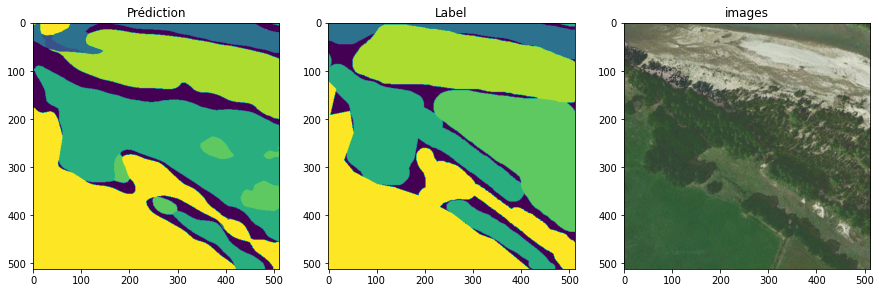

In [52]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
annotation = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [53]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
    label = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)
valid_imgs.shape,valid_labels.shape

((73, 512, 512, 3), (73, 512, 512, 3))

In [54]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [55]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [56]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

In [57]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [58]:
predictions = np.zeros(predictions.shape)

for idx_class in range(12):
    predictions[...,idx_class][label_pred == idx_class] = 1

IOU moyen et par classe

In [59]:
iou = []
for idx_classe in range(12):
    prediction = predictions[...,idx_classe]
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction)
    union = np.logical_or(target,prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.3354143675324025, 0.7145715018590747, 0.8328316463110689, 0.868408125769526, 0.656939025945751, 0.7800941853457731, 0.5225782764576791, 0.7399620968187087, 0.6794140230387826, 0.5856558459519546, 0.8679462218502145, 0.6506247937001933]
mIou:  0.6862033425484274


matrice de confusion par classe

In [60]:
conf_mat = np.zeros((12,12))

for idx_pred_class in range(12):
    for idx_target_class in range(12):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,predictions[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [61]:
classes = list(CLASSES)

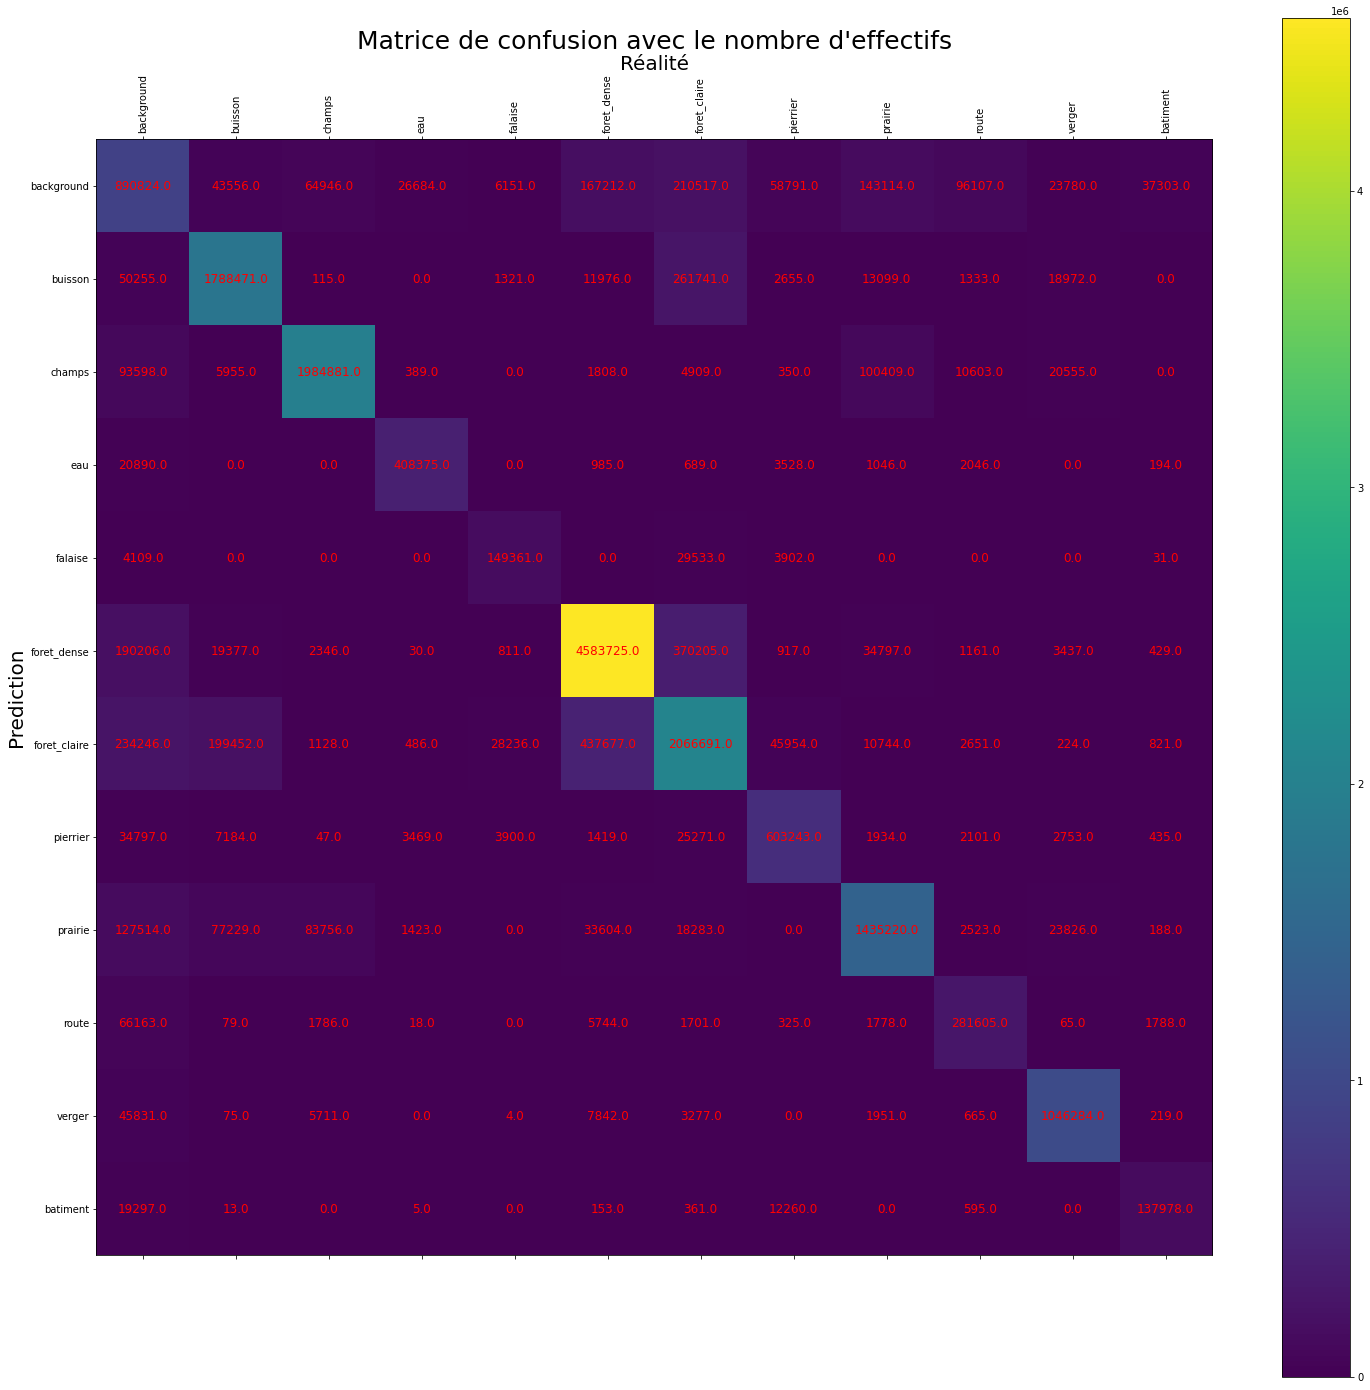

In [62]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()


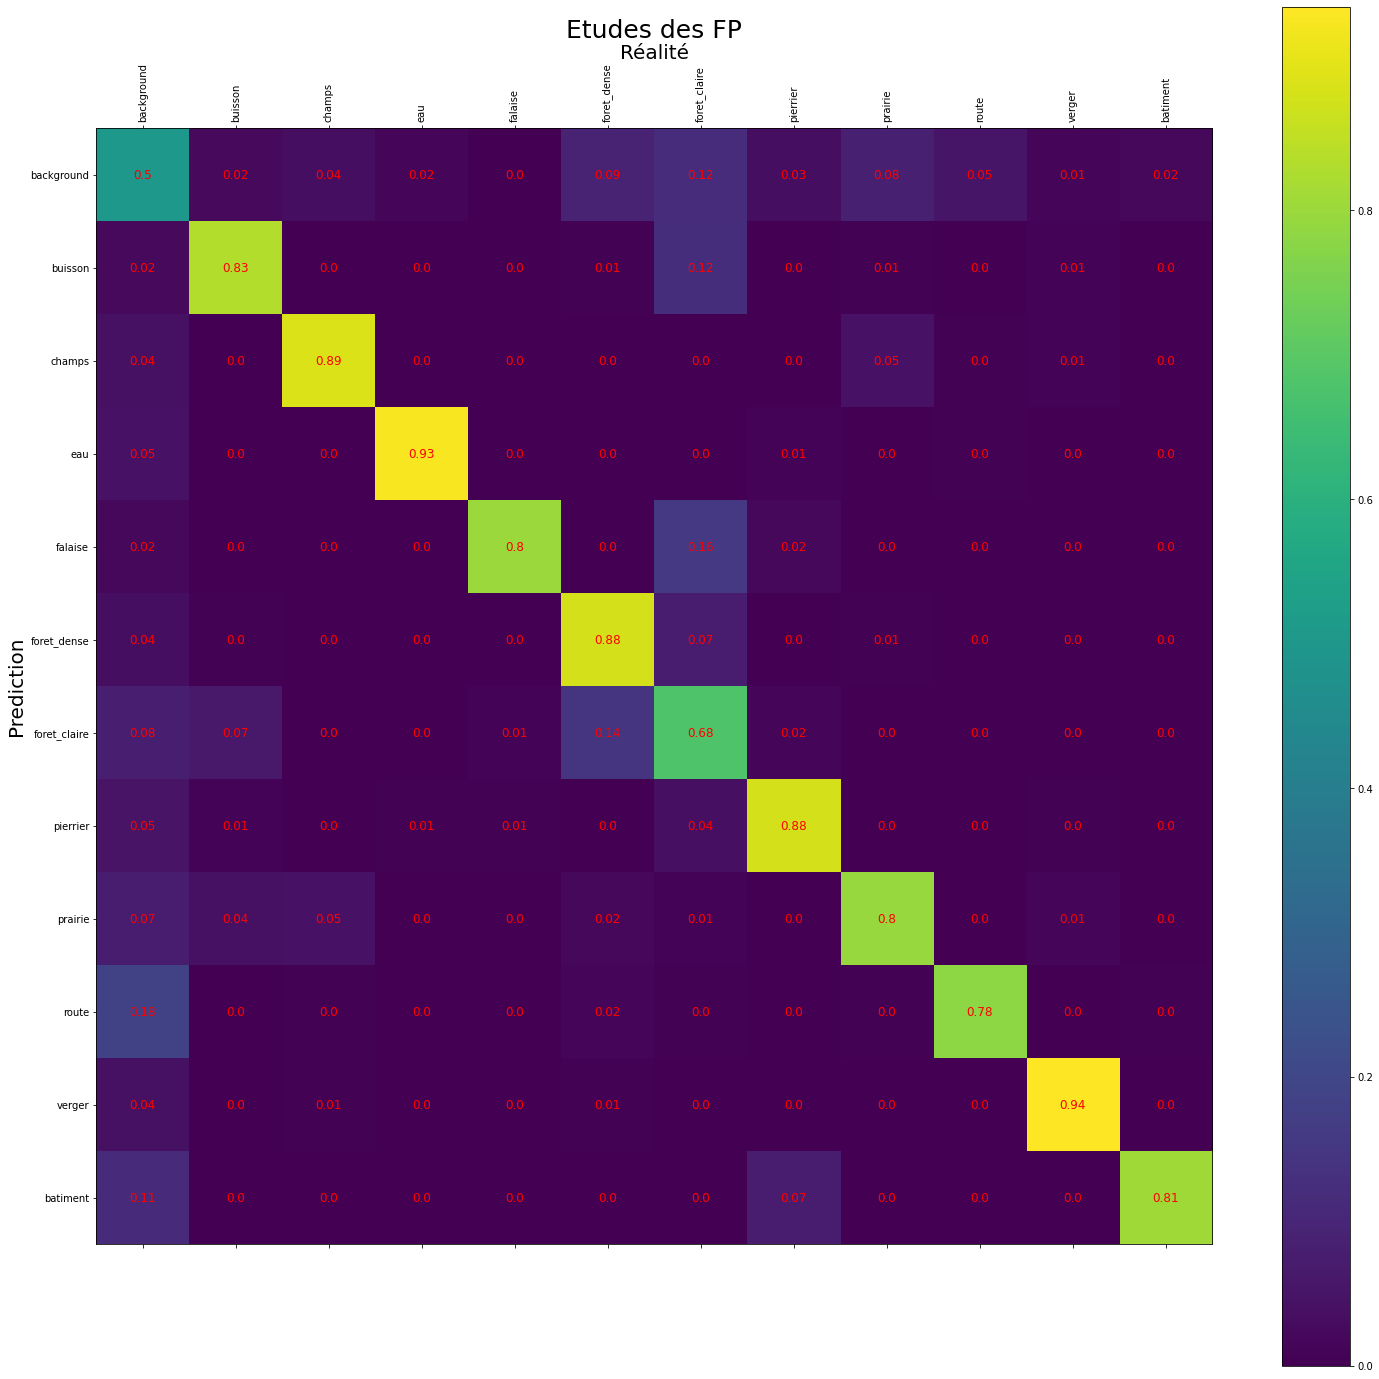

In [63]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

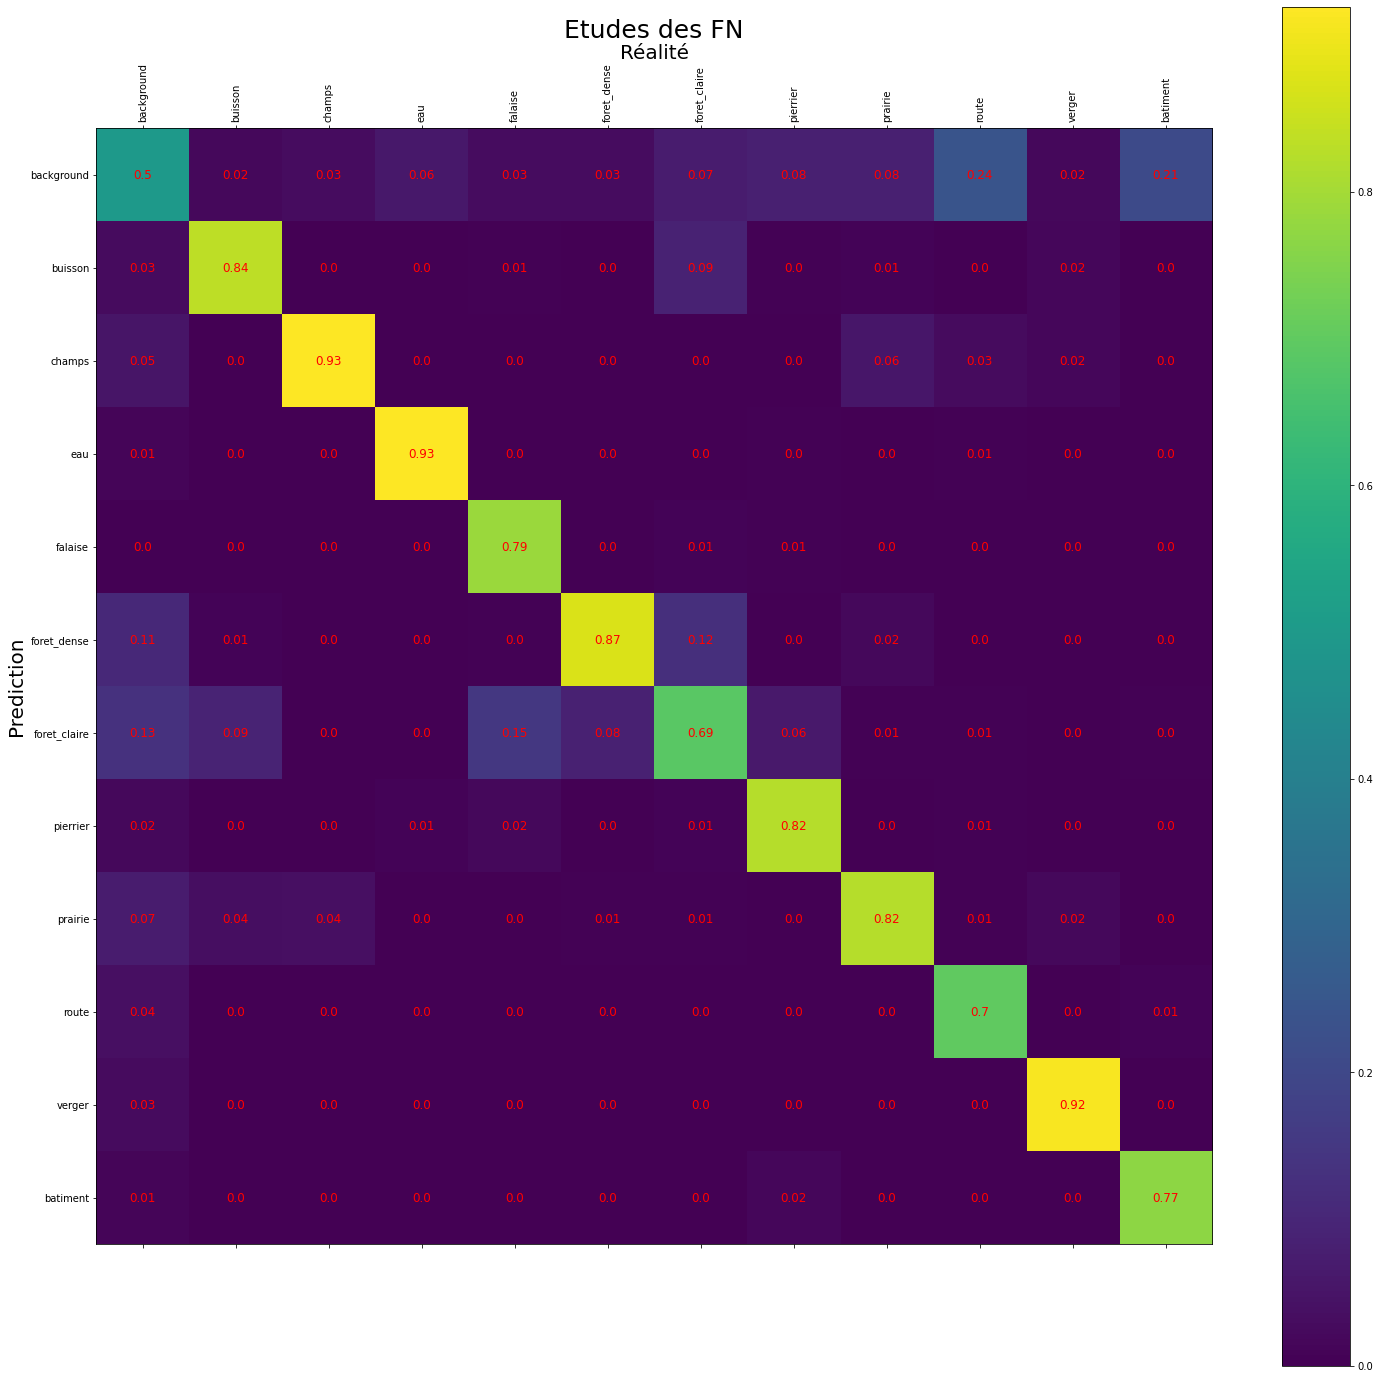

In [46]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()


In [47]:
dico = {}
for idx,classe in zip(range(12),classes):
    precision = conf_mat[idx,idx]/np.sum(conf_mat[idx,:])
    recall = conf_mat[idx,idx]/np.sum(conf_mat[:,idx])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classe] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'background': {'precision': 0.503579171106595,
  'recall': 0.5011019671153663,
  'f1': 0.5023375151372468},
 'buisson': {'precision': 0.831870965581333,
  'recall': 0.8351912378449335,
  'f1': 0.833527795235462},
 'champs': {'precision': 0.8927004210110652,
  'recall': 0.9254749813028857,
  'f1': 0.9087923028689568},
 'eau': {'precision': 0.9328890949919246,
  'recall': 0.9262745560573309,
  'f1': 0.9295700589097596},
 'falaise': {'precision': 0.7989953780973167,
  'recall': 0.7870052269948995,
  'f1': 0.7929549798258654},
 'foret_dense': {'precision': 0.8802260073613892,
  'recall': 0.8727339020533516,
  'f1': 0.8764639441752283},
 'foret_claire': {'precision': 0.6824568818912199,
  'recall': 0.6904671222359646,
  'f1': 0.6864386344372022},
 'pierrier': {'precision': 0.8786546705061372,
  'recall': 0.8241869043959422,
  'f1': 0.8505496736643078},
 'prairie': {'precision': 0.7957679397371652,
  'recall': 0.8229038376415923,
  'f1': 0.8091084315342686},
 'route': {'precision': 0.779956

In [48]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.8038398794887888
mean precision score is: 0.8105505485643718
mean recall score is: 0.7978299287702844


###  test sur jeu de synthese

#split train/val set randomly
data_root = "data/synthese2/"
split_dir = 'splits_synthese/'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  #select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  #select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
import re
valid_index = []
with open(osp.join(data_root, split_dir) + "val.txt", 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

In [ ]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
    label = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [ ]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
annotation = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [ ]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [ ]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

predictions = np.zeros(predictions.shape)

for idx_class in range(11):
    predictions[...,idx_class][label_pred == idx_class] = 1


In [ ]:
predictions.shape,valid_imgs.shape,valid_labels.shape

In [ ]:
classes_real = {0:"background",1:"buisson",2:"champs",3:"eau",
         4:"falaise",5:"foret_dense",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}


correspondance = {0:4,1:11,2:9,3:7,4:10,5:2,6:8,7:5,8:6,9:1,10:3,11:0}

In [ ]:
a = list(classes_syn.values())
a.append("background")

In [ ]:
iou = {}
for idx_classe in range(11):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,predictions[...,correspondance[idx_classe]])
    union = np.logical_or(target,predictions[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score

print(iou)  
print("mIou: ", np.mean(list(iou.values())))